In [1]:
import torch
import os
import json
import sys
from torch.nn import CosineSimilarity
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaForCausalLM, LlamaTokenizer
from functools import partial
from baukit import TraceDict
from einops import rearrange, einsum
from collections import defaultdict
import matplotlib.pyplot as plt
# from plotly_utils import imshow, scatter
from tqdm import tqdm
from datasets import Dataset
from torch.utils.data import DataLoader
import math
import seaborn as sns
from peft import PeftModel
import pickle
import matplotlib.patches as mpatches

import pysvelte
sys.path.append('../')
import analysis_utils
# from counterfactual_datasets.entity_tracking import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(10)

%load_ext autoreload
%autoreload 2

/home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
print("Model Loading...")
path = "/home/local_nikhil/Projects/llama_weights/7B"
# path = "AlekseyKorshuk/vicuna-7b"
# path = "/data/nikhil_prakash/goat-finetuning/weights_seed_3/checkpoint-800/"
# tokenizer = LlamaTokenizer.from_pretrained(path)
model = AutoModelForCausalLM.from_pretrained(path).to(device)

# base_model = "decapoda-research/llama-7b-hf"
# lora_weights = "tiedong/goat-lora-7b"

tokenizer = LlamaTokenizer.from_pretrained(
    "hf-internal-testing/llama-tokenizer", padding_side="right"
)

# model = LlamaForCausalLM.from_pretrained(
#     base_model,
#     load_in_8bit=False,
#     torch_dtype=torch.float32,
#     device_map="auto",
# )
# model = PeftModel.from_pretrained(
#     model,
#     lora_weights,
#     torch_dtype=torch.float32,
#     device_map={"": 0},
# )

tokenizer.pad_token_id = tokenizer.eos_token_id

Model Loading...


Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.81s/it]
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


## Evaluating Models

In [3]:
data_file = "../box_datasets/no_instructions/alternative/Random/7/train.jsonl"
object_file = "../box_datasets/filtered_objects_with_bnc_frequency.csv"
batch_size = 50

In [4]:
raw_data = entity_tracking_example_sampler(
    tokenizer=tokenizer,
    num_samples=500,
    data_file=data_file,
    # object_file=object_file,
    few_shot=False,
    alt_examples=True,
    # num_ents_or_ops=3,
    architecture="LlamaForCausalLM",
)

dataset = Dataset.from_dict(
    {
        "input_ids": raw_data[0],
        "last_token_indices": raw_data[1],
        "labels": raw_data[2],
    }
).with_format("torch")

print(f"Length of dataset: {len(dataset)}")

dataloader = DataLoader(dataset, batch_size=batch_size)

Length of dataset: 500


In [5]:
idx = 0
print(
    f"Prompt: {tokenizer.decode(dataset[idx]['input_ids'][:dataset[idx]['last_token_indices']+1])}"
)
print(f"Answer: {tokenizer.decode(dataset[idx]['labels'])}")

Prompt: <s>The document is in Box X, the pot is in Box T, the magnet is in Box A, the game is in Box E, the bill is in Box M, the cross is in Box K, the map is in Box D. Box X contains the
Answer: document


In [6]:
total_count = 0
correct_count = 0
model.eval()
errors = defaultdict(int)
with torch.no_grad():
    for _, output in tqdm(enumerate(tqdm(dataloader))):
        for k, v in output.items():
            if v is not None and isinstance(v, torch.Tensor):
                output[k] = v.to(model.device)

        outputs = model(input_ids=output["input_ids"])

        for bi in range(output["labels"].size(0)):
            label = output["labels"][bi]
            pred = torch.argmax(outputs.logits[bi][output["last_token_indices"][bi]])
            box_label = output["input_ids"][bi][output["last_token_indices"][bi] - 2]
            prev_box_label_pos = (
                output["input_ids"][bi].eq(box_label).nonzero()[:, 0][0].item()
            )
            prev_box_label_index = prev_box_label_pos // 8 + 1

            if label == pred:
                correct_count += 1
            else:
                errors[prev_box_label_index] += 1
                # print(prev_box_label_pos, prev_box_label_index)
                # print(f"Label: {tokenizer.decode(label)}, Prediction: {tokenizer.decode(pred)}")
            total_count += 1

del outputs
torch.cuda.empty_cache()

current_acc = round(correct_count / total_count, 2)
print(f"Task accuracy: {current_acc}")

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:21<00:00,  2.17s/it]
10it [00:21,  2.17s/it]

Task accuracy: 0.66


## Visualizing Head Attention

In [67]:
layer = 21
attn_scores, value_vectors = analysis_utils.get_attn_scores(model, base_tokens, layer)

In [68]:
value_vectors_norm = torch.norm(value_vectors, dim=-1)
scaled_attn = einsum(
    value_vectors_norm,
    attn_scores,
    "batch k_seq_len n_heads, batch n_heads q_seq_len k_seq_len -> batch n_heads q_seq_len k_seq_len",
)

In [72]:
index = 3
print(f"layer: {layer}, Bi: {index}")
pysvelte.AttentionMulti(
    tokens=[tokenizer.decode(token) for token in base_tokens[index].cpu().tolist()],
    attention=scaled_attn[index].permute(1, 2, 0).cpu(),
).show()

layer: 21, Bi: 3


### Ablating Correct Object Locator Heads in the Forward Setting

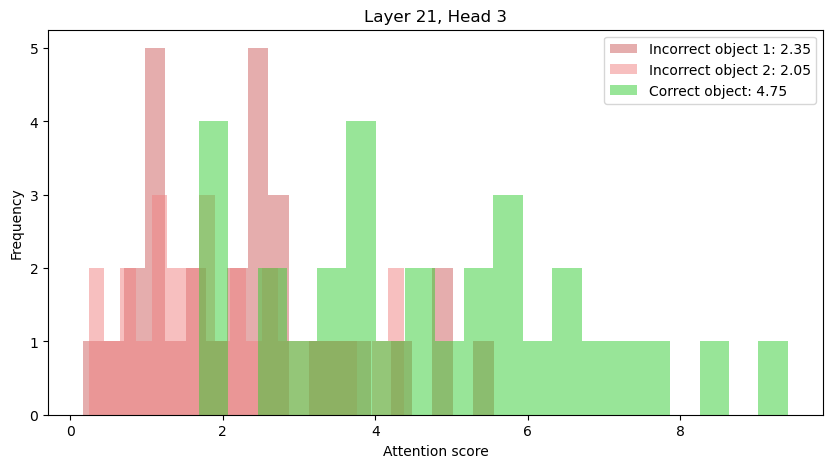

In [14]:
# Attention to objects in the context

correct_object_attn_scores = defaultdict(list)
incorrect_object_1_attn_scores = defaultdict(list)
incorrect_object_2_attn_scores = defaultdict(list)
self_attn_scores = defaultdict(list)
ablation_heads = [[14, 27], [11, 23], [12, 23]]

for layer, head in direct_logit_heads:
    attn_scores, value_vectors = analysis_utils.get_attn_scores(
        model,
        base_tokens,
        layer,
        ablation_heads=ablation_heads,
        last_token_pos=base_last_token_indices,
    )
    value_vectors_norm = torch.norm(value_vectors, dim=-1)
    attn_scores = einsum(
        value_vectors_norm,
        attn_scores,
        "batch k_seq_len n_heads, batch n_heads q_seq_len k_seq_len -> batch n_heads q_seq_len k_seq_len",
    )

    for bi in range(base_tokens.size(0)):
        correct_object = correct_answer_token[bi]
        incorrect_objects = incorrect_answer_token[bi]

        context = base_tokens[bi][: base_last_token_indices[bi] - 3]
        correct_object_pos_start = [
            pos for pos, token in enumerate(context) if token == correct_object
        ][0]
        correct_object_pos_end = [
            pos
            for pos, token in enumerate(context)
            if ((token == 29892 or token == 29889) and pos > correct_object_pos_start)
        ][0]

        incorrect_obj_1_pos_start = [
            pos for pos, token in enumerate(context) if token == incorrect_objects[0]
        ][0]
        incorrect_obj_1_pos_end = [
            pos
            for pos, token in enumerate(context)
            if ((token == 29892 or token == 29889) and pos > incorrect_obj_1_pos_start)
        ][0]

        incorrect_obj_2_pos_start = [
            pos for pos, token in enumerate(context) if token == incorrect_objects[1]
        ][0]
        incorrect_obj_2_pos_end = [
            pos
            for pos, token in enumerate(context)
            if ((token == 29892 or token == 29889) and pos > incorrect_obj_2_pos_start)
        ][0]

        self_attn_scores[(layer, head)].append(
            attn_scores[
                bi, head, base_last_token_indices[bi], base_last_token_indices[bi]
            ].item()
        )
        correct_object_attn_scores[(layer, head)].append(
            torch.sum(
                attn_scores[
                    bi,
                    head,
                    base_last_token_indices[bi],
                    correct_object_pos_start:correct_object_pos_end,
                ]
            ).item()
        )
        incorrect_object_1_attn_scores[(layer, head)].append(
            torch.sum(
                attn_scores[
                    bi,
                    head,
                    base_last_token_indices[bi],
                    incorrect_obj_1_pos_start:incorrect_obj_1_pos_end,
                ]
            ).item()
        )
        incorrect_object_2_attn_scores[(layer, head)].append(
            torch.sum(
                attn_scores[
                    bi,
                    head,
                    base_last_token_indices[bi],
                    incorrect_obj_2_pos_start:incorrect_obj_2_pos_end,
                ]
            ).item()
        )

    # Plotting
    plt.figure(figsize=(10, 5))
    # plt.hist(self_attn_scores[(layer, head)], bins=20, alpha=0.5, label=f"Self: {round(np.mean(self_attn_scores[(layer, head)]), 2)}", color="red")
    plt.hist(
        incorrect_object_1_attn_scores[(layer, head)],
        bins=20,
        alpha=0.5,
        label=f"Incorrect object 1: {round(np.mean(incorrect_object_1_attn_scores[(layer, head)]), 2)}",
        color="indianred",
    )
    plt.hist(
        incorrect_object_2_attn_scores[(layer, head)],
        bins=20,
        alpha=0.5,
        label=f"Incorrect object 2: {round(np.mean(incorrect_object_2_attn_scores[(layer, head)]), 2)}",
        color="lightcoral",
    )
    plt.hist(
        correct_object_attn_scores[(layer, head)],
        bins=20,
        alpha=0.5,
        label=f"Correct object: {round(np.mean(correct_object_attn_scores[(layer, head)]), 2)}",
        color="limegreen",
    )
    plt.ylabel("Frequency")
    plt.xlabel("Attention score")
    # plt.xlim([0, 1])
    plt.title(f"Layer {layer}, Head {head}")
    plt.legend()

    #     plt.savefig(
    #         os.path.join(
    #             "result_plots",
    #             "alternate_format",
    #             "attn_score_of_logit_heads",
    #             "attn_scores_{}_{}.png".format(layer, head),
    #         ),
    #         dpi=300,
    #         bbox_inches="tight",
    #     )
    plt.show()

### Activation Patching on Object Attender Heads

In [117]:
base_prompt = "Box X contains the glass, Box T contains the train, Box A contains the ladybug. Box X contains the"
base_tokens = tokenizer(base_prompt, return_tensors="pt").input_ids.to(device)
last_base_token_pos = (
    tokenizer(base_prompt, return_tensors="pt").attention_mask.to(device).sum(dim=-1)
    - 1
)
source_prompt = "Box X contains the glass, Box T contains the train, Box A contains the ladybug. Box A contains the"
source_tokens = tokenizer.encode(source_prompt, return_tensors="pt").to(device)
last_source_token_pos = (
    tokenizer(source_prompt, return_tensors="pt").attention_mask.to(device).sum(dim=-1)
    - 1
)

In [118]:
ablation_heads = heads_influencing_object_value_fetcher_heads
modules = list(
    set([f"model.layers.{layer}.self_attn.o_proj" for layer, _ in ablation_heads])
)

In [119]:
with torch.no_grad():
    with TraceDict(model, modules, retain_input=True) as source_cache:
        _ = model(source_tokens)

In [132]:
def patch_head_output(
    inputs=None, output=None, layer=None, heads=None, base_last=None, source_last=None
):
    input = inputs[0]
    # print(input.shape)
    input = rearrange(
        input,
        "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )
    cache = rearrange(
        source_cache[layer].output,
        "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )

    heads_at_curr_layer = [h for l, h in heads if l == int(layer.split(".")[2])]
    # print(heads_at_curr_layer, layer)

    for head in heads_at_curr_layer:
        input[0, base_last, head] = cache[0, source_last, head]

    input = rearrange(
        input,
        "batch seq_len n_heads d_head -> batch seq_len (n_heads d_head)",
        n_heads=model.config.num_attention_heads,
    )
    w_o = model.state_dict()[f"{layer}.weight"]
    output = einsum(
        input,
        w_o,
        "batch seq_len hidden_size, d_model hidden_size -> batch seq_len d_model",
    )

    return output

In [133]:
with torch.no_grad():
    with TraceDict(
        model,
        modules,
        retain_input=True,
        edit_output=partial(
            patch_head_output,
            heads=ablation_heads,
            base_last=last_base_token_pos,
            source_last=last_source_token_pos,
        ),
    ) as _:
        output = model(base_tokens)

In [134]:
logit, pred = torch.max(output.logits[0, -1], dim=-1)
print(f"{base_prompt}: '{tokenizer.decode(pred)}', {round(logit.item(), 2)}")
print(f"{source_prompt}")

Box X contains the glass, Box T contains the train, Box A contains the ladybug. Box X contains the: ' glass', 14.51
Box X contains the glass, Box T contains the train, Box A contains the ladybug. Box A contains the


In [70]:
output = model(source_tokens)
pred = torch.argmax(output.logits[0, -1], dim=-1).item()
print(f"{source_prompt}: '{tokenizer.decode(pred)}'")

Box X contains the glass, Box T contains the train, Box A contains the ladybug. Box A contains the: ' lady'


### Patching Residual Stream

In [24]:
original = "The bill is in Box X, the chemical is in Box T, the medicine is in Box A. Box E contains the"
original_tokens = tokenizer.encode(original, return_tensors="pt").to(device)
alternative = "The apple is in Box A, the banana is in Box T, the bell is in Box X. Box X contains the"
alternative_tokens = tokenizer.encode(alternative, return_tensors="pt").to(device)

modules = [f"model.layers.{layer}" for layer in range(32)]

In [25]:
with TraceDict(model, modules) as cache:
    _ = model(alternative_tokens)

In [30]:
def patch_residual(output, layer):
    residual = cache[layer].output
    output[0][:, -1] = residual[0][:, -1]

    return output

In [31]:
for layer in range(32):
    with TraceDict(model, [f"model.layers.{layer}"], edit_output=patch_residual) as _:
        output = model(original_tokens)
    logit, pred = torch.max(output.logits[0, -1], dim=-1)
    print(f"Layer: {layer}: '{tokenizer.decode(pred)}', {round(logit.item(), 2)}")

Layer: 0: ' key', 13.33
Layer: 1: ' key', 13.32
Layer: 2: ' key', 13.33
Layer: 3: ' key', 13.33
Layer: 4: ' key', 13.34
Layer: 5: ' key', 13.33
Layer: 6: ' key', 13.33
Layer: 7: ' key', 13.32
Layer: 8: ' key', 13.37
Layer: 9: ' key', 13.38
Layer: 10: ' key', 13.41
Layer: 11: ' chemical', 13.33
Layer: 12: ' chemical', 13.4
Layer: 13: ' chemical', 13.86
Layer: 14: ' medicine', 15.16
Layer: 15: ' chemical', 14.88
Layer: 16: ' chemical', 15.37
Layer: 17: ' chemical', 15.01
Layer: 18: ' chemical', 14.65
Layer: 19: ' chemical', 14.5
Layer: 20: ' bell', 15.51
Layer: 21: ' bell', 15.67
Layer: 22: ' bell', 15.56
Layer: 23: ' bell', 15.66
Layer: 24: ' bell', 15.41
Layer: 25: ' bell', 15.37
Layer: 26: ' bell', 15.28
Layer: 27: ' bell', 15.32
Layer: 28: ' bell', 15.55
Layer: 29: ' bell', 15.52
Layer: 30: ' bell', 15.73
Layer: 31: ' bell', 16.24


The engine is in Box S, the machine is in Box L, the brain is in Box I. Box I contains the: ' brain', 12.91


In [64]:
def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin, position_ids):
    # The first two dimensions of cos and sin are always 1, so we can `squeeze` them.
    cos = cos.squeeze(1).squeeze(0)  # [seq_len, dim]
    sin = sin.squeeze(1).squeeze(0)  # [seq_len, dim]
    cos = cos[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    sin = sin[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

In [65]:
def intervention_wrapper(batch_size, seq_len, from_pos, to_pos):
    def attention_knockout(inputs, output, layer):
        if "norm" in layer:
            return output
        global queries, keys, attn_outputs
        n_heads = model.config.num_attention_heads
        d_model = model.config.hidden_size
        d_head = d_model // n_heads
        layer_index = int(layer.split(".")[4])

        if "q_proj" in layer:
            query = output.view(batch_size, seq_len, n_heads, d_head).transpose(1, 2)
            queries[layer_index] = query

        elif "k_proj" in layer:
            key = output.view(batch_size, seq_len, n_heads, d_head).transpose(1, 2)
            keys[layer_index] = key

        elif "v_proj" in layer:
            value = output.view(batch_size, seq_len, n_heads, d_head).transpose(1, 2)
            key = keys[layer_index]
            query = queries[layer_index]

            kv_seq_len = key.shape[-2]
            cos, sin = model.base_model.model.model.layers[
                layer_index
            ].self_attn.rotary_emb(value, seq_len=kv_seq_len)
            positions = [i for i in range(seq_len)]
            positions = (
                torch.tensor(positions).unsqueeze(0).repeat(batch_size, 1).to(device)
            )
            query, key = apply_rotary_pos_emb(query, key, cos, sin, positions)

            attn_scores = einsum(
                key,
                query,
                "batch n_heads key_pos d_head, batch n_heads query_pos d_head -> batch n_heads query_pos key_pos",
            )
            attn_scores = attn_scores / math.sqrt(d_head)
            attn_scores = apply_causal_mask(attn_scores, layer, from_pos, to_pos)
            attn_scores = torch.softmax(attn_scores, dim=-1)
            attn_output = einsum(
                attn_scores,
                value,
                "batch n_heads query_pos key_pos, batch n_heads key_pos d_head -> batch query_pos n_heads d_head",
            )
            attn_output = attn_output.reshape(batch_size, seq_len, d_model)
            attn_outputs[layer_index] = attn_output

        elif "o_proj" in layer:
            attn_output = attn_outputs[layer_index]
            o_proj_weight = model.state_dict()[f"{layer}.weight"]
            output = einsum(
                attn_output,
                o_proj_weight,
                "batch seq_len d_model, hidden_size d_model -> batch seq_len hidden_size",
            )
            return output
        else:
            return output

    return attention_knockout

In [66]:
def compute_prev_query_box_pos(input_ids, last_token_index):
    query_box_token = input_ids[last_token_index - 2]
    prev_query_box_token_pos = (
        (input_ids[: last_token_index - 2] == query_box_token).nonzero().item()
    )
    return prev_query_box_token_pos

In [53]:
def compute_segments(inputs, correct_object_pos):
    segs = []
    segments = defaultdict(list)

    seg_end_pos = torch.cat(
        [inputs.eq(29892).nonzero()[:, 1], inputs.eq(29889).nonzero()[:, 1]]
    )
    for seg_idx in range(seg_end_pos.size(0)):
        segs.append(
            torch.arange(
                seg_end_pos[seg_idx - 1] + 1 if seg_idx > 0 else 1,
                seg_end_pos[seg_idx] + 1,
            )
        )
    for seg in segs:
        if correct_object_pos in seg:
            segments["correct_obj"] = seg
        else:
            if "incorrect_obj_1" not in segments:
                segments["incorrect_obj_1"] = seg
            else:
                segments["incorrect_obj_2"] = seg

    return segments

In [54]:
def apply_causal_mask(attn_scores, layer, from_pos, to_pos):
    ignore = torch.tensor(torch.finfo(attn_scores.dtype).min)
    mask = torch.triu(
        torch.ones(
            attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device
        ),
        diagonal=1,
    ).bool()
    attn_scores.masked_fill_(mask, ignore)

    # Attention knockout
    # layer_index = int(layer.split('.')[2])
    attn_scores[:, :, from_pos, to_pos] = ignore

    return attn_scores

In [56]:
accuracies = defaultdict(float)
comma_token = 29892
period_token = 29889
for knockout_layer in range(0, model.config.num_hidden_layers):
    modules = [
        [
            f"base_model.model.model.layers.{i}.self_attn.k_proj",
            f"base_model.model.model.layers.{i}.self_attn.q_proj",
            f"base_model.model.model.layers.{i}.self_attn.v_proj",
            f"base_model.model.model.layers.{i}.self_attn.o_proj",
        ]
        for i in range(knockout_layer, model.config.num_hidden_layers)
    ]

    modules = [item for sublist in modules for item in sublist]
    queries, keys, attn_outputs = {}, {}, {}

    model.eval()
    correct_count, total_count = 0, 0
    with torch.no_grad():
        for _, input in tqdm(enumerate(tqdm(dataloader)), desc=f"{knockout_layer}"):
            for k, v in input.items():
                if v is not None and isinstance(v, torch.Tensor):
                    input[k] = v.to(model.device)

            batch_size, seq_len = input["input_ids"].shape
            prev_box_label_index = compute_prev_query_box_pos(
                input["input_ids"][0], input["last_token_indices"][0]
            )
            correct_obj_pos = prev_box_label_index - 5

            with TraceDict(
                model,
                modules,
                retain_output=True,
                edit_output=intervention_wrapper(
                    batch_size,
                    seq_len,
                    from_pos=input["last_token_indices"],
                    to_pos=correct_obj_pos,
                ),
            ) as _:
                outputs = model(input_ids=input["input_ids"])

            for bi in range(input["labels"].size(0)):
                label = input["labels"][bi]
                pred = torch.argmax(outputs.logits[bi][input["last_token_indices"][bi]])

                if label == pred:
                    correct_count += 1
                total_count += 1

    del outputs
    torch.cuda.empty_cache()

    accuracies[knockout_layer] = round(correct_count / total_count, 2)

    print(f"Knockout Starting Layer {knockout_layer} acc: {accuracies[knockout_layer]}")

  0%|          | 0/100 [00:00<?, ?it/s]100%|██████████| 100/100 [00:24<00:00,  4.01it/s]
0: 100it [00:24,  4.01it/s]


Knockout Starting Layer 0 acc: 0.82


100%|██████████| 100/100 [00:24<00:00,  4.03it/s]
1: 100it [00:24,  4.03it/s]


Knockout Starting Layer 1 acc: 0.77


100%|██████████| 100/100 [00:23<00:00,  4.18it/s]
2: 100it [00:23,  4.18it/s]


Knockout Starting Layer 2 acc: 0.77


100%|██████████| 100/100 [00:23<00:00,  4.27it/s]
3: 100it [00:23,  4.27it/s]


Knockout Starting Layer 3 acc: 0.76


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]
4: 100it [00:23,  4.31it/s]


Knockout Starting Layer 4 acc: 0.76


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]
5: 100it [00:22,  4.47it/s]


Knockout Starting Layer 5 acc: 0.76


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]
6: 100it [00:22,  4.51it/s]


Knockout Starting Layer 6 acc: 0.79


100%|██████████| 100/100 [00:21<00:00,  4.60it/s]
7: 100it [00:21,  4.60it/s]


Knockout Starting Layer 7 acc: 0.79


100%|██████████| 100/100 [00:21<00:00,  4.70it/s]
8: 100it [00:21,  4.70it/s]


Knockout Starting Layer 8 acc: 0.79


100%|██████████| 100/100 [00:20<00:00,  4.87it/s]
9: 100it [00:20,  4.87it/s]


Knockout Starting Layer 9 acc: 0.76


100%|██████████| 100/100 [00:20<00:00,  4.94it/s]
10: 100it [00:20,  4.94it/s]


Knockout Starting Layer 10 acc: 0.81


100%|██████████| 100/100 [00:19<00:00,  5.03it/s]
11: 100it [00:19,  5.03it/s]


Knockout Starting Layer 11 acc: 0.8


100%|██████████| 100/100 [00:19<00:00,  5.14it/s]
12: 100it [00:19,  5.14it/s]


Knockout Starting Layer 12 acc: 0.79


100%|██████████| 100/100 [00:19<00:00,  5.24it/s]
13: 100it [00:19,  5.24it/s]


Knockout Starting Layer 13 acc: 0.81


100%|██████████| 100/100 [00:18<00:00,  5.36it/s]
14: 100it [00:18,  5.36it/s]


Knockout Starting Layer 14 acc: 0.8


100%|██████████| 100/100 [00:17<00:00,  5.68it/s]
15: 100it [00:17,  5.68it/s]


Knockout Starting Layer 15 acc: 0.8


100%|██████████| 100/100 [00:17<00:00,  5.73it/s]
16: 100it [00:17,  5.73it/s]


Knockout Starting Layer 16 acc: 0.85


100%|██████████| 100/100 [00:16<00:00,  5.93it/s]
17: 100it [00:16,  5.93it/s]


Knockout Starting Layer 17 acc: 0.85


100%|██████████| 100/100 [00:16<00:00,  6.11it/s]
18: 100it [00:16,  6.11it/s]


Knockout Starting Layer 18 acc: 0.85


100%|██████████| 100/100 [00:15<00:00,  6.32it/s]
19: 100it [00:15,  6.32it/s]


Knockout Starting Layer 19 acc: 0.84


100%|██████████| 100/100 [00:15<00:00,  6.50it/s]
20: 100it [00:15,  6.50it/s]


Knockout Starting Layer 20 acc: 0.84


100%|██████████| 100/100 [00:14<00:00,  6.91it/s]
21: 100it [00:14,  6.91it/s]


Knockout Starting Layer 21 acc: 0.83


100%|██████████| 100/100 [00:14<00:00,  7.05it/s]
22: 100it [00:14,  7.05it/s]


Knockout Starting Layer 22 acc: 0.84


100%|██████████| 100/100 [00:13<00:00,  7.47it/s]
23: 100it [00:13,  7.47it/s]


Knockout Starting Layer 23 acc: 0.84


100%|██████████| 100/100 [00:12<00:00,  7.69it/s]
24: 100it [00:12,  7.69it/s]


Knockout Starting Layer 24 acc: 0.85


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]
25: 100it [00:12,  8.25it/s]


Knockout Starting Layer 25 acc: 0.85


26: 14it [00:01,  8.17it/s]:01<00:10,  8.55it/s]
 14%|█▍        | 14/100 [00:01<00:10,  8.16it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:42                                                                                   │
│                                                                                                  │
│   39 │   │   │   │   │   to_pos=correct_obj_pos                                                  │
│   40 │   │   │   │   ),                                                                          │
│   41 │   │   │   ) as _:                                                                         │
│ ❱ 42 │   │   │   │   outputs = model(input_ids=input["input_ids"])                               │
│   43 │   │   │                                                                                   │
│   44 │   │   │   for bi in range(input["labels"].size(0)):                                       │
│   45 │   │   │   │   label = input["labels"][bi]                                                 │
│                                                                                                  │
│ /home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/torch/nn/modules/module.py:150 │
│ 1 in _call_impl                                                                                  │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/peft/peft_model.py:857 in      │
│ forward                                                                                          │
│                                                                                                  │
│    854 │   │   │   │   │   **kwargs,                                                             │
│    855 │   │   │   │   )                                                                         │
│    856 │   │   │                                                                                 │
│ ❱  857 │   │   │   return self.base_model(                                                       │
│    858 │   │   │   │   input_ids=input_ids,                                                      │
│    859 │   │   │   │   attention_mask=attention_mask,                                            │
│    860 │   │   │   │   inputs_embeds=inputs_embeds,                                              │
│                                                                                                  │
│ /home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/torch/nn/modules/module.py:150 │
│ 1 in _call_impl                                                                                  │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)    

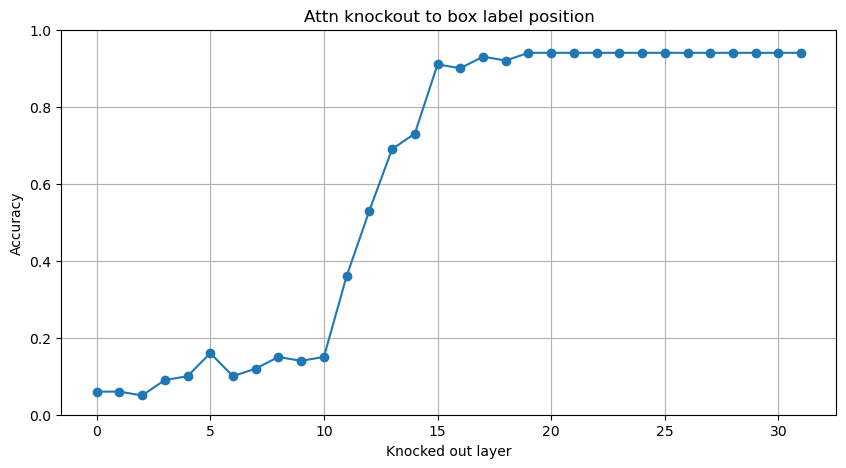

In [17]:
# Plot accuracies
plt.figure(figsize=(10, 5))
plt.plot(list(accuracies.keys()), list(accuracies.values()), marker="o")
plt.xlabel("Knocked out layer")
plt.ylabel("Accuracy")
plt.title("Attn knockout to box label position")
plt.ylim([0, 1])
plt.grid()
plt.show()

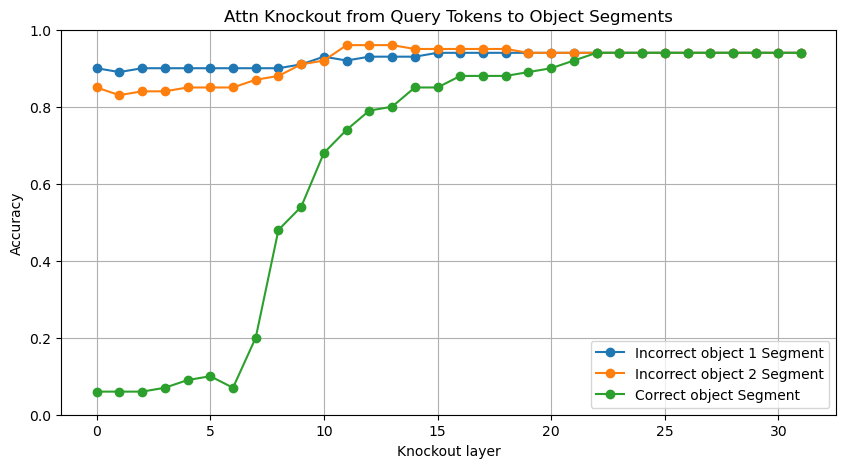

In [42]:
# plot accuracies for each knockout layer
plt.figure(figsize=(10, 5))
plt.plot(
    list(accuracies.keys()),
    [acc[1] for acc in accuracies.values()],
    label="Incorrect object 1 Segment",
    marker="o",
)
plt.plot(
    list(accuracies.keys()),
    [acc[2] for acc in accuracies.values()],
    label="Incorrect object 2 Segment",
    marker="o",
)
plt.plot(
    list(accuracies.keys()),
    [acc[0] for acc in accuracies.values()],
    label="Correct object Segment",
    marker="o",
)
plt.title("Attn Knockout from Query Tokens to Object Segments")
plt.xlabel("Knockout layer")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

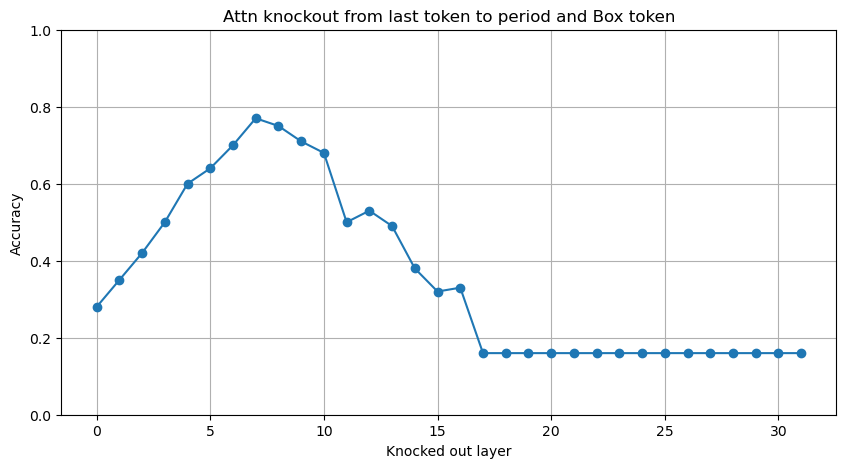

Text(0.5, 1.0, 'Attn Knockout from Query Tokens to Correct Object Segment')

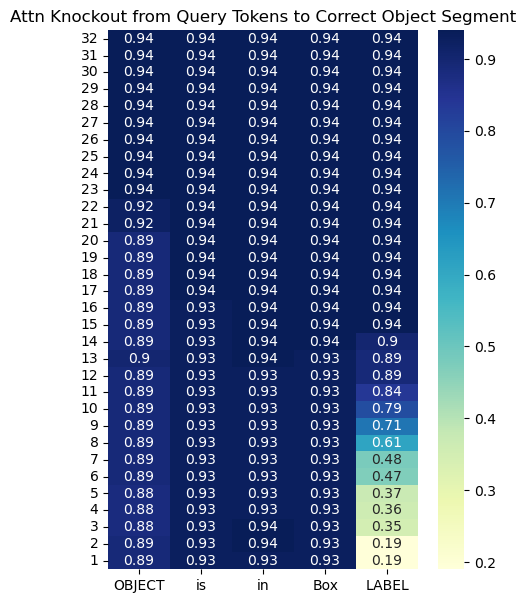

In [47]:
# Plot a heatmap of accuracies
accuracies_list = np.array(list(accuracies.values()))
accuracies_list = np.flip(accuracies_list, axis=0)

plt.figure(figsize=(5, 7))
sns.heatmap(
    accuracies_list,
    annot=True,
    cmap="YlGnBu",
    yticklabels=[i for i in range(32, 0, -1)],
    xticklabels=["OBJECT", "is", "in", "Box", "LABEL"],
)
plt.title("Attn Knockout from Query Tokens to Correct Object Segment")

## Evaluation Metrics

### Faithfulness

In [7]:
data_file = "../box_datasets/no_instructions/alternative/Random/7/train.jsonl"
object_file = "../box_datasets/filtered_objects_with_bnc_frequency.csv"
batch_size = 50

In [8]:
raw_data = generate_data_for_eval(
    tokenizer=tokenizer,
    num_samples=3500,
    data_file=data_file,
    num_boxes=7,
)

ablate_dataset = Dataset.from_dict(
    {
        "input_ids": raw_data[0],
        "last_token_indices": raw_data[1],
    }
).with_format("torch")

print(f"Length of dataset: {len(ablate_dataset)}")

ablate_dataloader = DataLoader(ablate_dataset, batch_size=batch_size)

Length of dataset: 500


In [9]:
idx = 0
print(
    f"Prompt: {tokenizer.decode(dataset[idx]['input_ids'][:dataset[idx]['last_token_indices']+1])}"
)

Prompt: <s>The document is in Box X, the pot is in Box T, the magnet is in Box A, the game is in Box E, the bill is in Box M, the cross is in Box K, the map is in Box D. Box X contains the


In [10]:
if model.config.architectures[0] == "LlamaForCausalLM":
    modules = [f"model.layers.{layer}.self_attn.o_proj" for layer in range(32)]
else:
    modules = [
        f"base_model.model.model.layers.{layer}.self_attn.o_proj" for layer in range(32)
    ]

mean_activations = {}
with torch.no_grad():
    # Assuming a single batch
    for _, output in enumerate(tqdm(ablate_dataloader)):
        for k, v in output.items():
            if v is not None and isinstance(v, torch.Tensor):
                output[k] = v.to(model.device)

        with TraceDict(model, modules, retain_input=True) as cache:
            _ = model(output["input_ids"])

        for layer in modules:
            if "self_attn" in layer:
                if layer in mean_activations:
                    mean_activations[layer] += torch.mean(cache[layer].input, dim=0)
                else:
                    mean_activations[layer] = torch.mean(cache[layer].input, dim=0)
            else:
                if layer in mean_activations:
                    mean_activations[layer] += torch.mean(cache[layer].output, dim=0)
                else:
                    mean_activations[layer] = torch.mean(cache[layer].output, dim=0)

        del cache
        torch.cuda.empty_cache()

    for layer in modules:
        mean_activations[layer] /= len(ablate_dataloader)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:21<00:00,  2.20s/it]


In [11]:
# circuit_components = {}
# circuit_components[0] = defaultdict(list)
# circuit_components[2] = defaultdict(list)
# circuit_components[-1] = defaultdict(list)
# circuit_components[-2] = defaultdict(list)

# root_path = "../path_patching/goat_circuits/1404"
# path = root_path + "/direct_logit_heads.pt"
# logit_values = torch.load(path)
# direct_logit_heads = analysis_utils.compute_topk_components(
#     torch.load(path), k=84, largest=False
# )

# path = root_path + "/heads_affect_direct_logit.pt"
# logit_values = torch.load(path)
# heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
#     torch.load(path), k=15, largest=False
# )

# path = root_path + "/heads_at_query_box_pos.pt"
# logit_values = torch.load(path)
# head_at_query_box_token = analysis_utils.compute_topk_components(
#     torch.load(path), k=35, largest=False
# )

# path = root_path + "/heads_at_prev_query_box_pos.pt"
# logit_values = torch.load(path)
# heads_at_prev_box_pos = analysis_utils.compute_topk_components(
#     torch.load(path), k=10, largest=False
# )

# intersection = []
# for head in direct_logit_heads:
#     if head in heads_affecting_direct_logit_heads:
#         intersection.append(head)

# for head in intersection:
#     direct_logit_heads.remove(head)

# print(
#     len(direct_logit_heads),
#     len(heads_affecting_direct_logit_heads),
#     len(head_at_query_box_token),
#     len(heads_at_prev_box_pos),
# )


# for layer_idx, head in direct_logit_heads:
#     if model.config.architectures[0] == "LlamaForCausalLM":
#         layer = f"model.layers.{layer_idx}.self_attn.o_proj"
#     else:
#         layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
#     circuit_components[0][layer].append(head)

# for layer_idx, head in heads_affecting_direct_logit_heads:
#     if model.config.architectures[0] == "LlamaForCausalLM":
#         layer = f"model.layers.{layer_idx}.self_attn.o_proj"
#     else:
#         layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
#     circuit_components[0][layer].append(head)


# for layer_idx, head in head_at_query_box_token:
#     if model.config.architectures[0] == "LlamaForCausalLM":
#         layer = f"model.layers.{layer_idx}.self_attn.o_proj"
#     else:
#         layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
#     circuit_components[2][layer].append(head)


# for layer_idx, head in heads_at_prev_box_pos:
#     if model.config.architectures[0] == "LlamaForCausalLM":
#         layer = f"model.layers.{layer_idx}.self_attn.o_proj"
#     else:
#         layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
#     circuit_components[-1][layer].append(head)

# for pos in circuit_components.keys():
#     for layer_idx in circuit_components[pos].keys():
#         circuit_components[pos][layer_idx] = list(
#             set(circuit_components[pos][layer_idx])
#         )

In [12]:
def mean_ablate(
    inputs, output, layer, circuit_components, mean_activations, input_tokens
):
    if isinstance(inputs, tuple):
        inputs = inputs[0]

    if isinstance(output, tuple):
        output = output[0]

    inputs = rearrange(
        inputs,
        "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )

    mean_act = rearrange(
        mean_activations[layer],
        "seq_len (n_heads d_head) -> 1 seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )

    last_pos = inputs.size(1) - 1
    for bi in range(inputs.size(0)):
        prev_query_box_pos = analysis_utils.compute_prev_query_box_pos(
            input_tokens[bi], input_tokens[bi].size(0) - 1
        )
        for token_pos in range(inputs.size(1)):
            if (
                token_pos != prev_query_box_pos
                and token_pos != last_pos
                and token_pos != last_pos - 2
                and token_pos != prev_query_box_pos + 1
            ):
                inputs[bi, token_pos, :] = mean_act[0, token_pos, :]
            elif token_pos == prev_query_box_pos:
                for head_idx in range(model.config.num_attention_heads):
                    if head_idx not in circuit_components[-1][layer]:
                        inputs[bi, token_pos, head_idx] = mean_act[
                            0, token_pos, head_idx
                        ]
            elif token_pos == prev_query_box_pos + 1:
                for head_idx in range(model.config.num_attention_heads):
                    if head_idx not in circuit_components[-2][layer]:
                        inputs[bi, token_pos, head_idx] = mean_act[
                            0, token_pos, head_idx
                        ]
            elif token_pos == last_pos:
                for head_idx in range(model.config.num_attention_heads):
                    if head_idx not in circuit_components[0][layer]:
                        inputs[bi, token_pos, head_idx] = mean_act[
                            0, token_pos, head_idx
                        ]
            elif token_pos == last_pos - 2:
                for head_idx in range(model.config.num_attention_heads):
                    if head_idx not in circuit_components[2][layer]:
                        inputs[bi, token_pos, head_idx] = mean_act[
                            0, token_pos, head_idx
                        ]

    inputs = rearrange(
        inputs,
        "batch seq_len n_heads d_head -> batch seq_len (n_heads d_head)",
        n_heads=model.config.num_attention_heads,
    )
    w_o = model.state_dict()[f"{layer}.weight"]
    output = einsum(
        inputs,
        w_o,
        "batch seq_len hidden_size, d_model hidden_size -> batch seq_len d_model",
    )

    return output

In [13]:
def eval(model, dataloader, modules, circuit_components, mean_activations):
    correct_count, total_count = 0, 0
    with torch.no_grad():
        for _, output in enumerate(tqdm(dataloader)):
            for k, v in output.items():
                if v is not None and isinstance(v, torch.Tensor):
                    output[k] = v.to(model.device)

            with TraceDict(
                model,
                modules,
                retain_input=True,
                edit_output=partial(
                    mean_ablate,
                    circuit_components=circuit_components,
                    mean_activations=mean_activations,
                    input_tokens=output["input_ids"],
                ),
            ) as _:
                outputs = model(output["input_ids"])

            for bi in range(output["labels"].size(0)):
                label = output["labels"][bi]
                pred = torch.argmax(
                    outputs.logits[bi][output["last_token_indices"][bi]]
                )

                if label == pred:
                    correct_count += 1
                # else:
                #     print(f"Label: {tokenizer.decode(label)}, Prediction: {tokenizer.decode(pred)}")
                total_count += 1

            del outputs
            torch.cuda.empty_cache()

    current_acc = round(correct_count / total_count, 2)
    print(f"Task accuracy: {current_acc}")
    return current_acc

In [14]:
# eval(model, dataloader, modules, circuit_components, mean_activations)

## Greedy Approach - Computing Pair Drop Values

In [13]:
n_value_fetcher = 62
n_pos_trans = 15
n_pos_detect = 30
n_struct_read = 5

### heads_at_prev_box_pos

In [17]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

greedy_res = defaultdict(lambda: defaultdict(float))

root_path = "../new_pp_exps/post_submission/goat-7b"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_value_fetcher, largest=False
)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_trans, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_detect, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(
    torch.load(path), k=n_struct_read, largest=False
)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)


for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)

for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)


for layer_idx_1, head_1 in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer_1 = f"model.layers.{layer_idx_1}.self_attn.o_proj"
    else:
        layer_1 = f"base_model.model.model.layers.{layer_idx_1}.self_attn.o_proj"

    circuit_components[-1][layer_1].remove(head_1)
    print("head 1:", layer_1, head_1)

    for layer_idx_2, head_2 in heads_at_prev_box_pos:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer_2 = f"model.layers.{layer_idx_2}.self_attn.o_proj"
        else:
            layer_2 = f"base_model.model.model.layers.{layer_idx_2}.self_attn.o_proj"
        if greedy_res[(layer_2, head_2)][(layer_1, head_1)] > 0.0:
            continue
        if layer_1 is not layer_2 and head_1 is not head_2:
            circuit_components[-1][layer_2].remove(head_2)
        print("head 2:", layer_2, head_2)
        greedy_res[(layer_1, head_1)][(layer_2, head_2)] = eval(
            model, dataloader, modules, circuit_components, mean_activations
        )
        if layer_1 is not layer_2 and head_1 is not head_2:
            circuit_components[-1][layer_2].append(head_2)

    circuit_components[-1][layer_1].append(head_1)

50 15 30 5
head 1: base_model.model.model.layers.8.self_attn.o_proj 21
head 2: base_model.model.model.layers.8.self_attn.o_proj 21


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.52
head 2: base_model.model.model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:38<00:00,  6.47s/it]


Task accuracy: 0.51
head 2: base_model.model.model.layers.11.self_attn.o_proj 9


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.52
head 2: base_model.model.model.layers.11.self_attn.o_proj 23


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.52
head 2: base_model.model.model.layers.12.self_attn.o_proj 13


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.53
head 1: base_model.model.model.layers.12.self_attn.o_proj 23
head 2: base_model.model.model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.11.self_attn.o_proj 9


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.11.self_attn.o_proj 23


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.12.self_attn.o_proj 13


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.64
head 1: base_model.model.model.layers.11.self_attn.o_proj 9
head 2: base_model.model.model.layers.11.self_attn.o_proj 9


100%|██████████| 6/6 [00:39<00:00,  6.54s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.11.self_attn.o_proj 23


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.12.self_attn.o_proj 13


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.66
head 1: base_model.model.model.layers.11.self_attn.o_proj 23
head 2: base_model.model.model.layers.11.self_attn.o_proj 23


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 13


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.65
head 1: base_model.model.model.layers.12.self_attn.o_proj 13
head 2: base_model.model.model.layers.12.self_attn.o_proj 13


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]

Task accuracy: 0.67


In [18]:
res = defaultdict(lambda: defaultdict(float))
for k in greedy_res:
    for k_2 in greedy_res[k]:
        if greedy_res[k][k_2] > 0.0:
            res[str(k)][str(k_2)] = greedy_res[k][k_2]
            res[str(k_2)][str(k)] = greedy_res[k][k_2]

In [19]:
with open("./post-submission/goat-7b/llama_heads_at_prev_box_pos.json", "w") as file:
    json.dump(res, file)

### head_at_query_box_token

In [20]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

greedy_res = defaultdict(lambda: defaultdict(float))

root_path = "../new_pp_exps/post_submission/goat-7b"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_value_fetcher, largest=False
)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_trans, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_detect, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(
    torch.load(path), k=n_struct_read, largest=False
)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)


for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)

for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)


for layer_idx_1, head_1 in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer_1 = f"model.layers.{layer_idx_1}.self_attn.o_proj"
    else:
        layer_1 = f"base_model.model.model.layers.{layer_idx_1}.self_attn.o_proj"

    circuit_components[2][layer_1].remove(head_1)
    print("head 1:", layer_1, head_1)

    for layer_idx_2, head_2 in head_at_query_box_token:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer_2 = f"model.layers.{layer_idx_2}.self_attn.o_proj"
        else:
            layer_2 = f"base_model.model.model.layers.{layer_idx_2}.self_attn.o_proj"

        if greedy_res[(layer_2, head_2)][(layer_1, head_1)] > 0.0:
            continue
        if layer_1 is not layer_2 and head_1 is not head_2:
            circuit_components[2][layer_2].remove(head_2)

        print("head 2:", layer_2, head_2)
        greedy_res[(layer_1, head_1)][(layer_2, head_2)] = eval(
            model, dataloader, modules, circuit_components, mean_activations
        )
        if layer_1 is not layer_2 and head_1 is not head_2:
            circuit_components[2][layer_2].append(head_2)

    circuit_components[2][layer_1].append(head_1)

50 15 30 5
head 1: base_model.model.model.layers.10.self_attn.o_proj 3
head 2: base_model.model.model.layers.10.self_attn.o_proj 3


100%|██████████| 6/6 [00:39<00:00,  6.54s/it]


Task accuracy: 0.5
head 2: base_model.model.model.layers.13.self_attn.o_proj 14


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.47
head 2: base_model.model.model.layers.9.self_attn.o_proj 2


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.46
head 2: base_model.model.model.layers.9.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.49
head 2: base_model.model.model.layers.11.self_attn.o_proj 23


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.48
head 2: base_model.model.model.layers.11.self_attn.o_proj 24


100%|██████████| 6/6 [00:39<00:00,  6.54s/it]


Task accuracy: 0.48
head 2: base_model.model.model.layers.9.self_attn.o_proj 10


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.39
head 2: base_model.model.model.layers.6.self_attn.o_proj 10


100%|██████████| 6/6 [00:39<00:00,  6.54s/it]


Task accuracy: 0.45
head 2: base_model.model.model.layers.7.self_attn.o_proj 17


100%|██████████| 6/6 [00:38<00:00,  6.49s/it]


Task accuracy: 0.49
head 2: base_model.model.model.layers.1.self_attn.o_proj 9


100%|██████████| 6/6 [00:39<00:00,  6.53s/it]


Task accuracy: 0.47
head 2: base_model.model.model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.53
head 2: base_model.model.model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.48
head 2: base_model.model.model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.46
head 2: base_model.model.model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.49
head 2: base_model.model.model.layers.12.self_attn.o_proj 8


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.48
head 2: base_model.model.model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.50s/it]


Task accuracy: 0.49
head 2: base_model.model.model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:38<00:00,  6.46s/it]


Task accuracy: 0.5
head 2: base_model.model.model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:39<00:00,  6.53s/it]


Task accuracy: 0.5
head 2: base_model.model.model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.52
head 2: base_model.model.model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.54s/it]


Task accuracy: 0.51
head 2: base_model.model.model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:38<00:00,  6.47s/it]


Task accuracy: 0.53
head 2: base_model.model.model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.54s/it]


Task accuracy: 0.48
head 2: base_model.model.model.layers.12.self_attn.o_proj 20


100%|██████████| 6/6 [00:39<00:00,  6.53s/it]


Task accuracy: 0.49
head 2: base_model.model.model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:38<00:00,  6.47s/it]


Task accuracy: 0.5
head 2: base_model.model.model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.51
head 2: base_model.model.model.layers.13.self_attn.o_proj 25


100%|██████████| 6/6 [00:39<00:00,  6.53s/it]


Task accuracy: 0.51
head 2: base_model.model.model.layers.12.self_attn.o_proj 5


100%|██████████| 6/6 [00:38<00:00,  6.47s/it]


Task accuracy: 0.49
head 2: base_model.model.model.layers.11.self_attn.o_proj 2


100%|██████████| 6/6 [00:38<00:00,  6.43s/it]


Task accuracy: 0.49
head 2: base_model.model.model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:39<00:00,  6.54s/it]


Task accuracy: 0.47
head 2: base_model.model.model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.54s/it]


Task accuracy: 0.5
head 1: base_model.model.model.layers.13.self_attn.o_proj 14
head 2: base_model.model.model.layers.13.self_attn.o_proj 14


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.63
head 2: base_model.model.model.layers.9.self_attn.o_proj 2


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.63
head 2: base_model.model.model.layers.9.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.52s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.11.self_attn.o_proj 23


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.59
head 2: base_model.model.model.layers.11.self_attn.o_proj 24


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.9.self_attn.o_proj 10


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.55
head 2: base_model.model.model.layers.6.self_attn.o_proj 10


100%|██████████| 6/6 [00:39<00:00,  6.52s/it]


Task accuracy: 0.57
head 2: base_model.model.model.layers.7.self_attn.o_proj 17


100%|██████████| 6/6 [00:38<00:00,  6.50s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.1.self_attn.o_proj 9


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.6
head 2: base_model.model.model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:38<00:00,  6.50s/it]


Task accuracy: 0.49
head 2: base_model.model.model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.52s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.12.self_attn.o_proj 8


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.53s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:39<00:00,  6.54s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:39<00:00,  6.54s/it]


Task accuracy: 0.63
head 2: base_model.model.model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.48s/it]


Task accuracy: 0.63
head 2: base_model.model.model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:38<00:00,  6.47s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.12.self_attn.o_proj 20


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:39<00:00,  6.53s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.63
head 2: base_model.model.model.layers.13.self_attn.o_proj 25


100%|██████████| 6/6 [00:39<00:00,  6.51s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.12.self_attn.o_proj 5


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.11.self_attn.o_proj 2


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.63
head 2: base_model.model.model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.63
head 1: base_model.model.model.layers.9.self_attn.o_proj 2
head 2: base_model.model.model.layers.9.self_attn.o_proj 2


100%|██████████| 6/6 [00:39<00:00,  6.53s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.9.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.54s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.11.self_attn.o_proj 23


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.11.self_attn.o_proj 24


100%|██████████| 6/6 [00:38<00:00,  6.47s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.9.self_attn.o_proj 10


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.58
head 2: base_model.model.model.layers.6.self_attn.o_proj 10


100%|██████████| 6/6 [00:39<00:00,  6.61s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.7.self_attn.o_proj 17


100%|██████████| 6/6 [00:38<00:00,  6.48s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.1.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.42s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.43s/it]


Task accuracy: 0.69
head 2: base_model.model.model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.52s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.55
head 2: base_model.model.model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 8


100%|██████████| 6/6 [00:38<00:00,  6.44s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.53s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:39<00:00,  6.54s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.54s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.46s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:38<00:00,  6.45s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 20


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.13.self_attn.o_proj 25


100%|██████████| 6/6 [00:39<00:00,  6.54s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.12.self_attn.o_proj 5


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.11.self_attn.o_proj 2


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.53s/it]


Task accuracy: 0.68
head 1: base_model.model.model.layers.9.self_attn.o_proj 7
head 2: base_model.model.model.layers.9.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.44s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.11.self_attn.o_proj 23


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.58
head 2: base_model.model.model.layers.11.self_attn.o_proj 24


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.9.self_attn.o_proj 10


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.58
head 2: base_model.model.model.layers.6.self_attn.o_proj 10


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.7.self_attn.o_proj 17


100%|██████████| 6/6 [00:38<00:00,  6.49s/it]


Task accuracy: 0.63
head 2: base_model.model.model.layers.1.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.42s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.50s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:39<00:00,  6.62s/it]


Task accuracy: 0.52
head 2: base_model.model.model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:38<00:00,  6.47s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 8


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.47s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:38<00:00,  6.45s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:39<00:00,  6.52s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.12.self_attn.o_proj 20


100%|██████████| 6/6 [00:39<00:00,  6.50s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:39<00:00,  6.54s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.43s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.13.self_attn.o_proj 25


100%|██████████| 6/6 [00:39<00:00,  6.54s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.12.self_attn.o_proj 5


100%|██████████| 6/6 [00:38<00:00,  6.47s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.11.self_attn.o_proj 2


100%|██████████| 6/6 [00:38<00:00,  6.48s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.66
head 1: base_model.model.model.layers.11.self_attn.o_proj 23
head 2: base_model.model.model.layers.11.self_attn.o_proj 23


100%|██████████| 6/6 [00:38<00:00,  6.44s/it]


Task accuracy: 0.57
head 2: base_model.model.model.layers.11.self_attn.o_proj 24


100%|██████████| 6/6 [00:38<00:00,  6.47s/it]


Task accuracy: 0.6
head 2: base_model.model.model.layers.9.self_attn.o_proj 10


100%|██████████| 6/6 [00:38<00:00,  6.45s/it]


Task accuracy: 0.54
head 2: base_model.model.model.layers.6.self_attn.o_proj 10


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.7.self_attn.o_proj 17


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.57
head 2: base_model.model.model.layers.1.self_attn.o_proj 9


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.6
head 2: base_model.model.model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.59
head 2: base_model.model.model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.59
head 2: base_model.model.model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.46
head 2: base_model.model.model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:38<00:00,  6.43s/it]


Task accuracy: 0.57
head 2: base_model.model.model.layers.12.self_attn.o_proj 8


100%|██████████| 6/6 [00:38<00:00,  6.50s/it]


Task accuracy: 0.58
head 2: base_model.model.model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.57
head 2: base_model.model.model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.57
head 2: base_model.model.model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.58
head 2: base_model.model.model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.56
head 2: base_model.model.model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.50s/it]


Task accuracy: 0.59
head 2: base_model.model.model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:38<00:00,  6.43s/it]


Task accuracy: 0.56
head 2: base_model.model.model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:38<00:00,  6.44s/it]


Task accuracy: 0.57
head 2: base_model.model.model.layers.12.self_attn.o_proj 20


100%|██████████| 6/6 [00:38<00:00,  6.44s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:38<00:00,  6.43s/it]


Task accuracy: 0.58
head 2: base_model.model.model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.48s/it]


Task accuracy: 0.57
head 2: base_model.model.model.layers.13.self_attn.o_proj 25


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.59
head 2: base_model.model.model.layers.12.self_attn.o_proj 5


100%|██████████| 6/6 [00:38<00:00,  6.43s/it]


Task accuracy: 0.57
head 2: base_model.model.model.layers.11.self_attn.o_proj 2


100%|██████████| 6/6 [00:38<00:00,  6.42s/it]


Task accuracy: 0.57
head 2: base_model.model.model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.6
head 2: base_model.model.model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.48s/it]


Task accuracy: 0.57
head 1: base_model.model.model.layers.11.self_attn.o_proj 24
head 2: base_model.model.model.layers.11.self_attn.o_proj 24


100%|██████████| 6/6 [00:38<00:00,  6.46s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.9.self_attn.o_proj 10


100%|██████████| 6/6 [00:39<00:00,  6.50s/it]


Task accuracy: 0.57
head 2: base_model.model.model.layers.6.self_attn.o_proj 10


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.7.self_attn.o_proj 17


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.1.self_attn.o_proj 9


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.52
head 2: base_model.model.model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 8


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:39<00:00,  6.61s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 20


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.13.self_attn.o_proj 25


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.12.self_attn.o_proj 5


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.11.self_attn.o_proj 2


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.67
head 1: base_model.model.model.layers.9.self_attn.o_proj 10
head 2: base_model.model.model.layers.9.self_attn.o_proj 10


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.59
head 2: base_model.model.model.layers.6.self_attn.o_proj 10


100%|██████████| 6/6 [00:39<00:00,  6.61s/it]


Task accuracy: 0.59
head 2: base_model.model.model.layers.7.self_attn.o_proj 17


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.58
head 2: base_model.model.model.layers.1.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.46s/it]


Task accuracy: 0.55
head 2: base_model.model.model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.48s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.58
head 2: base_model.model.model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.46
head 2: base_model.model.model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.57
head 2: base_model.model.model.layers.12.self_attn.o_proj 8


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.58
head 2: base_model.model.model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.58
head 2: base_model.model.model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.59
head 2: base_model.model.model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.59
head 2: base_model.model.model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.59
head 2: base_model.model.model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.58
head 2: base_model.model.model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.6
head 2: base_model.model.model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.50s/it]


Task accuracy: 0.58
head 2: base_model.model.model.layers.12.self_attn.o_proj 20


100%|██████████| 6/6 [00:38<00:00,  6.45s/it]


Task accuracy: 0.58
head 2: base_model.model.model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.6
head 2: base_model.model.model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.59
head 2: base_model.model.model.layers.13.self_attn.o_proj 25


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.58
head 2: base_model.model.model.layers.12.self_attn.o_proj 5


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.57
head 2: base_model.model.model.layers.11.self_attn.o_proj 2


100%|██████████| 6/6 [00:39<00:00,  6.63s/it]


Task accuracy: 0.59
head 2: base_model.model.model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.57
head 2: base_model.model.model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.51s/it]


Task accuracy: 0.59
head 1: base_model.model.model.layers.6.self_attn.o_proj 10
head 2: base_model.model.model.layers.6.self_attn.o_proj 10


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.7.self_attn.o_proj 17


100%|██████████| 6/6 [00:39<00:00,  6.61s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.1.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.45s/it]


Task accuracy: 0.6
head 2: base_model.model.model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.50s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.63
head 2: base_model.model.model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.54
head 2: base_model.model.model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.54s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.12.self_attn.o_proj 8


100%|██████████| 6/6 [00:38<00:00,  6.50s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:39<00:00,  6.54s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.12.self_attn.o_proj 20


100%|██████████| 6/6 [00:38<00:00,  6.44s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.13.self_attn.o_proj 25


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.12.self_attn.o_proj 5


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.63
head 2: base_model.model.model.layers.11.self_attn.o_proj 2


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:39<00:00,  6.50s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.51s/it]


Task accuracy: 0.64
head 1: base_model.model.model.layers.7.self_attn.o_proj 17
head 2: base_model.model.model.layers.7.self_attn.o_proj 17


100%|██████████| 6/6 [00:39<00:00,  6.54s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.1.self_attn.o_proj 9


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.54
head 2: base_model.model.model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.12.self_attn.o_proj 8


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:38<00:00,  6.49s/it]


Task accuracy: 0.63
head 2: base_model.model.model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.45s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.51s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:38<00:00,  6.49s/it]


Task accuracy: 0.63
head 2: base_model.model.model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.12.self_attn.o_proj 20


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.59
head 2: base_model.model.model.layers.13.self_attn.o_proj 25


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 5


100%|██████████| 6/6 [00:38<00:00,  6.44s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.11.self_attn.o_proj 2


100%|██████████| 6/6 [00:39<00:00,  6.51s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:39<00:00,  6.53s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.53s/it]


Task accuracy: 0.65
head 1: base_model.model.model.layers.1.self_attn.o_proj 9
head 2: base_model.model.model.layers.1.self_attn.o_proj 9


100%|██████████| 6/6 [00:39<00:00,  6.51s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.53s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.53s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:39<00:00,  6.53s/it]


Task accuracy: 0.53
head 2: base_model.model.model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.12.self_attn.o_proj 8


100%|██████████| 6/6 [00:39<00:00,  6.51s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.48s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.51s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.51s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:38<00:00,  6.47s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:38<00:00,  6.42s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.12.self_attn.o_proj 20


100%|██████████| 6/6 [00:39<00:00,  6.54s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.13.self_attn.o_proj 25


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 5


100%|██████████| 6/6 [00:39<00:00,  6.54s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.11.self_attn.o_proj 2


100%|██████████| 6/6 [00:39<00:00,  6.54s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:38<00:00,  6.44s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.43s/it]


Task accuracy: 0.66
head 1: base_model.model.model.layers.10.self_attn.o_proj 7
head 2: base_model.model.model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.47s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.69
head 2: base_model.model.model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.49
head 2: base_model.model.model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 8


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.44s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:38<00:00,  6.50s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.50s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 20


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.69
head 2: base_model.model.model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.13.self_attn.o_proj 25


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.7
head 2: base_model.model.model.layers.12.self_attn.o_proj 5


100%|██████████| 6/6 [00:39<00:00,  6.52s/it]


Task accuracy: 0.69
head 2: base_model.model.model.layers.11.self_attn.o_proj 2


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:39<00:00,  6.61s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.68
head 1: base_model.model.model.layers.13.self_attn.o_proj 0
head 2: base_model.model.model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.51
head 2: base_model.model.model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 8


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:38<00:00,  6.46s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.45s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:38<00:00,  6.49s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.61s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 20


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.61s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.13.self_attn.o_proj 25


100%|██████████| 6/6 [00:39<00:00,  6.63s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 5


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.11.self_attn.o_proj 2


100%|██████████| 6/6 [00:39<00:00,  6.61s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.50s/it]


Task accuracy: 0.66
head 1: base_model.model.model.layers.9.self_attn.o_proj 21
head 2: base_model.model.model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.5
head 2: base_model.model.model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.62s/it]


Task accuracy: 0.5
head 2: base_model.model.model.layers.12.self_attn.o_proj 8


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.5
head 2: base_model.model.model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.5
head 2: base_model.model.model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.5
head 2: base_model.model.model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.44s/it]


Task accuracy: 0.5
head 2: base_model.model.model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.52s/it]


Task accuracy: 0.47
head 2: base_model.model.model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.49
head 2: base_model.model.model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:39<00:00,  6.61s/it]


Task accuracy: 0.51
head 2: base_model.model.model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.49
head 2: base_model.model.model.layers.12.self_attn.o_proj 20


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.52
head 2: base_model.model.model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.51
head 2: base_model.model.model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.53s/it]


Task accuracy: 0.5
head 2: base_model.model.model.layers.13.self_attn.o_proj 25


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.52
head 2: base_model.model.model.layers.12.self_attn.o_proj 5


100%|██████████| 6/6 [00:39<00:00,  6.62s/it]


Task accuracy: 0.5
head 2: base_model.model.model.layers.11.self_attn.o_proj 2


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.5
head 2: base_model.model.model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:39<00:00,  6.61s/it]


Task accuracy: 0.51
head 2: base_model.model.model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.5
head 1: base_model.model.model.layers.12.self_attn.o_proj 0
head 2: base_model.model.model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 8


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.63s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.12.self_attn.o_proj 20


100%|██████████| 6/6 [00:38<00:00,  6.46s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:38<00:00,  6.44s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.61s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.13.self_attn.o_proj 25


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 5


100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.11.self_attn.o_proj 2


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:38<00:00,  6.48s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.48s/it]


Task accuracy: 0.65
head 1: base_model.model.model.layers.12.self_attn.o_proj 8
head 2: base_model.model.model.layers.12.self_attn.o_proj 8


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.49s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:39<00:00,  6.51s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.43s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:38<00:00,  6.45s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:38<00:00,  6.47s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 20


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:38<00:00,  6.48s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.42s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.13.self_attn.o_proj 25


100%|██████████| 6/6 [00:38<00:00,  6.49s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.12.self_attn.o_proj 5


100%|██████████| 6/6 [00:38<00:00,  6.50s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.11.self_attn.o_proj 2


100%|██████████| 6/6 [00:39<00:00,  6.50s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:38<00:00,  6.45s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.44s/it]


Task accuracy: 0.67
head 1: base_model.model.model.layers.13.self_attn.o_proj 12
head 2: base_model.model.model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.45s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:38<00:00,  6.45s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.54s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.50s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:38<00:00,  6.42s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.51s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 20


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.13.self_attn.o_proj 25


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 5


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.11.self_attn.o_proj 2


100%|██████████| 6/6 [00:38<00:00,  6.48s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:39<00:00,  6.51s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.67
head 1: base_model.model.model.layers.12.self_attn.o_proj 23
head 2: base_model.model.model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.63
head 2: base_model.model.model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.12.self_attn.o_proj 20


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.13.self_attn.o_proj 25


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 5


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.11.self_attn.o_proj 2


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.66
head 1: base_model.model.model.layers.12.self_attn.o_proj 9
head 2: base_model.model.model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 20


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.13.self_attn.o_proj 25


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 5


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.11.self_attn.o_proj 2


100%|██████████| 6/6 [00:39<00:00,  6.56s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:39<00:00,  6.61s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.67
head 1: base_model.model.model.layers.10.self_attn.o_proj 4
head 2: base_model.model.model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.12.self_attn.o_proj 20


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.13.self_attn.o_proj 25


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.12.self_attn.o_proj 5


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.11.self_attn.o_proj 2


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.50s/it]


Task accuracy: 0.64
head 1: base_model.model.model.layers.5.self_attn.o_proj 7
head 2: base_model.model.model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.4.self_attn.o_proj 4


 33%|███▎      | 2/6 [00:13<00:26,  6.61s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [21]:
res = defaultdict(lambda: defaultdict(float))
for k in greedy_res:
    for k_2 in greedy_res[k]:
        if greedy_res[k][k_2] > 0.0:
            res[str(k)][str(k_2)] = greedy_res[k][k_2]
            res[str(k_2)][str(k)] = greedy_res[k][k_2]

with open("./post-submission/goat-7b/head_at_query_box_token.json", "w") as file:
    json.dump(res, file)

### direct_logit_heads

In [ ]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

greedy_res = defaultdict(lambda: defaultdict(float))

root_path = "../new_pp_exps/post_submission/goat-7b"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_value_fetcher, largest=False
)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_trans, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_detect, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(
    torch.load(path), k=n_struct_read, largest=False
)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)


for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)

for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)


for layer_idx_1, head_1 in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer_1 = f"model.layers.{layer_idx_1}.self_attn.o_proj"
    else:
        layer_1 = f"base_model.model.model.layers.{layer_idx_1}.self_attn.o_proj"

    circuit_components[0][layer_1].remove(head_1)
    print("head 1:", layer_1, head_1)

    for layer_idx_2, head_2 in direct_logit_heads:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer_2 = f"model.layers.{layer_idx_2}.self_attn.o_proj"
        else:
            layer_2 = f"base_model.model.model.layers.{layer_idx_2}.self_attn.o_proj"
        if greedy_res[(layer_2, head_2)][(layer_1, head_1)] > 0.0:
            continue
        if layer_1 is not layer_2 and head_1 is not head_2:
            circuit_components[0][layer_2].remove(head_2)
        print("head 2:", layer_2, head_2)
        greedy_res[(layer_1, head_1)][(layer_2, head_2)] = eval(
            model, dataloader, modules, circuit_components, mean_activations
        )
        if layer_1 is not layer_2 and head_1 is not head_2:
            circuit_components[0][layer_2].append(head_2)

    circuit_components[0][layer_1].append(head_1)

50 15 30 5
head 1: base_model.model.model.layers.24.self_attn.o_proj 5
head 2: base_model.model.model.layers.24.self_attn.o_proj 5


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.18.self_attn.o_proj 3


100%|██████████| 6/6 [00:39<00:00,  6.67s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.21.self_attn.o_proj 3


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.63
head 2: base_model.model.model.layers.17.self_attn.o_proj 28


100%|██████████| 6/6 [00:40<00:00,  6.69s/it]


Task accuracy: 0.59
head 2: base_model.model.model.layers.18.self_attn.o_proj 8


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.20.self_attn.o_proj 14


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.59
head 2: base_model.model.model.layers.21.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.58
head 2: base_model.model.model.layers.15.self_attn.o_proj 5


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.30.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.29.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.6
head 2: base_model.model.model.layers.19.self_attn.o_proj 30


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.18.self_attn.o_proj 28


100%|██████████| 6/6 [00:40<00:00,  6.67s/it]


Task accuracy: 0.6
head 2: base_model.model.model.layers.23.self_attn.o_proj 15


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.17.self_attn.o_proj 8


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.23.self_attn.o_proj 5


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.24.self_attn.o_proj 8


100%|██████████| 6/6 [00:39<00:00,  6.62s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.23.self_attn.o_proj 30


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.23.self_attn.o_proj 17


100%|██████████| 6/6 [00:39<00:00,  6.63s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.31.self_attn.o_proj 6


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.13.self_attn.o_proj 13


100%|██████████| 6/6 [00:40<00:00,  6.67s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.28.self_attn.o_proj 17


100%|██████████| 6/6 [00:40<00:00,  6.69s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.19.self_attn.o_proj 11


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.6
head 2: base_model.model.model.layers.30.self_attn.o_proj 8


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.18.self_attn.o_proj 20


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.31.self_attn.o_proj 26


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.31.self_attn.o_proj 1


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.19.self_attn.o_proj 8


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.6
head 2: base_model.model.model.layers.28.self_attn.o_proj 16


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.14.self_attn.o_proj 11


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.31.self_attn.o_proj 29


100%|██████████| 6/6 [00:40<00:00,  6.69s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.15.self_attn.o_proj 1


100%|██████████| 6/6 [00:39<00:00,  6.61s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.23.self_attn.o_proj 16


100%|██████████| 6/6 [00:39<00:00,  6.62s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.31.self_attn.o_proj 25


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.31.self_attn.o_proj 23


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.21.self_attn.o_proj 19


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.19.self_attn.o_proj 26


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.6
head 2: base_model.model.model.layers.19.self_attn.o_proj 20


100%|██████████| 6/6 [00:39<00:00,  6.63s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.17.self_attn.o_proj 27


100%|██████████| 6/6 [00:40<00:00,  6.69s/it]


Task accuracy: 0.6
head 2: base_model.model.model.layers.19.self_attn.o_proj 16


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.24.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.19.self_attn.o_proj 2


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.23.self_attn.o_proj 19


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.6
head 2: base_model.model.model.layers.31.self_attn.o_proj 14


100%|██████████| 6/6 [00:39<00:00,  6.63s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.18.self_attn.o_proj 6


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.15.self_attn.o_proj 6


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.6
head 2: base_model.model.model.layers.17.self_attn.o_proj 3


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.15.self_attn.o_proj 31


100%|██████████| 6/6 [00:40<00:00,  6.67s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.13.self_attn.o_proj 9


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.59
head 2: base_model.model.model.layers.22.self_attn.o_proj 5


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.15.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.61
head 1: base_model.model.model.layers.18.self_attn.o_proj 3
head 2: base_model.model.model.layers.18.self_attn.o_proj 3


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.21.self_attn.o_proj 3


100%|██████████| 6/6 [00:39<00:00,  6.63s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.17.self_attn.o_proj 28


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.18.self_attn.o_proj 8


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.63
head 2: base_model.model.model.layers.20.self_attn.o_proj 14


100%|██████████| 6/6 [00:39<00:00,  6.67s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.21.self_attn.o_proj 4


100%|██████████| 6/6 [00:40<00:00,  6.67s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.15.self_attn.o_proj 5


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.30.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.29.self_attn.o_proj 7


100%|██████████| 6/6 [00:39<00:00,  6.63s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.19.self_attn.o_proj 30


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.18.self_attn.o_proj 28


100%|██████████| 6/6 [00:39<00:00,  6.62s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.23.self_attn.o_proj 15


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.17.self_attn.o_proj 8


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.23.self_attn.o_proj 5


100%|██████████| 6/6 [00:40<00:00,  6.69s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.24.self_attn.o_proj 8


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.23.self_attn.o_proj 30


100%|██████████| 6/6 [00:39<00:00,  6.63s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.23.self_attn.o_proj 17


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.31.self_attn.o_proj 6


100%|██████████| 6/6 [00:39<00:00,  6.63s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.13.self_attn.o_proj 13


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.28.self_attn.o_proj 17


100%|██████████| 6/6 [00:39<00:00,  6.63s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.19.self_attn.o_proj 11


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.30.self_attn.o_proj 8


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.18.self_attn.o_proj 20


100%|██████████| 6/6 [00:40<00:00,  6.67s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.31.self_attn.o_proj 26


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.31.self_attn.o_proj 1


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.19.self_attn.o_proj 8


 67%|██████▋   | 4/6 [00:26<00:13,  6.62s/it]

In [ ]:
res = defaultdict(lambda: defaultdict(float))
for k in greedy_res:
    for k_2 in greedy_res[k]:
        if greedy_res[k][k_2] > 0.0:
            res[str(k)][str(k_2)] = greedy_res[k][k_2]
            res[str(k_2)][str(k)] = greedy_res[k][k_2]

with open("./post-submission/goat-7b/direct_logit_heads.json", "w") as file:
    json.dump(res, file)

### heads_affecting_direct_logit_heads

In [14]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

greedy_res = defaultdict(lambda: defaultdict(float))

root_path = "../new_pp_exps/post_submission/goat-7b"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_value_fetcher, largest=False
)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_trans, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_detect, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(
    torch.load(path), k=n_struct_read, largest=False
)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)


for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)

for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)


for layer_idx_1, head_1 in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer_1 = f"model.layers.{layer_idx_1}.self_attn.o_proj"
    else:
        layer_1 = f"base_model.model.model.layers.{layer_idx_1}.self_attn.o_proj"

    circuit_components[0][layer_1].remove(head_1)
    print("head 1:", layer_1, head_1)

    for layer_idx_2, head_2 in heads_affecting_direct_logit_heads:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer_2 = f"model.layers.{layer_idx_2}.self_attn.o_proj"
        else:
            layer_2 = f"base_model.model.model.layers.{layer_idx_2}.self_attn.o_proj"
        if greedy_res[(layer_2, head_2)][(layer_1, head_1)] > 0.0:
            continue
        if layer_1 is not layer_2 and head_1 is not head_2:
            circuit_components[0][layer_2].remove(head_2)
        print("head 2:", layer_2, head_2)
        greedy_res[(layer_1, head_1)][(layer_2, head_2)] = eval(
            model, dataloader, modules, circuit_components, mean_activations
        )
        if layer_1 is not layer_2 and head_1 is not head_2:
            circuit_components[0][layer_2].append(head_2)

    circuit_components[0][layer_1].append(head_1)

50 15 30 5
head 1: base_model.model.model.layers.14.self_attn.o_proj 27
head 2: base_model.model.model.layers.14.self_attn.o_proj 27


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.28
head 2: base_model.model.model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:40<00:00,  6.68s/it]


Task accuracy: 0.15
head 2: base_model.model.model.layers.11.self_attn.o_proj 23


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.22
head 2: base_model.model.model.layers.17.self_attn.o_proj 26


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.27
head 2: base_model.model.model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.63s/it]


Task accuracy: 0.23
head 2: base_model.model.model.layers.19.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.63s/it]


Task accuracy: 0.26
head 2: base_model.model.model.layers.13.self_attn.o_proj 14


100%|██████████| 6/6 [00:40<00:00,  6.67s/it]


Task accuracy: 0.21
head 2: base_model.model.model.layers.16.self_attn.o_proj 16


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.27
head 2: base_model.model.model.layers.16.self_attn.o_proj 2


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.26
head 2: base_model.model.model.layers.13.self_attn.o_proj 1


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.26
head 2: base_model.model.model.layers.14.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.24
head 2: base_model.model.model.layers.15.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.67s/it]


Task accuracy: 0.26
head 2: base_model.model.model.layers.16.self_attn.o_proj 28


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.26
head 2: base_model.model.model.layers.15.self_attn.o_proj 13


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.24
head 2: base_model.model.model.layers.15.self_attn.o_proj 18


100%|██████████| 6/6 [00:40<00:00,  6.67s/it]


Task accuracy: 0.28
head 1: base_model.model.model.layers.12.self_attn.o_proj 23
head 2: base_model.model.model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.11.self_attn.o_proj 23


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.17.self_attn.o_proj 26


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.67s/it]


Task accuracy: 0.6
head 2: base_model.model.model.layers.19.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.13.self_attn.o_proj 14


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.16.self_attn.o_proj 16


100%|██████████| 6/6 [00:40<00:00,  6.69s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.16.self_attn.o_proj 2


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.13.self_attn.o_proj 1


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.14.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.15.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.67s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.16.self_attn.o_proj 28


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.15.self_attn.o_proj 13


100%|██████████| 6/6 [00:39<00:00,  6.67s/it]


Task accuracy: 0.59
head 2: base_model.model.model.layers.15.self_attn.o_proj 18


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.61
head 1: base_model.model.model.layers.11.self_attn.o_proj 23
head 2: base_model.model.model.layers.11.self_attn.o_proj 23


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.6
head 2: base_model.model.model.layers.17.self_attn.o_proj 26


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.59
head 2: base_model.model.model.layers.19.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.13.self_attn.o_proj 14


100%|██████████| 6/6 [00:39<00:00,  6.63s/it]


Task accuracy: 0.6
head 2: base_model.model.model.layers.16.self_attn.o_proj 16


100%|██████████| 6/6 [00:40<00:00,  6.68s/it]


Task accuracy: 0.59
head 2: base_model.model.model.layers.16.self_attn.o_proj 2


100%|██████████| 6/6 [00:40<00:00,  6.67s/it]


Task accuracy: 0.6
head 2: base_model.model.model.layers.13.self_attn.o_proj 1


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.6
head 2: base_model.model.model.layers.14.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.58
head 2: base_model.model.model.layers.15.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.57
head 2: base_model.model.model.layers.16.self_attn.o_proj 28


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.58
head 2: base_model.model.model.layers.15.self_attn.o_proj 13


100%|██████████| 6/6 [00:40<00:00,  6.68s/it]


Task accuracy: 0.56
head 2: base_model.model.model.layers.15.self_attn.o_proj 18


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.6
head 1: base_model.model.model.layers.17.self_attn.o_proj 26
head 2: base_model.model.model.layers.17.self_attn.o_proj 26


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.69
head 2: base_model.model.model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:40<00:00,  6.68s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.19.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.69
head 2: base_model.model.model.layers.13.self_attn.o_proj 14


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.16.self_attn.o_proj 16


100%|██████████| 6/6 [00:40<00:00,  6.68s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.16.self_attn.o_proj 2


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.69
head 2: base_model.model.model.layers.13.self_attn.o_proj 1


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.14.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.15.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.16.self_attn.o_proj 28


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.68
head 2: base_model.model.model.layers.15.self_attn.o_proj 13


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.64
head 2: base_model.model.model.layers.15.self_attn.o_proj 18


100%|██████████| 6/6 [00:40<00:00,  6.72s/it]


Task accuracy: 0.67
head 1: base_model.model.model.layers.13.self_attn.o_proj 0
head 2: base_model.model.model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.19.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.13.self_attn.o_proj 14


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.63
head 2: base_model.model.model.layers.16.self_attn.o_proj 16


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.16.self_attn.o_proj 2


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.13.self_attn.o_proj 1


100%|██████████| 6/6 [00:40<00:00,  6.68s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.14.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.15.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.16.self_attn.o_proj 28


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.15.self_attn.o_proj 13


100%|██████████| 6/6 [00:40<00:00,  6.67s/it]


Task accuracy: 0.63
head 2: base_model.model.model.layers.15.self_attn.o_proj 18


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.65
head 1: base_model.model.model.layers.19.self_attn.o_proj 12
head 2: base_model.model.model.layers.19.self_attn.o_proj 12


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.13.self_attn.o_proj 14


100%|██████████| 6/6 [00:40<00:00,  6.68s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.16.self_attn.o_proj 16


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.16.self_attn.o_proj 2


100%|██████████| 6/6 [00:40<00:00,  6.67s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.13.self_attn.o_proj 1


100%|██████████| 6/6 [00:39<00:00,  6.67s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.14.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.15.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.16.self_attn.o_proj 28


100%|██████████| 6/6 [00:40<00:00,  6.68s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.15.self_attn.o_proj 13


100%|██████████| 6/6 [00:40<00:00,  6.67s/it]


Task accuracy: 0.61
head 2: base_model.model.model.layers.15.self_attn.o_proj 18


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.65
head 1: base_model.model.model.layers.13.self_attn.o_proj 14
head 2: base_model.model.model.layers.13.self_attn.o_proj 14


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.16.self_attn.o_proj 16


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.16.self_attn.o_proj 2


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.13.self_attn.o_proj 1


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.14.self_attn.o_proj 0


100%|██████████| 6/6 [00:40<00:00,  6.69s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.15.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.16.self_attn.o_proj 28


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.15.self_attn.o_proj 13


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.6
head 2: base_model.model.model.layers.15.self_attn.o_proj 18


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.64
head 1: base_model.model.model.layers.16.self_attn.o_proj 16
head 2: base_model.model.model.layers.16.self_attn.o_proj 16


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.16.self_attn.o_proj 2


100%|██████████| 6/6 [00:39<00:00,  6.63s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.13.self_attn.o_proj 1


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.14.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.62s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.15.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.16.self_attn.o_proj 28


100%|██████████| 6/6 [00:39<00:00,  6.62s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.15.self_attn.o_proj 13


100%|██████████| 6/6 [00:40<00:00,  6.68s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.15.self_attn.o_proj 18


100%|██████████| 6/6 [00:40<00:00,  6.68s/it]


Task accuracy: 0.65
head 1: base_model.model.model.layers.16.self_attn.o_proj 2
head 2: base_model.model.model.layers.16.self_attn.o_proj 2


100%|██████████| 6/6 [00:40<00:00,  6.68s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.13.self_attn.o_proj 1


100%|██████████| 6/6 [00:39<00:00,  6.67s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.14.self_attn.o_proj 0


100%|██████████| 6/6 [00:40<00:00,  6.67s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.15.self_attn.o_proj 4


100%|██████████| 6/6 [00:40<00:00,  6.67s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.16.self_attn.o_proj 28


100%|██████████| 6/6 [00:40<00:00,  6.68s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.15.self_attn.o_proj 13


100%|██████████| 6/6 [00:39<00:00,  6.63s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.15.self_attn.o_proj 18


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.66
head 1: base_model.model.model.layers.13.self_attn.o_proj 1
head 2: base_model.model.model.layers.13.self_attn.o_proj 1


100%|██████████| 6/6 [00:39<00:00,  6.61s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.14.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.62s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.15.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.61s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.16.self_attn.o_proj 28


100%|██████████| 6/6 [00:39<00:00,  6.61s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.15.self_attn.o_proj 13


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.15.self_attn.o_proj 18


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.65
head 1: base_model.model.model.layers.14.self_attn.o_proj 0
head 2: base_model.model.model.layers.14.self_attn.o_proj 0


100%|██████████| 6/6 [00:39<00:00,  6.61s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.15.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.16.self_attn.o_proj 28


100%|██████████| 6/6 [00:39<00:00,  6.60s/it]


Task accuracy: 0.65
head 2: base_model.model.model.layers.15.self_attn.o_proj 13


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.15.self_attn.o_proj 18


100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


Task accuracy: 0.65
head 1: base_model.model.model.layers.15.self_attn.o_proj 4
head 2: base_model.model.model.layers.15.self_attn.o_proj 4


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.67
head 2: base_model.model.model.layers.16.self_attn.o_proj 28


100%|██████████| 6/6 [00:40<00:00,  6.67s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.15.self_attn.o_proj 13


100%|██████████| 6/6 [00:39<00:00,  6.63s/it]


Task accuracy: 0.6
head 2: base_model.model.model.layers.15.self_attn.o_proj 18


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.66
head 1: base_model.model.model.layers.16.self_attn.o_proj 28
head 2: base_model.model.model.layers.16.self_attn.o_proj 28


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.66
head 2: base_model.model.model.layers.15.self_attn.o_proj 13


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


Task accuracy: 0.62
head 2: base_model.model.model.layers.15.self_attn.o_proj 18


100%|██████████| 6/6 [00:40<00:00,  6.67s/it]


Task accuracy: 0.65
head 1: base_model.model.model.layers.15.self_attn.o_proj 13
head 2: base_model.model.model.layers.15.self_attn.o_proj 13


100%|██████████| 6/6 [00:40<00:00,  6.69s/it]


Task accuracy: 0.63
head 2: base_model.model.model.layers.15.self_attn.o_proj 18


100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


Task accuracy: 0.61
head 1: base_model.model.model.layers.15.self_attn.o_proj 18
head 2: base_model.model.model.layers.15.self_attn.o_proj 18


100%|██████████| 6/6 [00:39<00:00,  6.61s/it]

Task accuracy: 0.65


In [15]:
res = defaultdict(lambda: defaultdict(float))
for k in greedy_res:
    for k_2 in greedy_res[k]:
        if greedy_res[k][k_2] > 0.0:
            res[str(k)][str(k_2)] = greedy_res[k][k_2]
            res[str(k_2)][str(k)] = greedy_res[k][k_2]

with open(
    "./post-submission/goat-7b/heads_affecting_direct_logit_heads.json", "w"
) as file:
    json.dump(res, file)

## Greedy search - Computing the set

In [30]:
def string_to_tuple(myStr):
    myStr = myStr.replace("(", "")
    myStr = myStr.replace(")", "")
    myStr = myStr.replace(",", " ")
    myList = myStr.split()
    myList = list(map(str, myList))
    myTuple = tuple(myList)
    return myTuple

In [31]:
n_value_fetcher = 84
n_pos_trans = 15
n_pos_detect = 35
n_struct_read = 10
percentage = 0.2

### llama_heads_at_prev_box_pos.json

In [33]:
import json

with open("./post-submission/llama-7b/llama_heads_at_prev_box_pos.json", "r") as f:
    data = json.load(f)

In [34]:
ranked = defaultdict(list)
for k_1 in data:
    for k_2 in data[k_1]:
        ranked[k_1].append((k_2, data[k_2][k_2] - data[k_1][k_2]))
for k_1 in ranked:
    ranked[k_1].sort(key=(lambda x: x[1]), reverse=True)

In [37]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

res = {}

root_path = "../new_pp_exps/post_submission/llama-7b"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_value_fetcher, largest=False
)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_trans, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_detect, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(
    torch.load(path), k=n_struct_read, largest=False
)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)

for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)

for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)

eval(model, dataloader, modules, circuit_components, mean_activations)


for layer_idx, head in tqdm(heads_at_prev_box_pos):
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"

    print(layer, head)
    # Form the set using only the top 30% of the heads
    for r in ranked[str((layer, head))][: math.ceil(percentage * len(ranked.values()))]:
        top_layer = r[0].split(",")[0][2:-1]
        top_head = int(r[0].split(",")[1][:-1])
        print("remove", top_layer, top_head)
        circuit_components[-1][top_layer].remove(top_head)

    befor = eval(model, dataloader, modules, circuit_components, mean_activations)
    circuit_components[-1][layer].remove(head)
    after = eval(model, dataloader, modules, circuit_components, mean_activations)
    res[(layer, head)] = (befor, after)

    for r in ranked[str((layer, head))][: math.ceil(percentage * len(ranked.values()))]:
        top_layer = r[0].split(",")[0][2:-1]
        top_head = int(r[0].split(",")[1][:-1])
        circuit_components[-1][top_layer].append(top_head)
    circuit_components[-1][layer].append(head)

50 15 30 5


100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


Task accuracy: 0.57



  0%|          | 0/5 [00:00<?, ?it/s]

model.layers.8.self_attn.o_proj 21
remove model.layers.11.self_attn.o_proj 23
remove model.layers.12.self_attn.o_proj 23



100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


Task accuracy: 0.55



 20%|██        | 1/5 [02:05<08:22, 125.52s/it]

Task accuracy: 0.4
model.layers.12.self_attn.o_proj 23
remove model.layers.8.self_attn.o_proj 21
remove model.layers.11.self_attn.o_proj 9



100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Task accuracy: 0.42



 40%|████      | 2/5 [04:10<06:16, 125.47s/it]

Task accuracy: 0.42
model.layers.11.self_attn.o_proj 9
remove model.layers.8.self_attn.o_proj 21
remove model.layers.12.self_attn.o_proj 23



100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


Task accuracy: 0.42



 60%|██████    | 3/5 [06:16<04:10, 125.44s/it]

Task accuracy: 0.42
model.layers.11.self_attn.o_proj 23
remove model.layers.8.self_attn.o_proj 21
remove model.layers.11.self_attn.o_proj 9



100%|██████████| 10/10 [01:02<00:00,  6.29s/it]


Task accuracy: 0.42



 80%|████████  | 4/5 [08:21<02:05, 125.50s/it]

Task accuracy: 0.41
model.layers.8.self_attn.o_proj 12
remove model.layers.8.self_attn.o_proj 21
remove model.layers.12.self_attn.o_proj 23



100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.42



100%|██████████| 5/5 [10:27<00:00, 125.47s/it]

Task accuracy: 0.41


In [24]:
# with open("llama_heads_at_prev_box_pos_res_k_3.json", "r") as file:
#     res = json.load(file)

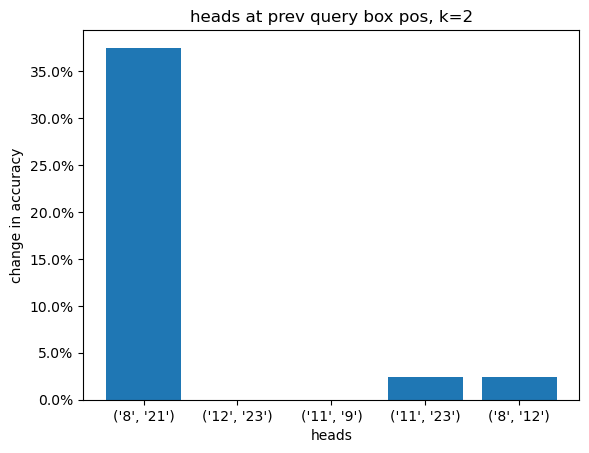

In [38]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

names = []
scores = []

for k in res:
    # new_k = string_to_tuple(k)
    names.append(str((k[0].split(".")[2], str(k[1]))))
    scores.append((res[k][0] / res[k][1] - 1))

plt.bar(names, scores)
plt.title("heads at prev query box pos, k=2")
plt.xlabel("heads")
plt.ylabel("change in accuracy")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

In [39]:
new = {}
for k in res:
    new[str(k)] = res[k]


with open(
    "./post-submission/llama-7b/llama_heads_at_prev_box_pos_res_k_2.json", "w"
) as outfile:
    json.dump(new, outfile)

### llama_head_at_query_box_token

In [63]:
import json

with open(
    "../path_patching/minimality_res/minimality/head_at_query_box_token_new.json", "r"
) as f:
    data = json.load(f)

ranked = defaultdict(list)
for k_1 in data:
    for k_2 in data[k_1]:
        ranked[k_1].append((k_2, data[k_2][k_2] - data[k_1][k_2]))
for k_1 in ranked:
    ranked[k_1].sort(key=(lambda x: x[1]), reverse=True)

In [64]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

res = {}

root_path = "../path_patching/goat_circuits/1404"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_value_fetcher, largest=False
)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_trans, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_detect, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(
    torch.load(path), k=n_struct_read, largest=False
)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)


for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)

for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)


for layer_idx, head in tqdm(head_at_query_box_token):
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"

    print(layer, head)
    for r in ranked[str((layer, head))][: math.ceil(percentage * len(ranked.values()))]:
        top_layer = r[0].split(",")[0][2:-1]
        top_head = int(r[0].split(",")[1][:-1])
        if r[1] <= 0:
            break
        print("remove", top_layer, top_head)
        circuit_components[2][top_layer].remove(top_head)

    befor = eval(model, dataloader, modules, circuit_components, mean_activations)
    circuit_components[2][layer].remove(head)
    after = eval(model, dataloader, modules, circuit_components, mean_activations)
    res[(layer, head)] = (befor, after)

    for r in ranked[str((layer, head))][: math.ceil(percentage * len(ranked.values()))]:
        top_layer = r[0].split(",")[0][2:-1]
        top_head = int(r[0].split(",")[1][:-1])
        if r[1] <= 0:
            break
        circuit_components[2][top_layer].append(top_head)
    circuit_components[2][layer].append(head)

65 10 35 5


  0%|          | 0/35 [00:00<?, ?it/s]

base_model.model.model.layers.13.self_attn.o_proj 14
remove base_model.model.model.layers.9.self_attn.o_proj 7
remove base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.12.self_attn.o_proj 9
remove base_model.model.model.layers.11.self_attn.o_proj 28
remove base_model.model.model.layers.11.self_attn.o_proj 24
remove base_model.model.model.layers.5.self_attn.o_proj 7
remove base_model.model.model.layers.12.self_attn.o_proj 23
remove base_model.model.model.layers.10.self_attn.o_proj 4
remove base_model.model.model.layers.12.self_attn.o_proj 8
remove base_model.model.model.layers.11.self_attn.o_proj 7
remove base_model.model.model.layers.11.self_attn.o_proj 9


100%|██████████| 10/10 [00:51<00:00,  5.12s/it]


Task accuracy: 0.67


  3%|▎         | 1/35 [01:41<57:46, 101.95s/it]

Task accuracy: 0.62
base_model.model.model.layers.10.self_attn.o_proj 3
remove base_model.model.model.layers.9.self_attn.o_proj 2
remove base_model.model.model.layers.7.self_attn.o_proj 17
remove base_model.model.model.layers.9.self_attn.o_proj 10
remove base_model.model.model.layers.9.self_attn.o_proj 7
remove base_model.model.model.layers.11.self_attn.o_proj 24
remove base_model.model.model.layers.1.self_attn.o_proj 9
remove base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.12.self_attn.o_proj 8
remove base_model.model.model.layers.13.self_attn.o_proj 0
remove base_model.model.model.layers.13.self_attn.o_proj 12
remove base_model.model.model.layers.12.self_attn.o_proj 9


100%|██████████| 10/10 [00:51<00:00,  5.18s/it]


Task accuracy: 0.23


  6%|▌         | 2/35 [03:25<56:36, 102.92s/it]

Task accuracy: 0.14
base_model.model.model.layers.9.self_attn.o_proj 2
remove base_model.model.model.layers.10.self_attn.o_proj 3
remove base_model.model.model.layers.9.self_attn.o_proj 7
remove base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.13.self_attn.o_proj 12
remove base_model.model.model.layers.12.self_attn.o_proj 5
remove base_model.model.model.layers.11.self_attn.o_proj 28
remove base_model.model.model.layers.9.self_attn.o_proj 10
remove base_model.model.model.layers.12.self_attn.o_proj 8
remove base_model.model.model.layers.7.self_attn.o_proj 26
remove base_model.model.model.layers.11.self_attn.o_proj 24
remove base_model.model.model.layers.1.self_attn.o_proj 9


100%|██████████| 10/10 [00:52<00:00,  5.20s/it]


Task accuracy: 0.16


  9%|▊         | 3/35 [05:09<55:14, 103.58s/it]

Task accuracy: 0.14
base_model.model.model.layers.9.self_attn.o_proj 7
remove base_model.model.model.layers.9.self_attn.o_proj 10
remove base_model.model.model.layers.7.self_attn.o_proj 17
remove base_model.model.model.layers.13.self_attn.o_proj 14
remove base_model.model.model.layers.10.self_attn.o_proj 3
remove base_model.model.model.layers.9.self_attn.o_proj 2
remove base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.12.self_attn.o_proj 8
remove base_model.model.model.layers.11.self_attn.o_proj 24
remove base_model.model.model.layers.12.self_attn.o_proj 9
remove base_model.model.model.layers.4.self_attn.o_proj 4
remove base_model.model.model.layers.11.self_attn.o_proj 9


100%|██████████| 10/10 [00:52<00:00,  5.21s/it]


Task accuracy: 0.14


 11%|█▏        | 4/35 [06:53<53:26, 103.43s/it]

Task accuracy: 0.14
base_model.model.model.layers.11.self_attn.o_proj 23
remove base_model.model.model.layers.9.self_attn.o_proj 7
remove base_model.model.model.layers.9.self_attn.o_proj 10
remove base_model.model.model.layers.7.self_attn.o_proj 17
remove base_model.model.model.layers.5.self_attn.o_proj 7
remove base_model.model.model.layers.10.self_attn.o_proj 4
remove base_model.model.model.layers.11.self_attn.o_proj 7
remove base_model.model.model.layers.11.self_attn.o_proj 9
remove base_model.model.model.layers.9.self_attn.o_proj 2
remove base_model.model.model.layers.12.self_attn.o_proj 9
remove base_model.model.model.layers.8.self_attn.o_proj 1
remove base_model.model.model.layers.7.self_attn.o_proj 26


100%|██████████| 10/10 [00:52<00:00,  5.22s/it]


Task accuracy: 0.34


 14%|█▍        | 5/35 [08:37<51:51, 103.70s/it]

Task accuracy: 0.27
base_model.model.model.layers.6.self_attn.o_proj 10
remove base_model.model.model.layers.11.self_attn.o_proj 24
remove base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.10.self_attn.o_proj 3
remove base_model.model.model.layers.12.self_attn.o_proj 8
remove base_model.model.model.layers.12.self_attn.o_proj 5
remove base_model.model.model.layers.13.self_attn.o_proj 4
remove base_model.model.model.layers.13.self_attn.o_proj 12
remove base_model.model.model.layers.12.self_attn.o_proj 9
remove base_model.model.model.layers.11.self_attn.o_proj 2
remove base_model.model.model.layers.13.self_attn.o_proj 25
remove base_model.model.model.layers.12.self_attn.o_proj 16


100%|██████████| 10/10 [00:51<00:00,  5.13s/it]


Task accuracy: 0.48


 17%|█▋        | 6/35 [10:20<50:01, 103.50s/it]

Task accuracy: 0.39
base_model.model.model.layers.11.self_attn.o_proj 24
remove base_model.model.model.layers.10.self_attn.o_proj 3
remove base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.9.self_attn.o_proj 7
remove base_model.model.model.layers.6.self_attn.o_proj 10
remove base_model.model.model.layers.12.self_attn.o_proj 9
remove base_model.model.model.layers.12.self_attn.o_proj 5
remove base_model.model.model.layers.13.self_attn.o_proj 14
remove base_model.model.model.layers.9.self_attn.o_proj 2
remove base_model.model.model.layers.9.self_attn.o_proj 10
remove base_model.model.model.layers.1.self_attn.o_proj 9
remove base_model.model.model.layers.5.self_attn.o_proj 7


100%|██████████| 10/10 [00:52<00:00,  5.21s/it]


Task accuracy: 0.14


 20%|██        | 7/35 [12:04<48:25, 103.78s/it]

Task accuracy: 0.14
base_model.model.model.layers.9.self_attn.o_proj 10
remove base_model.model.model.layers.10.self_attn.o_proj 3
remove base_model.model.model.layers.9.self_attn.o_proj 7
remove base_model.model.model.layers.9.self_attn.o_proj 2
remove base_model.model.model.layers.1.self_attn.o_proj 9
remove base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.12.self_attn.o_proj 9
remove base_model.model.model.layers.12.self_attn.o_proj 5
remove base_model.model.model.layers.11.self_attn.o_proj 9
remove base_model.model.model.layers.11.self_attn.o_proj 23
remove base_model.model.model.layers.11.self_attn.o_proj 24
remove base_model.model.model.layers.7.self_attn.o_proj 17


100%|██████████| 10/10 [00:52<00:00,  5.22s/it]


Task accuracy: 0.14


 23%|██▎       | 8/35 [13:49<46:46, 103.94s/it]

Task accuracy: 0.14
base_model.model.model.layers.1.self_attn.o_proj 9
remove base_model.model.model.layers.4.self_attn.o_proj 27
remove base_model.model.model.layers.10.self_attn.o_proj 3
remove base_model.model.model.layers.9.self_attn.o_proj 10
remove base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.9.self_attn.o_proj 29
remove base_model.model.model.layers.9.self_attn.o_proj 2
remove base_model.model.model.layers.11.self_attn.o_proj 24
remove base_model.model.model.layers.5.self_attn.o_proj 7
remove base_model.model.model.layers.12.self_attn.o_proj 9
remove base_model.model.model.layers.10.self_attn.o_proj 4
remove base_model.model.model.layers.4.self_attn.o_proj 4


100%|██████████| 10/10 [00:52<00:00,  5.22s/it]


Task accuracy: 0.17


 26%|██▌       | 9/35 [15:33<45:06, 104.08s/it]

Task accuracy: 0.16
base_model.model.model.layers.7.self_attn.o_proj 17
remove base_model.model.model.layers.10.self_attn.o_proj 3
remove base_model.model.model.layers.7.self_attn.o_proj 26
remove base_model.model.model.layers.9.self_attn.o_proj 7
remove base_model.model.model.layers.10.self_attn.o_proj 4
remove base_model.model.model.layers.4.self_attn.o_proj 4
remove base_model.model.model.layers.11.self_attn.o_proj 23
remove base_model.model.model.layers.9.self_attn.o_proj 10
remove base_model.model.model.layers.5.self_attn.o_proj 7
remove base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.11.self_attn.o_proj 7
remove base_model.model.model.layers.6.self_attn.o_proj 23


100%|██████████| 10/10 [00:51<00:00,  5.20s/it]


Task accuracy: 0.17


 29%|██▊       | 10/35 [17:17<43:19, 103.99s/it]

Task accuracy: 0.14
base_model.model.model.layers.10.self_attn.o_proj 7
remove base_model.model.model.layers.9.self_attn.o_proj 2
remove base_model.model.model.layers.9.self_attn.o_proj 10
remove base_model.model.model.layers.5.self_attn.o_proj 7
remove base_model.model.model.layers.7.self_attn.o_proj 26
remove base_model.model.model.layers.11.self_attn.o_proj 7
remove base_model.model.model.layers.11.self_attn.o_proj 9
remove base_model.model.model.layers.11.self_attn.o_proj 28
remove base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.12.self_attn.o_proj 9
remove base_model.model.model.layers.9.self_attn.o_proj 21
remove base_model.model.model.layers.10.self_attn.o_proj 4


100%|██████████| 10/10 [00:51<00:00,  5.17s/it]


Task accuracy: 0.58


 31%|███▏      | 11/35 [19:00<41:31, 103.83s/it]

Task accuracy: 0.57
base_model.model.model.layers.5.self_attn.o_proj 7
remove base_model.model.model.layers.8.self_attn.o_proj 1
remove base_model.model.model.layers.7.self_attn.o_proj 26
remove base_model.model.model.layers.9.self_attn.o_proj 21
remove base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.11.self_attn.o_proj 9
remove base_model.model.model.layers.11.self_attn.o_proj 28


100%|██████████| 10/10 [00:51<00:00,  5.17s/it]


Task accuracy: 0.56


 34%|███▍      | 12/35 [20:43<39:42, 103.57s/it]

Task accuracy: 0.56
base_model.model.model.layers.13.self_attn.o_proj 0
remove base_model.model.model.layers.10.self_attn.o_proj 3
remove base_model.model.model.layers.12.self_attn.o_proj 9
remove base_model.model.model.layers.9.self_attn.o_proj 2
remove base_model.model.model.layers.9.self_attn.o_proj 7
remove base_model.model.model.layers.11.self_attn.o_proj 24
remove base_model.model.model.layers.5.self_attn.o_proj 7
remove base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.12.self_attn.o_proj 23
remove base_model.model.model.layers.12.self_attn.o_proj 8
remove base_model.model.model.layers.11.self_attn.o_proj 7
remove base_model.model.model.layers.4.self_attn.o_proj 27


100%|██████████| 10/10 [00:51<00:00,  5.13s/it]


Task accuracy: 0.15


 37%|███▋      | 13/35 [22:26<37:55, 103.41s/it]

Task accuracy: 0.15
base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.10.self_attn.o_proj 3
remove base_model.model.model.layers.9.self_attn.o_proj 2
remove base_model.model.model.layers.9.self_attn.o_proj 7
remove base_model.model.model.layers.11.self_attn.o_proj 24
remove base_model.model.model.layers.12.self_attn.o_proj 5
remove base_model.model.model.layers.13.self_attn.o_proj 14
remove base_model.model.model.layers.6.self_attn.o_proj 10
remove base_model.model.model.layers.9.self_attn.o_proj 10
remove base_model.model.model.layers.1.self_attn.o_proj 9
remove base_model.model.model.layers.5.self_attn.o_proj 7
remove base_model.model.model.layers.13.self_attn.o_proj 12


100%|██████████| 10/10 [00:51<00:00,  5.14s/it]


Task accuracy: 0.14


 40%|████      | 14/35 [24:09<36:09, 103.30s/it]

Task accuracy: 0.14
base_model.model.model.layers.13.self_attn.o_proj 12
remove base_model.model.model.layers.9.self_attn.o_proj 2
remove base_model.model.model.layers.10.self_attn.o_proj 3
remove base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.11.self_attn.o_proj 24
remove base_model.model.model.layers.9.self_attn.o_proj 10
remove base_model.model.model.layers.12.self_attn.o_proj 9
remove base_model.model.model.layers.12.self_attn.o_proj 5
remove base_model.model.model.layers.11.self_attn.o_proj 7
remove base_model.model.model.layers.4.self_attn.o_proj 27
remove base_model.model.model.layers.9.self_attn.o_proj 7
remove base_model.model.model.layers.6.self_attn.o_proj 10


100%|██████████| 10/10 [00:51<00:00,  5.16s/it]


Task accuracy: 0.14


 43%|████▎     | 15/35 [25:53<34:27, 103.39s/it]

Task accuracy: 0.14
base_model.model.model.layers.12.self_attn.o_proj 23
remove base_model.model.model.layers.13.self_attn.o_proj 14
remove base_model.model.model.layers.9.self_attn.o_proj 7
remove base_model.model.model.layers.9.self_attn.o_proj 10
remove base_model.model.model.layers.13.self_attn.o_proj 0
remove base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.12.self_attn.o_proj 9
remove base_model.model.model.layers.12.self_attn.o_proj 8
remove base_model.model.model.layers.13.self_attn.o_proj 25
remove base_model.model.model.layers.12.self_attn.o_proj 5
remove base_model.model.model.layers.11.self_attn.o_proj 7
remove base_model.model.model.layers.13.self_attn.o_proj 4


100%|██████████| 10/10 [00:51<00:00,  5.17s/it]


Task accuracy: 0.48


 46%|████▌     | 16/35 [27:36<32:44, 103.41s/it]

Task accuracy: 0.47
base_model.model.model.layers.12.self_attn.o_proj 9
remove base_model.model.model.layers.13.self_attn.o_proj 14
remove base_model.model.model.layers.10.self_attn.o_proj 3
remove base_model.model.model.layers.9.self_attn.o_proj 7
remove base_model.model.model.layers.11.self_attn.o_proj 24
remove base_model.model.model.layers.9.self_attn.o_proj 10
remove base_model.model.model.layers.13.self_attn.o_proj 0
remove base_model.model.model.layers.9.self_attn.o_proj 21
remove base_model.model.model.layers.9.self_attn.o_proj 29
remove base_model.model.model.layers.12.self_attn.o_proj 5
remove base_model.model.model.layers.13.self_attn.o_proj 4
remove base_model.model.model.layers.4.self_attn.o_proj 27


100%|██████████| 10/10 [00:52<00:00,  5.22s/it]


Task accuracy: 0.16


 49%|████▊     | 17/35 [29:20<31:05, 103.64s/it]

Task accuracy: 0.15
base_model.model.model.layers.9.self_attn.o_proj 21
remove base_model.model.model.layers.5.self_attn.o_proj 7
remove base_model.model.model.layers.10.self_attn.o_proj 4
remove base_model.model.model.layers.11.self_attn.o_proj 9
remove base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.12.self_attn.o_proj 9
remove base_model.model.model.layers.9.self_attn.o_proj 7
remove base_model.model.model.layers.9.self_attn.o_proj 10
remove base_model.model.model.layers.11.self_attn.o_proj 7
remove base_model.model.model.layers.6.self_attn.o_proj 23
remove base_model.model.model.layers.10.self_attn.o_proj 7
remove base_model.model.model.layers.12.self_attn.o_proj 23


100%|██████████| 10/10 [00:51<00:00,  5.20s/it]


Task accuracy: 0.63


 51%|█████▏    | 18/35 [31:05<29:25, 103.84s/it]

Task accuracy: 0.47
base_model.model.model.layers.10.self_attn.o_proj 4
remove base_model.model.model.layers.7.self_attn.o_proj 26
remove base_model.model.model.layers.9.self_attn.o_proj 21
remove base_model.model.model.layers.11.self_attn.o_proj 9
remove base_model.model.model.layers.7.self_attn.o_proj 17
remove base_model.model.model.layers.13.self_attn.o_proj 14
remove base_model.model.model.layers.11.self_attn.o_proj 23
remove base_model.model.model.layers.1.self_attn.o_proj 9
remove base_model.model.model.layers.5.self_attn.o_proj 7
remove base_model.model.model.layers.12.self_attn.o_proj 9
remove base_model.model.model.layers.11.self_attn.o_proj 7
remove base_model.model.model.layers.9.self_attn.o_proj 10


100%|██████████| 10/10 [00:51<00:00,  5.18s/it]


Task accuracy: 0.45


 54%|█████▍    | 19/35 [32:48<27:40, 103.76s/it]

Task accuracy: 0.45
base_model.model.model.layers.4.self_attn.o_proj 4
remove base_model.model.model.layers.9.self_attn.o_proj 7
remove base_model.model.model.layers.7.self_attn.o_proj 26
remove base_model.model.model.layers.7.self_attn.o_proj 17
remove base_model.model.model.layers.1.self_attn.o_proj 9
remove base_model.model.model.layers.5.self_attn.o_proj 7
remove base_model.model.model.layers.11.self_attn.o_proj 7
remove base_model.model.model.layers.11.self_attn.o_proj 9
remove base_model.model.model.layers.10.self_attn.o_proj 3
remove base_model.model.model.layers.11.self_attn.o_proj 24
remove base_model.model.model.layers.9.self_attn.o_proj 10
remove base_model.model.model.layers.12.self_attn.o_proj 0


100%|██████████| 10/10 [00:52<00:00,  5.23s/it]


Task accuracy: 0.14


 57%|█████▋    | 20/35 [34:32<25:57, 103.86s/it]

Task accuracy: 0.14
base_model.model.model.layers.12.self_attn.o_proj 8
remove base_model.model.model.layers.10.self_attn.o_proj 3
remove base_model.model.model.layers.9.self_attn.o_proj 7
remove base_model.model.model.layers.9.self_attn.o_proj 2
remove base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.13.self_attn.o_proj 14
remove base_model.model.model.layers.6.self_attn.o_proj 10
remove base_model.model.model.layers.11.self_attn.o_proj 24
remove base_model.model.model.layers.9.self_attn.o_proj 10
remove base_model.model.model.layers.13.self_attn.o_proj 0
remove base_model.model.model.layers.12.self_attn.o_proj 23
remove base_model.model.model.layers.12.self_attn.o_proj 9


100%|██████████| 10/10 [00:51<00:00,  5.10s/it]


Task accuracy: 0.14


 60%|██████    | 21/35 [36:15<24:07, 103.36s/it]

Task accuracy: 0.14
base_model.model.model.layers.8.self_attn.o_proj 1
remove base_model.model.model.layers.5.self_attn.o_proj 7
remove base_model.model.model.layers.7.self_attn.o_proj 26
remove base_model.model.model.layers.12.self_attn.o_proj 9
remove base_model.model.model.layers.11.self_attn.o_proj 7
remove base_model.model.model.layers.11.self_attn.o_proj 9
remove base_model.model.model.layers.7.self_attn.o_proj 17
remove base_model.model.model.layers.9.self_attn.o_proj 7
remove base_model.model.model.layers.11.self_attn.o_proj 23
remove base_model.model.model.layers.9.self_attn.o_proj 10
remove base_model.model.model.layers.13.self_attn.o_proj 0
remove base_model.model.model.layers.12.self_attn.o_proj 0


100%|██████████| 10/10 [00:51<00:00,  5.14s/it]


Task accuracy: 0.48


 63%|██████▎   | 22/35 [37:57<22:21, 103.18s/it]

Task accuracy: 0.42
base_model.model.model.layers.11.self_attn.o_proj 2
remove base_model.model.model.layers.11.self_attn.o_proj 7
remove base_model.model.model.layers.9.self_attn.o_proj 10
remove base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.7.self_attn.o_proj 26
remove base_model.model.model.layers.13.self_attn.o_proj 4
remove base_model.model.model.layers.11.self_attn.o_proj 9
remove base_model.model.model.layers.4.self_attn.o_proj 27


100%|██████████| 10/10 [00:51<00:00,  5.15s/it]


Task accuracy: 0.64


 66%|██████▌   | 23/35 [39:40<20:36, 103.08s/it]

Task accuracy: 0.64
base_model.model.model.layers.13.self_attn.o_proj 25
remove base_model.model.model.layers.10.self_attn.o_proj 3
remove base_model.model.model.layers.9.self_attn.o_proj 7
remove base_model.model.model.layers.5.self_attn.o_proj 7
remove base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.12.self_attn.o_proj 23
remove base_model.model.model.layers.12.self_attn.o_proj 9
remove base_model.model.model.layers.7.self_attn.o_proj 26
remove base_model.model.model.layers.11.self_attn.o_proj 7
remove base_model.model.model.layers.11.self_attn.o_proj 9
remove base_model.model.model.layers.11.self_attn.o_proj 28
remove base_model.model.model.layers.4.self_attn.o_proj 27


100%|██████████| 10/10 [00:50<00:00,  5.07s/it]


Task accuracy: 0.44


 69%|██████▊   | 24/35 [41:22<18:48, 102.58s/it]

Task accuracy: 0.43
base_model.model.model.layers.7.self_attn.o_proj 26
remove base_model.model.model.layers.7.self_attn.o_proj 17
remove base_model.model.model.layers.5.self_attn.o_proj 7
remove base_model.model.model.layers.10.self_attn.o_proj 4
remove base_model.model.model.layers.10.self_attn.o_proj 3
remove base_model.model.model.layers.9.self_attn.o_proj 2
remove base_model.model.model.layers.4.self_attn.o_proj 4
remove base_model.model.model.layers.8.self_attn.o_proj 1
remove base_model.model.model.layers.11.self_attn.o_proj 28


100%|██████████| 10/10 [00:51<00:00,  5.10s/it]


Task accuracy: 0.14


 71%|███████▏  | 25/35 [43:04<17:03, 102.38s/it]

Task accuracy: 0.14
base_model.model.model.layers.9.self_attn.o_proj 29
remove base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.12.self_attn.o_proj 9
remove base_model.model.model.layers.1.self_attn.o_proj 9
remove base_model.model.model.layers.9.self_attn.o_proj 7
remove base_model.model.model.layers.11.self_attn.o_proj 7
remove base_model.model.model.layers.6.self_attn.o_proj 23
remove base_model.model.model.layers.11.self_attn.o_proj 24
remove base_model.model.model.layers.4.self_attn.o_proj 27
remove base_model.model.model.layers.13.self_attn.o_proj 12
remove base_model.model.model.layers.12.self_attn.o_proj 23
remove base_model.model.model.layers.11.self_attn.o_proj 2


100%|██████████| 10/10 [00:50<00:00,  5.06s/it]


Task accuracy: 0.63


 74%|███████▍  | 26/35 [44:45<15:18, 102.10s/it]

Task accuracy: 0.62
base_model.model.model.layers.12.self_attn.o_proj 5
remove base_model.model.model.layers.9.self_attn.o_proj 2
remove base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.11.self_attn.o_proj 24
remove base_model.model.model.layers.9.self_attn.o_proj 10
remove base_model.model.model.layers.12.self_attn.o_proj 9
remove base_model.model.model.layers.10.self_attn.o_proj 3
remove base_model.model.model.layers.9.self_attn.o_proj 7
remove base_model.model.model.layers.6.self_attn.o_proj 10
remove base_model.model.model.layers.1.self_attn.o_proj 9
remove base_model.model.model.layers.5.self_attn.o_proj 7
remove base_model.model.model.layers.13.self_attn.o_proj 12


100%|██████████| 10/10 [00:50<00:00,  5.07s/it]


Task accuracy: 0.14


 77%|███████▋  | 27/35 [46:27<13:35, 101.98s/it]

Task accuracy: 0.14
base_model.model.model.layers.12.self_attn.o_proj 20
remove base_model.model.model.layers.10.self_attn.o_proj 3
remove base_model.model.model.layers.9.self_attn.o_proj 2
remove base_model.model.model.layers.9.self_attn.o_proj 10
remove base_model.model.model.layers.9.self_attn.o_proj 7
remove base_model.model.model.layers.5.self_attn.o_proj 7
remove base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.12.self_attn.o_proj 23
remove base_model.model.model.layers.12.self_attn.o_proj 9
remove base_model.model.model.layers.12.self_attn.o_proj 8
remove base_model.model.model.layers.11.self_attn.o_proj 2
remove base_model.model.model.layers.12.self_attn.o_proj 16


100%|██████████| 10/10 [00:50<00:00,  5.08s/it]


Task accuracy: 0.14


 80%|████████  | 28/35 [48:08<11:53, 101.86s/it]

Task accuracy: 0.14
base_model.model.model.layers.12.self_attn.o_proj 16
remove base_model.model.model.layers.9.self_attn.o_proj 10
remove base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.11.self_attn.o_proj 7
remove base_model.model.model.layers.13.self_attn.o_proj 4


100%|██████████| 10/10 [00:50<00:00,  5.07s/it]


Task accuracy: 0.65


 83%|████████▎ | 29/35 [49:50<10:11, 101.84s/it]

Task accuracy: 0.65
base_model.model.model.layers.11.self_attn.o_proj 7
remove base_model.model.model.layers.11.self_attn.o_proj 2
remove base_model.model.model.layers.4.self_attn.o_proj 27


100%|██████████| 10/10 [00:51<00:00,  5.11s/it]


Task accuracy: 0.69


 86%|████████▌ | 30/35 [51:32<08:29, 101.96s/it]

Task accuracy: 0.69
base_model.model.model.layers.13.self_attn.o_proj 4
remove base_model.model.model.layers.10.self_attn.o_proj 3
remove base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.12.self_attn.o_proj 9
remove base_model.model.model.layers.6.self_attn.o_proj 10
remove base_model.model.model.layers.9.self_attn.o_proj 10
remove base_model.model.model.layers.5.self_attn.o_proj 7
remove base_model.model.model.layers.12.self_attn.o_proj 23
remove base_model.model.model.layers.11.self_attn.o_proj 2
remove base_model.model.model.layers.7.self_attn.o_proj 26
remove base_model.model.model.layers.12.self_attn.o_proj 5
remove base_model.model.model.layers.12.self_attn.o_proj 16


100%|██████████| 10/10 [00:51<00:00,  5.13s/it]


Task accuracy: 0.19


 89%|████████▊ | 31/35 [53:16<06:49, 102.34s/it]

Task accuracy: 0.19
base_model.model.model.layers.6.self_attn.o_proj 23
remove base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.10.self_attn.o_proj 3
remove base_model.model.model.layers.9.self_attn.o_proj 2
remove base_model.model.model.layers.9.self_attn.o_proj 7
remove base_model.model.model.layers.7.self_attn.o_proj 17
remove base_model.model.model.layers.5.self_attn.o_proj 7
remove base_model.model.model.layers.12.self_attn.o_proj 9
remove base_model.model.model.layers.9.self_attn.o_proj 21
remove base_model.model.model.layers.9.self_attn.o_proj 29
remove base_model.model.model.layers.12.self_attn.o_proj 5
remove base_model.model.model.layers.11.self_attn.o_proj 7


100%|██████████| 10/10 [00:52<00:00,  5.22s/it]


Task accuracy: 0.14


 91%|█████████▏| 32/35 [54:59<05:07, 102.64s/it]

Task accuracy: 0.14
base_model.model.model.layers.11.self_attn.o_proj 9
remove base_model.model.model.layers.9.self_attn.o_proj 21
remove base_model.model.model.layers.9.self_attn.o_proj 7
remove base_model.model.model.layers.9.self_attn.o_proj 10
remove base_model.model.model.layers.5.self_attn.o_proj 7
remove base_model.model.model.layers.10.self_attn.o_proj 4


100%|██████████| 10/10 [00:51<00:00,  5.17s/it]


Task accuracy: 0.5


 94%|█████████▍| 33/35 [56:42<03:25, 102.69s/it]

Task accuracy: 0.49
base_model.model.model.layers.11.self_attn.o_proj 28
remove base_model.model.model.layers.9.self_attn.o_proj 2
remove base_model.model.model.layers.13.self_attn.o_proj 14
remove base_model.model.model.layers.5.self_attn.o_proj 7
remove base_model.model.model.layers.7.self_attn.o_proj 26


100%|██████████| 10/10 [00:51<00:00,  5.17s/it]


Task accuracy: 0.66


 97%|█████████▋| 34/35 [58:24<01:42, 102.65s/it]

Task accuracy: 0.66
base_model.model.model.layers.4.self_attn.o_proj 27
remove base_model.model.model.layers.1.self_attn.o_proj 9
remove base_model.model.model.layers.12.self_attn.o_proj 0
remove base_model.model.model.layers.12.self_attn.o_proj 9
remove base_model.model.model.layers.11.self_attn.o_proj 7
remove base_model.model.model.layers.9.self_attn.o_proj 7
remove base_model.model.model.layers.11.self_attn.o_proj 24
remove base_model.model.model.layers.9.self_attn.o_proj 10
remove base_model.model.model.layers.13.self_attn.o_proj 0
remove base_model.model.model.layers.13.self_attn.o_proj 12
remove base_model.model.model.layers.12.self_attn.o_proj 8
remove base_model.model.model.layers.11.self_attn.o_proj 2


100%|██████████| 10/10 [00:51<00:00,  5.18s/it]


Task accuracy: 0.58


100%|██████████| 35/35 [1:00:08<00:00, 103.11s/it]

Task accuracy: 0.51


In [49]:
# with open("llama_head_at_query_box_token_res_k_10.json", "r") as file:
#     res = json.load(file)

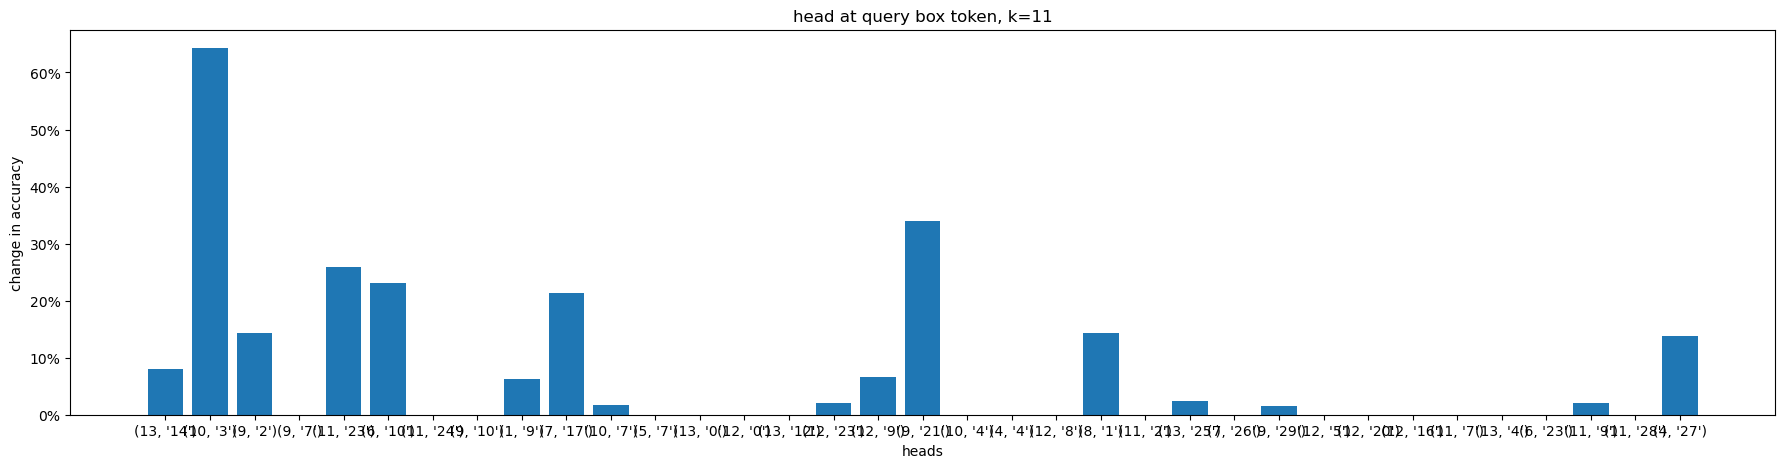

In [67]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

names = []
scores = []

for k in res:
    new_k = string_to_tuple(str(k))
    names.append(str((int(new_k[0].split(".")[4]), new_k[1])))
    scores.append((res[k][0] / res[k][1] - 1))

f, ax = plt.subplots(figsize=(22, 5))
plt.bar(names, scores)
plt.title("head at query box token, k=11")
plt.xlabel("heads")
plt.ylabel("change in accuracy")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

In [68]:
new = {}
for k in res:
    new[str(k)] = res[k]

with open(
    "../path_patching/minimality_res/minimality/llama_head_at_query_box_token_res_k_11_new.json",
    "w",
) as outfile:
    json.dump(new, outfile)

### llama_heads_affecting_direct_logit_heads

In [46]:
import json

with open(
    "./post-submission/llama-7b/heads_affecting_direct_logit_heads.json", "r"
) as f:
    data = json.load(f)

ranked = defaultdict(list)
for k_1 in data:
    for k_2 in data[k_1]:
        ranked[k_1].append((k_2, data[k_2][k_2] - data[k_1][k_2]))
for k_1 in ranked:
    ranked[k_1].sort(key=(lambda x: x[1]), reverse=True)

In [47]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

res = {}

root_path = "../new_pp_exps/post_submission/llama-7b"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_value_fetcher, largest=False
)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_trans, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_detect, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(
    torch.load(path), k=n_struct_read, largest=False
)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)


for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)

for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)


for layer_idx, head in tqdm(heads_affecting_direct_logit_heads):
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    print(layer, head)

    for r in ranked[str((layer, head))][: math.ceil(percentage * len(ranked.values()))]:
        top_layer = r[0].split(",")[0][2:-1]
        top_head = int(r[0].split(",")[1][:-1])
        if r[1] <= 0:
            break
        print("remove", top_layer, top_head)
        circuit_components[0][top_layer].remove(top_head)

    befor = eval(model, dataloader, modules, circuit_components, mean_activations)
    circuit_components[0][layer].remove(head)
    after = eval(model, dataloader, modules, circuit_components, mean_activations)
    res[(layer, head)] = (befor, after)

    for r in ranked[str((layer, head))][: math.ceil(percentage * len(ranked.values()))]:
        top_layer = r[0].split(",")[0][2:-1]
        top_head = int(r[0].split(",")[1][:-1])
        if r[1] <= 0:
            break
        circuit_components[0][top_layer].append(top_head)
    circuit_components[0][layer].append(head)

50 15 30 5



  0%|          | 0/15 [00:00<?, ?it/s]

model.layers.14.self_attn.o_proj 27
remove model.layers.11.self_attn.o_proj 23
remove model.layers.13.self_attn.o_proj 14
remove model.layers.12.self_attn.o_proj 23
remove model.layers.17.self_attn.o_proj 26
remove model.layers.14.self_attn.o_proj 0



100%|██████████| 10/10 [01:04<00:00,  6.41s/it]


Task accuracy: 0.53



  7%|▋         | 1/15 [02:07<29:51, 127.98s/it]

Task accuracy: 0.15
model.layers.11.self_attn.o_proj 23
remove model.layers.14.self_attn.o_proj 27
remove model.layers.12.self_attn.o_proj 23
remove model.layers.11.self_attn.o_proj 26
remove model.layers.17.self_attn.o_proj 26
remove model.layers.19.self_attn.o_proj 12



100%|██████████| 10/10 [01:03<00:00,  6.34s/it]


Task accuracy: 0.4



 13%|█▎        | 2/15 [04:15<27:39, 127.69s/it]

Task accuracy: 0.15
model.layers.12.self_attn.o_proj 23
remove model.layers.14.self_attn.o_proj 27
remove model.layers.13.self_attn.o_proj 14
remove model.layers.19.self_attn.o_proj 12
remove model.layers.11.self_attn.o_proj 26
remove model.layers.10.self_attn.o_proj 6



100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


Task accuracy: 0.42



 20%|██        | 3/15 [06:21<25:25, 127.10s/it]

Task accuracy: 0.28
model.layers.19.self_attn.o_proj 12
remove model.layers.14.self_attn.o_proj 27
remove model.layers.12.self_attn.o_proj 23



100%|██████████| 10/10 [01:03<00:00,  6.38s/it]


Task accuracy: 0.42



 27%|██▋       | 4/15 [08:29<23:21, 127.40s/it]

Task accuracy: 0.39
model.layers.13.self_attn.o_proj 0
remove model.layers.14.self_attn.o_proj 27
remove model.layers.19.self_attn.o_proj 12
remove model.layers.16.self_attn.o_proj 2
remove model.layers.11.self_attn.o_proj 26
remove model.layers.14.self_attn.o_proj 0



100%|██████████| 10/10 [01:04<00:00,  6.42s/it]


Task accuracy: 0.42



 33%|███▎      | 5/15 [10:38<21:17, 127.77s/it]

Task accuracy: 0.36
model.layers.16.self_attn.o_proj 2
remove model.layers.14.self_attn.o_proj 27
remove model.layers.12.self_attn.o_proj 23
remove model.layers.13.self_attn.o_proj 0
remove model.layers.17.self_attn.o_proj 26
remove model.layers.13.self_attn.o_proj 14



100%|██████████| 10/10 [01:04<00:00,  6.41s/it]


Task accuracy: 0.29



 40%|████      | 6/15 [12:46<19:11, 127.92s/it]

Task accuracy: 0.27
model.layers.13.self_attn.o_proj 1
remove model.layers.14.self_attn.o_proj 27
remove model.layers.12.self_attn.o_proj 23
remove model.layers.19.self_attn.o_proj 12
remove model.layers.16.self_attn.o_proj 2
remove model.layers.11.self_attn.o_proj 26



100%|██████████| 10/10 [01:04<00:00,  6.41s/it]


Task accuracy: 0.39



 47%|████▋     | 7/15 [14:54<17:04, 128.02s/it]

Task accuracy: 0.38
model.layers.11.self_attn.o_proj 26
remove model.layers.17.self_attn.o_proj 26
remove model.layers.14.self_attn.o_proj 27
remove model.layers.12.self_attn.o_proj 23



100%|██████████| 10/10 [01:04<00:00,  6.43s/it]


Task accuracy: 0.41



 53%|█████▎    | 8/15 [17:03<14:57, 128.17s/it]

Task accuracy: 0.4
model.layers.13.self_attn.o_proj 14
remove model.layers.14.self_attn.o_proj 27
remove model.layers.12.self_attn.o_proj 23



100%|██████████| 10/10 [01:04<00:00,  6.41s/it]


Task accuracy: 0.42



 60%|██████    | 9/15 [19:11<12:49, 128.18s/it]

Task accuracy: 0.35
model.layers.16.self_attn.o_proj 16
remove model.layers.12.self_attn.o_proj 23



100%|██████████| 10/10 [01:04<00:00,  6.41s/it]


Task accuracy: 0.57



 67%|██████▋   | 10/15 [21:19<10:41, 128.23s/it]

Task accuracy: 0.57
model.layers.14.self_attn.o_proj 0
remove model.layers.14.self_attn.o_proj 27



100%|██████████| 10/10 [01:04<00:00,  6.42s/it]


Task accuracy: 0.48



 73%|███████▎  | 11/15 [23:27<08:33, 128.27s/it]

Task accuracy: 0.46
model.layers.14.self_attn.o_proj 13
remove model.layers.14.self_attn.o_proj 27
remove model.layers.11.self_attn.o_proj 26



100%|██████████| 10/10 [01:03<00:00,  6.38s/it]


Task accuracy: 0.48



 80%|████████  | 12/15 [25:35<06:24, 128.15s/it]

Task accuracy: 0.46
model.layers.10.self_attn.o_proj 6
remove model.layers.12.self_attn.o_proj 23
remove model.layers.14.self_attn.o_proj 27



100%|██████████| 10/10 [01:04<00:00,  6.42s/it]


Task accuracy: 0.42



 87%|████████▋ | 13/15 [27:44<04:16, 128.22s/it]

Task accuracy: 0.37
model.layers.17.self_attn.o_proj 26
remove model.layers.14.self_attn.o_proj 27



100%|██████████| 10/10 [01:04<00:00,  6.42s/it]


Task accuracy: 0.48



 93%|█████████▎| 14/15 [29:51<02:07, 127.89s/it]

Task accuracy: 0.46
model.layers.12.self_attn.o_proj 0
remove model.layers.14.self_attn.o_proj 27
remove model.layers.12.self_attn.o_proj 23



100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


Task accuracy: 0.42



100%|██████████| 15/15 [31:57<00:00, 127.80s/it]

Task accuracy: 0.4


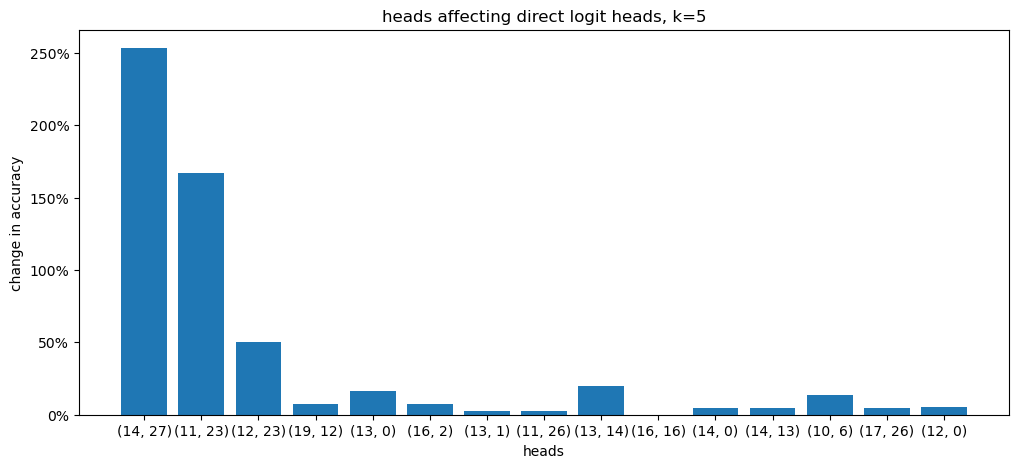

In [49]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

# with open('llama_heads_affecting_direct_logit_heads_res_k_5.json', 'r') as f:
#   res = json.load(f)

names = []
scores = []

for k in res:
    new_k = str(k)
    names.append(str((int(new_k.split(".")[2]), int(new_k.split(",")[1][1:-1]))))
    scores.append((res[k][0] / res[k][1] - 1))

f, ax = plt.subplots(figsize=(12, 5))
plt.bar(names, scores)
plt.title("heads affecting direct logit heads, k=5")
plt.xlabel("heads")
plt.ylabel("change in accuracy")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

In [50]:
new = {}
for k in res:
    new[str(k)] = res[k]

with open(
    "./post-submission/llama-7b/llama_heads_affecting_direct_logit_heads_res_k_5.json",
    "w",
) as outfile:
    json.dump(new, outfile)

### llama_direct_logit_heads

In [23]:
import json

with open(
    "../path_patching/minimality_res/minimality_large/direct_logit_heads.json", "r"
) as f:
    data = json.load(f)

ranked = defaultdict(list)
for k_1 in data:
    for k_2 in data[k_1]:
        ranked[k_1].append((k_2, data[k_2][k_2] - data[k_1][k_2]))
for k_1 in ranked:
    ranked[k_1].sort(key=(lambda x: x[1]), reverse=True)

In [24]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

res = {}

root_path = "../path_patching/goat_circuits/1404"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_value_fetcher, largest=False
)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_trans, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_detect, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(
    torch.load(path), k=n_struct_read, largest=False
)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)


for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)

for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)


for layer_idx, head in tqdm(direct_logit_heads):
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"

    print(layer, head)
    for r in ranked[str((layer, head))][: math.ceil(percentage * len(ranked.values()))]:
        top_layer = r[0].split(",")[0][2:-1]
        top_head = int(r[0].split(",")[1][:-1])
        if r[1] <= 0:
            break
        print("remove", top_layer, top_head)
        circuit_components[0][top_layer].remove(top_head)

    befor = eval(model, dataloader, modules, circuit_components, mean_activations)
    circuit_components[0][layer].remove(head)
    after = eval(model, dataloader, modules, circuit_components, mean_activations)
    res[(layer, head)] = (befor, after)

    for r in ranked[str((layer, head))][: math.ceil(percentage * len(ranked.values()))]:
        top_layer = r[0].split(",")[0][2:-1]
        top_head = int(r[0].split(",")[1][:-1])
        if r[1] <= 0:
            break
        circuit_components[0][top_layer].append(top_head)
    circuit_components[0][layer].append(head)

70 15 35 10


  0%|          | 0/70 [00:00<?, ?it/s]

base_model.model.model.layers.24.self_attn.o_proj 5
remove base_model.model.model.layers.18.self_attn.o_proj 20
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.20.self_attn.o_proj 29
remove base_model.model.model.layers.23.self_attn.o_proj 5
remove base_model.model.model.layers.19.self_attn.o_proj 20
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.15.self_attn.o_proj 2
remove base_model.model.model.layers.21.self_attn.o_proj 11
remove base_model.model.model.layers.13.self_attn.o_proj 3
remove base_model.model.model.layers.15.self_attn.o_proj 17
remove base_model.model.model.layers.17.self_attn.o_proj 24


100%|██████████| 2/2 [00:09<00:00,  4.79s/it]


Task accuracy: 0.75


  1%|▏         | 1/70 [00:19<21:55, 19.07s/it]

Task accuracy: 0.67
base_model.model.model.layers.21.self_attn.o_proj 3
remove base_model.model.model.layers.19.self_attn.o_proj 12
remove base_model.model.model.layers.23.self_attn.o_proj 15
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.24.self_attn.o_proj 8
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.15.self_attn.o_proj 31
remove base_model.model.model.layers.15.self_attn.o_proj 2
remove base_model.model.model.layers.21.self_attn.o_proj 11
remove base_model.model.model.layers.13.self_attn.o_proj 3
remove base_model.model.model.layers.21.self_attn.o_proj 23
remove base_model.model.model.layers.17.self_attn.o_proj 24
remove base_model.model.model.layers.18.self_attn.o_proj 21


100%|██████████| 2/2 [00:09<00:00,  4.77s/it]


Task accuracy: 0.75


  3%|▎         | 2/70 [00:38<21:45, 19.19s/it]

Task accuracy: 0.73
base_model.model.model.layers.19.self_attn.o_proj 12
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.15.self_attn.o_proj 2
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.21.self_attn.o_proj 3
remove base_model.model.model.layers.19.self_attn.o_proj 30
remove base_model.model.model.layers.29.self_attn.o_proj 7
remove base_model.model.model.layers.17.self_attn.o_proj 8
remove base_model.model.model.layers.24.self_attn.o_proj 8
remove base_model.model.model.layers.18.self_attn.o_proj 20
remove base_model.model.model.layers.28.self_attn.o_proj 16
remove base_model.model.model.layers.14.self_attn.o_proj 11
remove base_model.model.model.layers.31.self_attn.o_proj 26
remove base_model.model.model.layers.31.self_attn.o_proj 25


100%|██████████| 2/2 [00:09<00:00,  4.82s/it]


Task accuracy: 0.68


  4%|▍         | 3/70 [00:57<21:29, 19.25s/it]

Task accuracy: 0.71
base_model.model.model.layers.18.self_attn.o_proj 8
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.13.self_attn.o_proj 3
remove base_model.model.model.layers.17.self_attn.o_proj 5
remove base_model.model.model.layers.19.self_attn.o_proj 30
remove base_model.model.model.layers.23.self_attn.o_proj 15
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.17.self_attn.o_proj 8
remove base_model.model.model.layers.31.self_attn.o_proj 6
remove base_model.model.model.layers.30.self_attn.o_proj 8
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.31.self_attn.o_proj 29
remove base_model.model.model.layers.31.self_attn.o_proj 1


100%|██████████| 2/2 [00:09<00:00,  4.86s/it]


Task accuracy: 0.71


  6%|▌         | 4/70 [01:17<21:15, 19.32s/it]

Task accuracy: 0.72
base_model.model.model.layers.21.self_attn.o_proj 4
remove base_model.model.model.layers.14.self_attn.o_proj 11
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.15.self_attn.o_proj 31
remove base_model.model.model.layers.19.self_attn.o_proj 25
remove base_model.model.model.layers.17.self_attn.o_proj 5
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.21.self_attn.o_proj 11
remove base_model.model.model.layers.13.self_attn.o_proj 3
remove base_model.model.model.layers.18.self_attn.o_proj 21
remove base_model.model.model.layers.23.self_attn.o_proj 15
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.18.self_attn.o_proj 20
remove base_model.model.model.layers.19.self_attn.o_proj 20


100%|██████████| 2/2 [00:09<00:00,  4.88s/it]


Task accuracy: 0.75


  7%|▋         | 5/70 [01:36<21:00, 19.40s/it]

Task accuracy: 0.71
base_model.model.model.layers.20.self_attn.o_proj 14
remove base_model.model.model.layers.18.self_attn.o_proj 20
remove base_model.model.model.layers.19.self_attn.o_proj 26
remove base_model.model.model.layers.19.self_attn.o_proj 25
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 11
remove base_model.model.model.layers.13.self_attn.o_proj 3
remove base_model.model.model.layers.18.self_attn.o_proj 21
remove base_model.model.model.layers.24.self_attn.o_proj 5
remove base_model.model.model.layers.18.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 23
remove base_model.model.model.layers.30.self_attn.o_proj 4
remove base_model.model.model.layers.23.self_attn.o_proj 15


100%|██████████| 2/2 [00:09<00:00,  4.89s/it]


Task accuracy: 0.72


  9%|▊         | 6/70 [01:56<20:42, 19.42s/it]

Task accuracy: 0.66
base_model.model.model.layers.23.self_attn.o_proj 5
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.13.self_attn.o_proj 3


100%|██████████| 2/2 [00:09<00:00,  4.82s/it]


Task accuracy: 0.74


 10%|█         | 7/70 [02:15<20:19, 19.35s/it]

Task accuracy: 0.75
base_model.model.model.layers.30.self_attn.o_proj 4
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.19.self_attn.o_proj 30
remove base_model.model.model.layers.29.self_attn.o_proj 7
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.19.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 11
remove base_model.model.model.layers.13.self_attn.o_proj 3
remove base_model.model.model.layers.18.self_attn.o_proj 21


100%|██████████| 2/2 [00:09<00:00,  4.81s/it]


Task accuracy: 0.73


 11%|█▏        | 8/70 [02:34<19:58, 19.33s/it]

Task accuracy: 0.73
base_model.model.model.layers.19.self_attn.o_proj 30
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.19.self_attn.o_proj 12
remove base_model.model.model.layers.30.self_attn.o_proj 4
remove base_model.model.model.layers.17.self_attn.o_proj 8
remove base_model.model.model.layers.24.self_attn.o_proj 8
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.28.self_attn.o_proj 16
remove base_model.model.model.layers.19.self_attn.o_proj 11
remove base_model.model.model.layers.19.self_attn.o_proj 20
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.15.self_attn.o_proj 31


100%|██████████| 2/2 [00:09<00:00,  4.83s/it]


Task accuracy: 0.69


 13%|█▎        | 9/70 [02:53<19:38, 19.32s/it]

Task accuracy: 0.68
base_model.model.model.layers.15.self_attn.o_proj 5
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.29.self_attn.o_proj 7
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.19.self_attn.o_proj 20
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.16.self_attn.o_proj 23
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.19.self_attn.o_proj 25
remove base_model.model.model.layers.13.self_attn.o_proj 3
remove base_model.model.model.layers.15.self_attn.o_proj 17
remove base_model.model.model.layers.18.self_attn.o_proj 21
remove base_model.model.model.layers.30.self_attn.o_proj 4
remove base_model.model.model.layers.23.self_attn.o_proj 17


100%|██████████| 2/2 [00:09<00:00,  4.85s/it]


Task accuracy: 0.72


 14%|█▍        | 10/70 [03:13<19:21, 19.36s/it]

Task accuracy: 0.73
base_model.model.model.layers.23.self_attn.o_proj 15
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.21.self_attn.o_proj 3
remove base_model.model.model.layers.29.self_attn.o_proj 7
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.24.self_attn.o_proj 8
remove base_model.model.model.layers.30.self_attn.o_proj 8
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.28.self_attn.o_proj 16
remove base_model.model.model.layers.19.self_attn.o_proj 8
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.16.self_attn.o_proj 23
remove base_model.model.model.layers.24.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.87s/it]


Task accuracy: 0.71


 16%|█▌        | 11/70 [03:32<19:04, 19.40s/it]

Task accuracy: 0.7
base_model.model.model.layers.29.self_attn.o_proj 7
remove base_model.model.model.layers.15.self_attn.o_proj 31
remove base_model.model.model.layers.18.self_attn.o_proj 20
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.15.self_attn.o_proj 2
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.19.self_attn.o_proj 25
remove base_model.model.model.layers.18.self_attn.o_proj 21
remove base_model.model.model.layers.19.self_attn.o_proj 12
remove base_model.model.model.layers.30.self_attn.o_proj 4
remove base_model.model.model.layers.15.self_attn.o_proj 5
remove base_model.model.model.layers.23.self_attn.o_proj 15
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.17.self_attn.o_proj 8
remove base_model.model.model.layers.24.self_attn.o_proj 8


100%|██████████| 2/2 [00:09<00:00,  4.89s/it]


Task accuracy: 0.75


 17%|█▋        | 12/70 [03:52<18:47, 19.44s/it]

Task accuracy: 0.75
base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.19.self_attn.o_proj 30
remove base_model.model.model.layers.15.self_attn.o_proj 31
remove base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.19.self_attn.o_proj 12
remove base_model.model.model.layers.23.self_attn.o_proj 5
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.16.self_attn.o_proj 23
remove base_model.model.model.layers.20.self_attn.o_proj 29


100%|██████████| 2/2 [00:09<00:00,  4.94s/it]


Task accuracy: 0.75


 19%|█▊        | 13/70 [04:12<18:32, 19.51s/it]

Task accuracy: 0.72
base_model.model.model.layers.17.self_attn.o_proj 8
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.19.self_attn.o_proj 25
remove base_model.model.model.layers.19.self_attn.o_proj 12
remove base_model.model.model.layers.19.self_attn.o_proj 30
remove base_model.model.model.layers.29.self_attn.o_proj 7
remove base_model.model.model.layers.23.self_attn.o_proj 30
remove base_model.model.model.layers.23.self_attn.o_proj 16
remove base_model.model.model.layers.14.self_attn.o_proj 11
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.13.self_attn.o_proj 9
remove base_model.model.model.layers.15.self_attn.o_proj 12
remove base_model.model.model.layers.15.self_attn.o_proj 31
remove base_model.model.model.layers.20.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.86s/it]


Task accuracy: 0.68


 20%|██        | 14/70 [04:31<18:11, 19.49s/it]

Task accuracy: 0.68
base_model.model.model.layers.31.self_attn.o_proj 6
remove base_model.model.model.layers.30.self_attn.o_proj 8


100%|██████████| 2/2 [00:09<00:00,  4.87s/it]


Task accuracy: 0.75


 21%|██▏       | 15/70 [04:50<17:51, 19.48s/it]

Task accuracy: 0.74
base_model.model.model.layers.23.self_attn.o_proj 30
remove base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.17.self_attn.o_proj 8
remove base_model.model.model.layers.28.self_attn.o_proj 16
remove base_model.model.model.layers.31.self_attn.o_proj 23
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.19.self_attn.o_proj 16
remove base_model.model.model.layers.15.self_attn.o_proj 12
remove base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.16.self_attn.o_proj 23
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.31.self_attn.o_proj 14
remove base_model.model.model.layers.21.self_attn.o_proj 11
remove base_model.model.model.layers.13.self_attn.o_proj 3


100%|██████████| 2/2 [00:09<00:00,  4.89s/it]


Task accuracy: 0.71


 23%|██▎       | 16/70 [05:10<17:33, 19.51s/it]

Task accuracy: 0.7
base_model.model.model.layers.24.self_attn.o_proj 8
remove base_model.model.model.layers.15.self_attn.o_proj 31
remove base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.21.self_attn.o_proj 3
remove base_model.model.model.layers.19.self_attn.o_proj 12
remove base_model.model.model.layers.19.self_attn.o_proj 30
remove base_model.model.model.layers.23.self_attn.o_proj 15
remove base_model.model.model.layers.29.self_attn.o_proj 7
remove base_model.model.model.layers.15.self_attn.o_proj 1
remove base_model.model.model.layers.28.self_attn.o_proj 16
remove base_model.model.model.layers.14.self_attn.o_proj 11
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.24.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.84s/it]


Task accuracy: 0.71


 24%|██▍       | 17/70 [05:29<17:10, 19.45s/it]

Task accuracy: 0.71
base_model.model.model.layers.30.self_attn.o_proj 8
remove base_model.model.model.layers.19.self_attn.o_proj 23
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.23.self_attn.o_proj 15
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.31.self_attn.o_proj 6
remove base_model.model.model.layers.28.self_attn.o_proj 16
remove base_model.model.model.layers.14.self_attn.o_proj 11
remove base_model.model.model.layers.31.self_attn.o_proj 26
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.31.self_attn.o_proj 23
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.19.self_attn.o_proj 16
remove base_model.model.model.layers.13.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.80s/it]


Task accuracy: 0.72


 26%|██▌       | 18/70 [05:49<16:48, 19.40s/it]

Task accuracy: 0.72
base_model.model.model.layers.28.self_attn.o_proj 17
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.13.self_attn.o_proj 3
remove base_model.model.model.layers.19.self_attn.o_proj 12
remove base_model.model.model.layers.30.self_attn.o_proj 4
remove base_model.model.model.layers.23.self_attn.o_proj 15
remove base_model.model.model.layers.17.self_attn.o_proj 8
remove base_model.model.model.layers.31.self_attn.o_proj 6
remove base_model.model.model.layers.23.self_attn.o_proj 30
remove base_model.model.model.layers.24.self_attn.o_proj 8
remove base_model.model.model.layers.30.self_attn.o_proj 8
remove base_model.model.model.layers.28.self_attn.o_proj 16
remove base_model.model.model.layers.31.self_attn.o_proj 29
remove base_model.model.model.layers.31.self_attn.o_proj 1


100%|██████████| 2/2 [00:09<00:00,  4.87s/it]


Task accuracy: 0.72


 27%|██▋       | 19/70 [06:08<16:30, 19.42s/it]

Task accuracy: 0.71
base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.19.self_attn.o_proj 12
remove base_model.model.model.layers.17.self_attn.o_proj 8
remove base_model.model.model.layers.18.self_attn.o_proj 20
remove base_model.model.model.layers.15.self_attn.o_proj 2
remove base_model.model.model.layers.17.self_attn.o_proj 24
remove base_model.model.model.layers.18.self_attn.o_proj 21
remove base_model.model.model.layers.17.self_attn.o_proj 5
remove base_model.model.model.layers.23.self_attn.o_proj 5
remove base_model.model.model.layers.30.self_attn.o_proj 4
remove base_model.model.model.layers.14.self_attn.o_proj 11
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.19.self_attn.o_proj 16
remove base_model.model.model.layers.15.self_attn.o_proj 6


100%|██████████| 2/2 [00:09<00:00,  4.86s/it]


Task accuracy: 0.76


 29%|██▊       | 20/70 [06:28<16:11, 19.43s/it]

Task accuracy: 0.77
base_model.model.model.layers.18.self_attn.o_proj 20
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.15.self_attn.o_proj 31
remove base_model.model.model.layers.17.self_attn.o_proj 5
remove base_model.model.model.layers.24.self_attn.o_proj 5
remove base_model.model.model.layers.29.self_attn.o_proj 7
remove base_model.model.model.layers.14.self_attn.o_proj 11
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.20.self_attn.o_proj 14
remove base_model.model.model.layers.19.self_attn.o_proj 12
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.19.self_attn.o_proj 11
remove base_model.model.model.layers.31.self_attn.o_proj 25


100%|██████████| 2/2 [00:09<00:00,  4.87s/it]


Task accuracy: 0.69


 30%|███       | 21/70 [06:47<15:52, 19.45s/it]

Task accuracy: 0.67
base_model.model.model.layers.15.self_attn.o_proj 1
remove base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.23.self_attn.o_proj 5
remove base_model.model.model.layers.24.self_attn.o_proj 8
remove base_model.model.model.layers.19.self_attn.o_proj 11
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.19.self_attn.o_proj 26
remove base_model.model.model.layers.15.self_attn.o_proj 31
remove base_model.model.model.layers.24.self_attn.o_proj 0
remove base_model.model.model.layers.23.self_attn.o_proj 27
remove base_model.model.model.layers.13.self_attn.o_proj 3
remove base_model.model.model.layers.15.self_attn.o_proj 17


100%|██████████| 2/2 [00:09<00:00,  4.88s/it]


Task accuracy: 0.72


 31%|███▏      | 22/70 [07:06<15:32, 19.43s/it]

Task accuracy: 0.71
base_model.model.model.layers.28.self_attn.o_proj 16
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.16.self_attn.o_proj 23
remove base_model.model.model.layers.19.self_attn.o_proj 12
remove base_model.model.model.layers.23.self_attn.o_proj 5
remove base_model.model.model.layers.19.self_attn.o_proj 30
remove base_model.model.model.layers.23.self_attn.o_proj 15
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.23.self_attn.o_proj 30
remove base_model.model.model.layers.24.self_attn.o_proj 8
remove base_model.model.model.layers.30.self_attn.o_proj 8
remove base_model.model.model.layers.19.self_attn.o_proj 20
remove base_model.model.model.layers.31.self_attn.o_proj 25


100%|██████████| 2/2 [00:09<00:00,  4.80s/it]


Task accuracy: 0.71


 33%|███▎      | 23/70 [07:26<15:10, 19.38s/it]

Task accuracy: 0.71
base_model.model.model.layers.31.self_attn.o_proj 29
remove base_model.model.model.layers.13.self_attn.o_proj 9
remove base_model.model.model.layers.21.self_attn.o_proj 11
remove base_model.model.model.layers.18.self_attn.o_proj 21


100%|██████████| 2/2 [00:09<00:00,  4.78s/it]


Task accuracy: 0.72


 34%|███▍      | 24/70 [07:45<14:47, 19.30s/it]

Task accuracy: 0.72
base_model.model.model.layers.31.self_attn.o_proj 1
remove base_model.model.model.layers.19.self_attn.o_proj 23
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.19.self_attn.o_proj 25
remove base_model.model.model.layers.15.self_attn.o_proj 17


100%|██████████| 2/2 [00:09<00:00,  4.79s/it]


Task accuracy: 0.75


 36%|███▌      | 25/70 [08:04<14:26, 19.25s/it]

Task accuracy: 0.74
base_model.model.model.layers.23.self_attn.o_proj 16
remove base_model.model.model.layers.19.self_attn.o_proj 25
remove base_model.model.model.layers.17.self_attn.o_proj 8
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.31.self_attn.o_proj 23
remove base_model.model.model.layers.19.self_attn.o_proj 20
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.16.self_attn.o_proj 23
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.31.self_attn.o_proj 14
remove base_model.model.model.layers.21.self_attn.o_proj 11
remove base_model.model.model.layers.13.self_attn.o_proj 3
remove base_model.model.model.layers.18.self_attn.o_proj 21


100%|██████████| 2/2 [00:09<00:00,  4.80s/it]


Task accuracy: 0.73


 37%|███▋      | 26/70 [08:23<14:08, 19.27s/it]

Task accuracy: 0.68
base_model.model.model.layers.14.self_attn.o_proj 11
remove base_model.model.model.layers.21.self_attn.o_proj 4
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.18.self_attn.o_proj 20
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.19.self_attn.o_proj 20
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.15.self_attn.o_proj 31
remove base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.15.self_attn.o_proj 2
remove base_model.model.model.layers.18.self_attn.o_proj 21
remove base_model.model.model.layers.19.self_attn.o_proj 12
remove base_model.model.model.layers.29.self_attn.o_proj 7
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.17.self_attn.o_proj 8


100%|██████████| 2/2 [00:09<00:00,  4.87s/it]


Task accuracy: 0.69


 39%|███▊      | 27/70 [08:43<13:51, 19.33s/it]

Task accuracy: 0.65
base_model.model.model.layers.19.self_attn.o_proj 8
remove base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.23.self_attn.o_proj 15
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.19.self_attn.o_proj 2
remove base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.19.self_attn.o_proj 23
remove base_model.model.model.layers.13.self_attn.o_proj 3
remove base_model.model.model.layers.15.self_attn.o_proj 17
remove base_model.model.model.layers.18.self_attn.o_proj 21
remove base_model.model.model.layers.19.self_attn.o_proj 12
remove base_model.model.model.layers.23.self_attn.o_proj 5
remove base_model.model.model.layers.30.self_attn.o_proj 4
remove base_model.model.model.layers.19.self_attn.o_proj 30
remove base_model.model.model.layers.23.self_attn.o_proj 17


100%|██████████| 2/2 [00:09<00:00,  4.88s/it]


Task accuracy: 0.71


 40%|████      | 28/70 [09:02<13:35, 19.41s/it]

Task accuracy: 0.69
base_model.model.model.layers.19.self_attn.o_proj 11
remove base_model.model.model.layers.19.self_attn.o_proj 30
remove base_model.model.model.layers.18.self_attn.o_proj 20
remove base_model.model.model.layers.15.self_attn.o_proj 1
remove base_model.model.model.layers.19.self_attn.o_proj 20
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.21.self_attn.o_proj 11
remove base_model.model.model.layers.13.self_attn.o_proj 3
remove base_model.model.model.layers.18.self_attn.o_proj 21
remove base_model.model.model.layers.24.self_attn.o_proj 5
remove base_model.model.model.layers.23.self_attn.o_proj 19
remove base_model.model.model.layers.18.self_attn.o_proj 25
remove base_model.model.model.layers.30.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.91s/it]


Task accuracy: 0.69


 41%|████▏     | 29/70 [09:22<13:18, 19.47s/it]

Task accuracy: 0.65
base_model.model.model.layers.31.self_attn.o_proj 26
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.19.self_attn.o_proj 12
remove base_model.model.model.layers.30.self_attn.o_proj 8
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.14.self_attn.o_proj 11
remove base_model.model.model.layers.13.self_attn.o_proj 9
remove base_model.model.model.layers.15.self_attn.o_proj 31
remove base_model.model.model.layers.19.self_attn.o_proj 25


100%|██████████| 2/2 [00:09<00:00,  4.88s/it]


Task accuracy: 0.75


 43%|████▎     | 30/70 [09:42<13:00, 19.51s/it]

Task accuracy: 0.75
base_model.model.model.layers.16.self_attn.o_proj 28
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.21.self_attn.o_proj 11
remove base_model.model.model.layers.23.self_attn.o_proj 27
remove base_model.model.model.layers.13.self_attn.o_proj 3
remove base_model.model.model.layers.18.self_attn.o_proj 21
remove base_model.model.model.layers.24.self_attn.o_proj 5
remove base_model.model.model.layers.30.self_attn.o_proj 4
remove base_model.model.model.layers.19.self_attn.o_proj 30
remove base_model.model.model.layers.17.self_attn.o_proj 8
remove base_model.model.model.layers.31.self_attn.o_proj 6
remove base_model.model.model.layers.24.self_attn.o_proj 8


100%|██████████| 2/2 [00:09<00:00,  4.89s/it]


Task accuracy: 0.72


 44%|████▍     | 31/70 [10:01<12:41, 19.53s/it]

Task accuracy: 0.7
base_model.model.model.layers.21.self_attn.o_proj 26


100%|██████████| 2/2 [00:09<00:00,  4.90s/it]


Task accuracy: 0.75


 46%|████▌     | 32/70 [10:21<12:22, 19.55s/it]

Task accuracy: 0.78
base_model.model.model.layers.31.self_attn.o_proj 23
remove base_model.model.model.layers.15.self_attn.o_proj 17
remove base_model.model.model.layers.23.self_attn.o_proj 5
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.23.self_attn.o_proj 30
remove base_model.model.model.layers.30.self_attn.o_proj 8
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.23.self_attn.o_proj 16
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.19.self_attn.o_proj 16
remove base_model.model.model.layers.15.self_attn.o_proj 12
remove base_model.model.model.layers.19.self_attn.o_proj 26
remove base_model.model.model.layers.15.self_attn.o_proj 31
remove base_model.model.model.layers.24.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.90s/it]


Task accuracy: 0.76


 47%|████▋     | 33/70 [10:40<12:04, 19.57s/it]

Task accuracy: 0.76
base_model.model.model.layers.19.self_attn.o_proj 20
remove base_model.model.model.layers.15.self_attn.o_proj 31
remove base_model.model.model.layers.14.self_attn.o_proj 11
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.15.self_attn.o_proj 12
remove base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.15.self_attn.o_proj 2
remove base_model.model.model.layers.19.self_attn.o_proj 25
remove base_model.model.model.layers.17.self_attn.o_proj 5
remove base_model.model.model.layers.24.self_attn.o_proj 5
remove base_model.model.model.layers.19.self_attn.o_proj 30
remove base_model.model.model.layers.15.self_attn.o_proj 5
remove base_model.model.model.layers.29.self_attn.o_proj 7
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.13.self_attn.o_proj 13


100%|██████████| 2/2 [00:09<00:00,  4.94s/it]


Task accuracy: 0.71


 49%|████▊     | 34/70 [11:00<11:45, 19.60s/it]

Task accuracy: 0.71
base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.15.self_attn.o_proj 12
remove base_model.model.model.layers.19.self_attn.o_proj 26
remove base_model.model.model.layers.24.self_attn.o_proj 0
remove base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.15.self_attn.o_proj 2
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.15.self_attn.o_proj 17
remove base_model.model.model.layers.17.self_attn.o_proj 24
remove base_model.model.model.layers.17.self_attn.o_proj 5


100%|██████████| 2/2 [00:09<00:00,  4.89s/it]


Task accuracy: 0.73


 50%|█████     | 35/70 [11:20<11:25, 19.58s/it]

Task accuracy: 0.73
base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.17.self_attn.o_proj 5
remove base_model.model.model.layers.23.self_attn.o_proj 15
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.18.self_attn.o_proj 20
remove base_model.model.model.layers.28.self_attn.o_proj 16
remove base_model.model.model.layers.14.self_attn.o_proj 11
remove base_model.model.model.layers.19.self_attn.o_proj 20
remove base_model.model.model.layers.15.self_attn.o_proj 12
remove base_model.model.model.layers.15.self_attn.o_proj 31
remove base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.15.self_attn.o_proj 2
remove base_model.model.model.layers.17.self_attn.o_proj 24


100%|██████████| 2/2 [00:09<00:00,  4.89s/it]


Task accuracy: 0.67


 51%|█████▏    | 36/70 [11:39<11:05, 19.57s/it]

Task accuracy: 0.69
base_model.model.model.layers.17.self_attn.o_proj 27
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.30.self_attn.o_proj 4
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.17.self_attn.o_proj 8
remove base_model.model.model.layers.24.self_attn.o_proj 8
remove base_model.model.model.layers.28.self_attn.o_proj 16
remove base_model.model.model.layers.31.self_attn.o_proj 29
remove base_model.model.model.layers.31.self_attn.o_proj 26
remove base_model.model.model.layers.31.self_attn.o_proj 23
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.16.self_attn.o_proj 23
remove base_model.model.model.layers.31.self_attn.o_proj 14


100%|██████████| 2/2 [00:09<00:00,  4.89s/it]


Task accuracy: 0.7


 53%|█████▎    | 37/70 [11:59<10:45, 19.56s/it]

Task accuracy: 0.69
base_model.model.model.layers.19.self_attn.o_proj 16
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.23.self_attn.o_proj 30
remove base_model.model.model.layers.30.self_attn.o_proj 8
remove base_model.model.model.layers.14.self_attn.o_proj 11
remove base_model.model.model.layers.31.self_attn.o_proj 23
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.15.self_attn.o_proj 12
remove base_model.model.model.layers.19.self_attn.o_proj 26
remove base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.15.self_attn.o_proj 17
remove base_model.model.model.layers.17.self_attn.o_proj 24


100%|██████████| 2/2 [00:09<00:00,  4.88s/it]


Task accuracy: 0.7


 54%|█████▍    | 38/70 [12:18<10:25, 19.55s/it]

Task accuracy: 0.71
base_model.model.model.layers.13.self_attn.o_proj 9
remove base_model.model.model.layers.18.self_attn.o_proj 21
remove base_model.model.model.layers.17.self_attn.o_proj 8
remove base_model.model.model.layers.30.self_attn.o_proj 8
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.28.self_attn.o_proj 16
remove base_model.model.model.layers.31.self_attn.o_proj 29
remove base_model.model.model.layers.31.self_attn.o_proj 26
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.15.self_attn.o_proj 31
remove base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.21.self_attn.o_proj 11
remove base_model.model.model.layers.31.self_attn.o_proj 0
remove base_model.model.model.layers.18.self_attn.o_proj 25


100%|██████████| 2/2 [00:09<00:00,  4.89s/it]


Task accuracy: 0.7


 56%|█████▌    | 39/70 [12:38<10:06, 19.56s/it]

Task accuracy: 0.71
base_model.model.model.layers.15.self_attn.o_proj 12
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.19.self_attn.o_proj 20
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.16.self_attn.o_proj 23
remove base_model.model.model.layers.17.self_attn.o_proj 5
remove base_model.model.model.layers.23.self_attn.o_proj 5
remove base_model.model.model.layers.29.self_attn.o_proj 7
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.17.self_attn.o_proj 8
remove base_model.model.model.layers.23.self_attn.o_proj 30
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.28.self_attn.o_proj 16


100%|██████████| 2/2 [00:09<00:00,  4.89s/it]


Task accuracy: 0.71


 57%|█████▋    | 40/70 [12:57<09:46, 19.56s/it]

Task accuracy: 0.68
base_model.model.model.layers.19.self_attn.o_proj 26
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.13.self_attn.o_proj 3
remove base_model.model.model.layers.17.self_attn.o_proj 5
remove base_model.model.model.layers.20.self_attn.o_proj 14
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.30.self_attn.o_proj 8
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.15.self_attn.o_proj 1
remove base_model.model.model.layers.31.self_attn.o_proj 23
remove base_model.model.model.layers.19.self_attn.o_proj 16
remove base_model.model.model.layers.15.self_attn.o_proj 31


100%|██████████| 2/2 [00:09<00:00,  4.87s/it]


Task accuracy: 0.73


 59%|█████▊    | 41/70 [13:17<09:26, 19.53s/it]

Task accuracy: 0.68
base_model.model.model.layers.15.self_attn.o_proj 31
remove base_model.model.model.layers.29.self_attn.o_proj 7
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.18.self_attn.o_proj 20
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.19.self_attn.o_proj 20
remove base_model.model.model.layers.19.self_attn.o_proj 25
remove base_model.model.model.layers.24.self_attn.o_proj 8
remove base_model.model.model.layers.14.self_attn.o_proj 11
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.15.self_attn.o_proj 2
remove base_model.model.model.layers.21.self_attn.o_proj 11
remove base_model.model.model.layers.18.self_attn.o_proj 21
remove base_model.model.model.layers.17.self_attn.o_proj 5


100%|██████████| 2/2 [00:09<00:00,  4.86s/it]


Task accuracy: 0.68


 60%|██████    | 42/70 [13:36<09:06, 19.50s/it]

Task accuracy: 0.7
base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.17.self_attn.o_proj 5
remove base_model.model.model.layers.23.self_attn.o_proj 5
remove base_model.model.model.layers.24.self_attn.o_proj 8
remove base_model.model.model.layers.15.self_attn.o_proj 1
remove base_model.model.model.layers.28.self_attn.o_proj 16
remove base_model.model.model.layers.14.self_attn.o_proj 11
remove base_model.model.model.layers.19.self_attn.o_proj 8
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.19.self_attn.o_proj 26
remove base_model.model.model.layers.15.self_attn.o_proj 31
remove base_model.model.model.layers.16.self_attn.o_proj 23
remove base_model.model.model.layers.22.self_attn.o_proj 5
remove base_model.model.model.layers.24.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.86s/it]


Task accuracy: 0.71


 61%|██████▏   | 43/70 [13:56<08:46, 19.49s/it]

Task accuracy: 0.71
base_model.model.model.layers.18.self_attn.o_proj 6
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.21.self_attn.o_proj 11
remove base_model.model.model.layers.13.self_attn.o_proj 3
remove base_model.model.model.layers.18.self_attn.o_proj 21
remove base_model.model.model.layers.19.self_attn.o_proj 12
remove base_model.model.model.layers.30.self_attn.o_proj 4
remove base_model.model.model.layers.19.self_attn.o_proj 30
remove base_model.model.model.layers.17.self_attn.o_proj 8
remove base_model.model.model.layers.30.self_attn.o_proj 8
remove base_model.model.model.layers.28.self_attn.o_proj 16
remove base_model.model.model.layers.31.self_attn.o_proj 29


100%|██████████| 2/2 [00:09<00:00,  4.88s/it]


Task accuracy: 0.71


 63%|██████▎   | 44/70 [14:15<08:27, 19.53s/it]

Task accuracy: 0.71
base_model.model.model.layers.19.self_attn.o_proj 2
remove base_model.model.model.layers.23.self_attn.o_proj 5
remove base_model.model.model.layers.30.self_attn.o_proj 8
remove base_model.model.model.layers.19.self_attn.o_proj 8
remove base_model.model.model.layers.19.self_attn.o_proj 26
remove base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.16.self_attn.o_proj 23
remove base_model.model.model.layers.15.self_attn.o_proj 2
remove base_model.model.model.layers.22.self_attn.o_proj 5
remove base_model.model.model.layers.13.self_attn.o_proj 3
remove base_model.model.model.layers.15.self_attn.o_proj 17
remove base_model.model.model.layers.24.self_attn.o_proj 5
remove base_model.model.model.layers.19.self_attn.o_proj 12
remove base_model.model.model.layers.30.self_attn.o_proj 4
remove base_model.model.model.layers.29.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.87s/it]


Task accuracy: 0.67


 64%|██████▍   | 45/70 [14:35<08:07, 19.51s/it]

Task accuracy: 0.66
base_model.model.model.layers.24.self_attn.o_proj 0
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.24.self_attn.o_proj 8
remove base_model.model.model.layers.30.self_attn.o_proj 8
remove base_model.model.model.layers.15.self_attn.o_proj 1
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.31.self_attn.o_proj 23
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.19.self_attn.o_proj 26
remove base_model.model.model.layers.19.self_attn.o_proj 23
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.13.self_attn.o_proj 3
remove base_model.model.model.layers.15.self_attn.o_proj 17
remove base_model.model.model.layers.21.self_attn.o_proj 23
remove base_model.model.model.layers.18.self_attn.o_proj 21


100%|██████████| 2/2 [00:09<00:00,  4.86s/it]


Task accuracy: 0.75


 66%|██████▌   | 46/70 [14:54<07:47, 19.49s/it]

Task accuracy: 0.74
base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.23.self_attn.o_proj 5
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.17.self_attn.o_proj 8
remove base_model.model.model.layers.23.self_attn.o_proj 30
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.18.self_attn.o_proj 20
remove base_model.model.model.layers.28.self_attn.o_proj 16
remove base_model.model.model.layers.19.self_attn.o_proj 20
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.15.self_attn.o_proj 12
remove base_model.model.model.layers.19.self_attn.o_proj 26
remove base_model.model.model.layers.15.self_attn.o_proj 2
remove base_model.model.model.layers.31.self_attn.o_proj 14


100%|██████████| 2/2 [00:09<00:00,  4.86s/it]


Task accuracy: 0.71


 67%|██████▋   | 47/70 [15:14<07:28, 19.49s/it]

Task accuracy: 0.71
base_model.model.model.layers.16.self_attn.o_proj 23
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.28.self_attn.o_proj 16
remove base_model.model.model.layers.15.self_attn.o_proj 12
remove base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.22.self_attn.o_proj 5
remove base_model.model.model.layers.23.self_attn.o_proj 5
remove base_model.model.model.layers.15.self_attn.o_proj 5
remove base_model.model.model.layers.23.self_attn.o_proj 15
remove base_model.model.model.layers.23.self_attn.o_proj 30
remove base_model.model.model.layers.24.self_attn.o_proj 8
remove base_model.model.model.layers.30.self_attn.o_proj 8
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.18.self_attn.o_proj 20
remove base_model.model.model.layers.23.self_attn.o_proj 16


100%|██████████| 2/2 [00:09<00:00,  4.86s/it]


Task accuracy: 0.74


 69%|██████▊   | 48/70 [15:33<07:08, 19.47s/it]

Task accuracy: 0.74
base_model.model.model.layers.18.self_attn.o_proj 10
remove base_model.model.model.layers.24.self_attn.o_proj 8
remove base_model.model.model.layers.30.self_attn.o_proj 8
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.31.self_attn.o_proj 0
remove base_model.model.model.layers.24.self_attn.o_proj 5
remove base_model.model.model.layers.23.self_attn.o_proj 5
remove base_model.model.model.layers.23.self_attn.o_proj 15
remove base_model.model.model.layers.31.self_attn.o_proj 6
remove base_model.model.model.layers.23.self_attn.o_proj 30
remove base_model.model.model.layers.28.self_attn.o_proj 16
remove base_model.model.model.layers.31.self_attn.o_proj 29
remove base_model.model.model.layers.31.self_attn.o_proj 1
remove base_model.model.model.layers.19.self_attn.o_proj 8
remove base_model.model.model.layers.19.self_attn.o_proj 11


100%|██████████| 2/2 [00:09<00:00,  4.85s/it]


Task accuracy: 0.71


 70%|███████   | 49/70 [15:53<06:48, 19.47s/it]

Task accuracy: 0.71
base_model.model.model.layers.15.self_attn.o_proj 2
remove base_model.model.model.layers.19.self_attn.o_proj 25
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.19.self_attn.o_proj 12
remove base_model.model.model.layers.29.self_attn.o_proj 7
remove base_model.model.model.layers.14.self_attn.o_proj 11
remove base_model.model.model.layers.19.self_attn.o_proj 20
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.15.self_attn.o_proj 31
remove base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.17.self_attn.o_proj 5


100%|██████████| 2/2 [00:09<00:00,  4.90s/it]


Task accuracy: 0.73


 71%|███████▏  | 50/70 [16:12<06:30, 19.50s/it]

Task accuracy: 0.73
base_model.model.model.layers.22.self_attn.o_proj 5
remove base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.16.self_attn.o_proj 23
remove base_model.model.model.layers.24.self_attn.o_proj 8
remove base_model.model.model.layers.30.self_attn.o_proj 8
remove base_model.model.model.layers.28.self_attn.o_proj 16
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.19.self_attn.o_proj 26
remove base_model.model.model.layers.19.self_attn.o_proj 2
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.13.self_attn.o_proj 3
remove base_model.model.model.layers.15.self_attn.o_proj 17
remove base_model.model.model.layers.30.self_attn.o_proj 4
remove base_model.model.model.layers.19.self_attn.o_proj 30


100%|██████████| 2/2 [00:09<00:00,  4.88s/it]


Task accuracy: 0.69


 73%|███████▎  | 51/70 [16:32<06:10, 19.51s/it]

Task accuracy: 0.68
base_model.model.model.layers.17.self_attn.o_proj 3
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.13.self_attn.o_proj 3
remove base_model.model.model.layers.24.self_attn.o_proj 5
remove base_model.model.model.layers.15.self_attn.o_proj 5
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.31.self_attn.o_proj 6
remove base_model.model.model.layers.23.self_attn.o_proj 30
remove base_model.model.model.layers.24.self_attn.o_proj 8
remove base_model.model.model.layers.30.self_attn.o_proj 8
remove base_model.model.model.layers.31.self_attn.o_proj 29
remove base_model.model.model.layers.31.self_attn.o_proj 1
remove base_model.model.model.layers.19.self_attn.o_proj 11
remove base_model.model.model.layers.31.self_attn.o_proj 26


100%|██████████| 2/2 [00:09<00:00,  4.89s/it]


Task accuracy: 0.66


 74%|███████▍  | 52/70 [16:51<05:51, 19.52s/it]

Task accuracy: 0.65
base_model.model.model.layers.23.self_attn.o_proj 19
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.15.self_attn.o_proj 31
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.17.self_attn.o_proj 5
remove base_model.model.model.layers.19.self_attn.o_proj 11
remove base_model.model.model.layers.21.self_attn.o_proj 3
remove base_model.model.model.layers.19.self_attn.o_proj 30
remove base_model.model.model.layers.15.self_attn.o_proj 5
remove base_model.model.model.layers.23.self_attn.o_proj 15
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.31.self_attn.o_proj 6
remove base_model.model.model.layers.30.self_attn.o_proj 8
remove base_model.model.model.layers.31.self_attn.o_proj 1


100%|██████████| 2/2 [00:09<00:00,  4.88s/it]


Task accuracy: 0.75


 76%|███████▌  | 53/70 [17:11<05:32, 19.53s/it]

Task accuracy: 0.73
base_model.model.model.layers.19.self_attn.o_proj 23
remove base_model.model.model.layers.30.self_attn.o_proj 8
remove base_model.model.model.layers.23.self_attn.o_proj 5
remove base_model.model.model.layers.31.self_attn.o_proj 1
remove base_model.model.model.layers.19.self_attn.o_proj 8
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.19.self_attn.o_proj 26
remove base_model.model.model.layers.24.self_attn.o_proj 0
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.23.self_attn.o_proj 27
remove base_model.model.model.layers.15.self_attn.o_proj 17
remove base_model.model.model.layers.17.self_attn.o_proj 5


100%|██████████| 2/2 [00:09<00:00,  4.92s/it]


Task accuracy: 0.72


 77%|███████▋  | 54/70 [17:30<05:12, 19.56s/it]

Task accuracy: 0.72
base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.19.self_attn.o_proj 12
remove base_model.model.model.layers.19.self_attn.o_proj 30
remove base_model.model.model.layers.29.self_attn.o_proj 7
remove base_model.model.model.layers.30.self_attn.o_proj 8
remove base_model.model.model.layers.15.self_attn.o_proj 1
remove base_model.model.model.layers.16.self_attn.o_proj 28
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.19.self_attn.o_proj 26
remove base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.13.self_attn.o_proj 3
remove base_model.model.model.layers.15.self_attn.o_proj 17
remove base_model.model.model.layers.18.self_attn.o_proj 21


100%|██████████| 2/2 [00:09<00:00,  4.94s/it]


Task accuracy: 0.7


 79%|███████▊  | 55/70 [17:50<04:53, 19.59s/it]

Task accuracy: 0.71
base_model.model.model.layers.31.self_attn.o_proj 14
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.19.self_attn.o_proj 12
remove base_model.model.model.layers.19.self_attn.o_proj 30
remove base_model.model.model.layers.23.self_attn.o_proj 30
remove base_model.model.model.layers.28.self_attn.o_proj 16
remove base_model.model.model.layers.23.self_attn.o_proj 16
remove base_model.model.model.layers.14.self_attn.o_proj 11
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.15.self_attn.o_proj 12
remove base_model.model.model.layers.15.self_attn.o_proj 31
remove base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.19.self_attn.o_proj 25


100%|██████████| 2/2 [00:09<00:00,  4.90s/it]


Task accuracy: 0.72


 80%|████████  | 56/70 [18:10<04:34, 19.59s/it]

Task accuracy: 0.72
base_model.model.model.layers.18.self_attn.o_proj 25
remove base_model.model.model.layers.17.self_attn.o_proj 5
remove base_model.model.model.layers.19.self_attn.o_proj 12
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.19.self_attn.o_proj 20
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.16.self_attn.o_proj 23
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.19.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 23
remove base_model.model.model.layers.20.self_attn.o_proj 14
remove base_model.model.model.layers.19.self_attn.o_proj 11
remove base_model.model.model.layers.13.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.87s/it]


Task accuracy: 0.68


 81%|████████▏ | 57/70 [18:29<04:14, 19.57s/it]

Task accuracy: 0.65
base_model.model.model.layers.19.self_attn.o_proj 25
remove base_model.model.model.layers.15.self_attn.o_proj 2
remove base_model.model.model.layers.15.self_attn.o_proj 31
remove base_model.model.model.layers.29.self_attn.o_proj 7
remove base_model.model.model.layers.17.self_attn.o_proj 8
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.23.self_attn.o_proj 16
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.19.self_attn.o_proj 20
remove base_model.model.model.layers.21.self_attn.o_proj 11
remove base_model.model.model.layers.18.self_attn.o_proj 21
remove base_model.model.model.layers.21.self_attn.o_proj 4
remove base_model.model.model.layers.20.self_attn.o_proj 14


100%|██████████| 2/2 [00:09<00:00,  4.90s/it]


Task accuracy: 0.68


 83%|████████▎ | 58/70 [18:49<03:54, 19.57s/it]

Task accuracy: 0.67
base_model.model.model.layers.21.self_attn.o_proj 11
remove base_model.model.model.layers.15.self_attn.o_proj 31
remove base_model.model.model.layers.19.self_attn.o_proj 25


100%|██████████| 2/2 [00:09<00:00,  4.90s/it]


Task accuracy: 0.74


 84%|████████▍ | 59/70 [19:08<03:35, 19.56s/it]

Task accuracy: 0.73
base_model.model.model.layers.11.self_attn.o_proj 5
remove base_model.model.model.layers.30.self_attn.o_proj 4
remove base_model.model.model.layers.19.self_attn.o_proj 30
remove base_model.model.model.layers.17.self_attn.o_proj 8
remove base_model.model.model.layers.23.self_attn.o_proj 30
remove base_model.model.model.layers.24.self_attn.o_proj 8
remove base_model.model.model.layers.28.self_attn.o_proj 16
remove base_model.model.model.layers.31.self_attn.o_proj 29
remove base_model.model.model.layers.23.self_attn.o_proj 16
remove base_model.model.model.layers.14.self_attn.o_proj 11
remove base_model.model.model.layers.31.self_attn.o_proj 23
remove base_model.model.model.layers.19.self_attn.o_proj 20
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.19.self_attn.o_proj 16


100%|██████████| 2/2 [00:09<00:00,  4.89s/it]


Task accuracy: 0.66


 86%|████████▌ | 60/70 [19:28<03:15, 19.56s/it]

Task accuracy: 0.67
base_model.model.model.layers.23.self_attn.o_proj 27
remove base_model.model.model.layers.19.self_attn.o_proj 12
remove base_model.model.model.layers.30.self_attn.o_proj 8
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.15.self_attn.o_proj 1
remove base_model.model.model.layers.16.self_attn.o_proj 28
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.19.self_attn.o_proj 23
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.21.self_attn.o_proj 11
remove base_model.model.model.layers.13.self_attn.o_proj 3
remove base_model.model.model.layers.15.self_attn.o_proj 17
remove base_model.model.model.layers.20.self_attn.o_proj 29


100%|██████████| 2/2 [00:09<00:00,  4.89s/it]


Task accuracy: 0.72


 87%|████████▋ | 61/70 [19:47<02:56, 19.56s/it]

Task accuracy: 0.71
base_model.model.model.layers.13.self_attn.o_proj 3
remove base_model.model.model.layers.23.self_attn.o_proj 5
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.19.self_attn.o_proj 26
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.15.self_attn.o_proj 17


100%|██████████| 2/2 [00:09<00:00,  4.87s/it]


Task accuracy: 0.74


 89%|████████▊ | 62/70 [20:07<02:36, 19.55s/it]

Task accuracy: 0.76
base_model.model.model.layers.15.self_attn.o_proj 17
remove base_model.model.model.layers.31.self_attn.o_proj 23
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.13.self_attn.o_proj 3
remove base_model.model.model.layers.24.self_attn.o_proj 5
remove base_model.model.model.layers.19.self_attn.o_proj 12
remove base_model.model.model.layers.23.self_attn.o_proj 5
remove base_model.model.model.layers.19.self_attn.o_proj 30
remove base_model.model.model.layers.15.self_attn.o_proj 5
remove base_model.model.model.layers.30.self_attn.o_proj 8
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.15.self_attn.o_proj 1


100%|██████████| 2/2 [00:09<00:00,  4.89s/it]


Task accuracy: 0.74


 90%|█████████ | 63/70 [20:27<02:16, 19.57s/it]

Task accuracy: 0.74
base_model.model.model.layers.31.self_attn.o_proj 0
remove base_model.model.model.layers.23.self_attn.o_proj 15
remove base_model.model.model.layers.24.self_attn.o_proj 8
remove base_model.model.model.layers.30.self_attn.o_proj 8
remove base_model.model.model.layers.14.self_attn.o_proj 11
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.13.self_attn.o_proj 9
remove base_model.model.model.layers.16.self_attn.o_proj 23
remove base_model.model.model.layers.18.self_attn.o_proj 10


100%|██████████| 2/2 [00:09<00:00,  4.88s/it]


Task accuracy: 0.71


 91%|█████████▏| 64/70 [20:46<01:57, 19.55s/it]

Task accuracy: 0.71
base_model.model.model.layers.20.self_attn.o_proj 29
remove base_model.model.model.layers.24.self_attn.o_proj 5
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.29.self_attn.o_proj 7
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.19.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 11
remove base_model.model.model.layers.23.self_attn.o_proj 27
remove base_model.model.model.layers.13.self_attn.o_proj 3
remove base_model.model.model.layers.18.self_attn.o_proj 21
remove base_model.model.model.layers.21.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.85s/it]


Task accuracy: 0.7


 93%|█████████▎| 65/70 [21:06<01:37, 19.55s/it]

Task accuracy: 0.67
base_model.model.model.layers.21.self_attn.o_proj 23
remove base_model.model.model.layers.21.self_attn.o_proj 3
remove base_model.model.model.layers.19.self_attn.o_proj 30
remove base_model.model.model.layers.29.self_attn.o_proj 7
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.18.self_attn.o_proj 20
remove base_model.model.model.layers.14.self_attn.o_proj 11
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.15.self_attn.o_proj 31
remove base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.24.self_attn.o_proj 0
remove base_model.model.model.layers.15.self_attn.o_proj 2
remove base_model.model.model.layers.18.self_attn.o_proj 25
remove base_model.model.model.layers.19.self_attn.o_proj 25


100%|██████████| 2/2 [00:09<00:00,  4.87s/it]


Task accuracy: 0.71


 94%|█████████▍| 66/70 [21:25<01:18, 19.53s/it]

Task accuracy: 0.71
base_model.model.model.layers.17.self_attn.o_proj 24
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.24.self_attn.o_proj 5
remove base_model.model.model.layers.21.self_attn.o_proj 3
remove base_model.model.model.layers.23.self_attn.o_proj 5
remove base_model.model.model.layers.23.self_attn.o_proj 15
remove base_model.model.model.layers.17.self_attn.o_proj 8
remove base_model.model.model.layers.23.self_attn.o_proj 30
remove base_model.model.model.layers.28.self_attn.o_proj 16
remove base_model.model.model.layers.14.self_attn.o_proj 11
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.31.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.85s/it]


Task accuracy: 0.71


 96%|█████████▌| 67/70 [21:44<00:58, 19.50s/it]

Task accuracy: 0.7
base_model.model.model.layers.13.self_attn.o_proj 23
remove base_model.model.model.layers.23.self_attn.o_proj 17
remove base_model.model.model.layers.15.self_attn.o_proj 12
remove base_model.model.model.layers.15.self_attn.o_proj 2
remove base_model.model.model.layers.21.self_attn.o_proj 11
remove base_model.model.model.layers.18.self_attn.o_proj 21


100%|██████████| 2/2 [00:09<00:00,  4.82s/it]


Task accuracy: 0.74


 97%|█████████▋| 68/70 [22:04<00:38, 19.44s/it]

Task accuracy: 0.74
base_model.model.model.layers.18.self_attn.o_proj 21
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.29.self_attn.o_proj 7
remove base_model.model.model.layers.14.self_attn.o_proj 11
remove base_model.model.model.layers.13.self_attn.o_proj 9
remove base_model.model.model.layers.15.self_attn.o_proj 31
remove base_model.model.model.layers.24.self_attn.o_proj 23
remove base_model.model.model.layers.19.self_attn.o_proj 25


100%|██████████| 2/2 [00:09<00:00,  4.81s/it]


Task accuracy: 0.74


 99%|█████████▊| 69/70 [22:23<00:19, 19.40s/it]

Task accuracy: 0.73
base_model.model.model.layers.17.self_attn.o_proj 5
remove base_model.model.model.layers.13.self_attn.o_proj 13
remove base_model.model.model.layers.18.self_attn.o_proj 20
remove base_model.model.model.layers.21.self_attn.o_proj 26
remove base_model.model.model.layers.21.self_attn.o_proj 19
remove base_model.model.model.layers.20.self_attn.o_proj 0
remove base_model.model.model.layers.19.self_attn.o_proj 20
remove base_model.model.model.layers.31.self_attn.o_proj 25
remove base_model.model.model.layers.15.self_attn.o_proj 12
remove base_model.model.model.layers.19.self_attn.o_proj 26
remove base_model.model.model.layers.15.self_attn.o_proj 31
remove base_model.model.model.layers.15.self_attn.o_proj 6
remove base_model.model.model.layers.15.self_attn.o_proj 2
remove base_model.model.model.layers.18.self_attn.o_proj 25
remove base_model.model.model.layers.21.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.88s/it]


Task accuracy: 0.68


100%|██████████| 70/70 [22:43<00:00, 19.47s/it]

Task accuracy: 0.66


In [26]:
new = {}
for k in res:
    new[str(k)] = res[k]

with open(
    "../path_patching/minimality_res/minimality_large/llama_direct_logit_heads_res_k_14.json",
    "w",
) as outfile:
    json.dump(new, outfile)

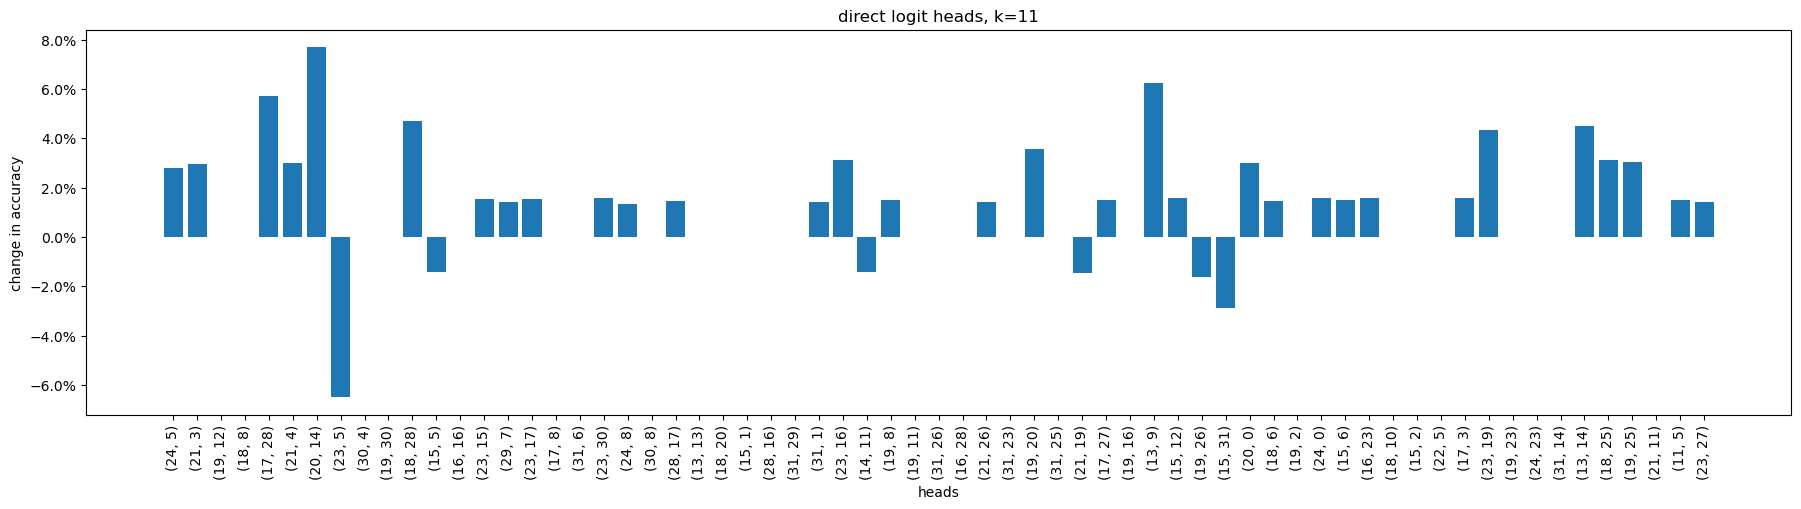

In [50]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

# with open('llama_direct_logit_heads_res_k_15.json', 'r') as f:
#   res = json.load(f)

names = []
scores = []

for k in res:
    new_k = str(k)
    names.append(str((int(new_k.split(".")[4]), int(new_k.split(",")[1][1:-1]))))
    scores.append((res[k][0] / res[k][1] - 1))

f, ax = plt.subplots(figsize=(22, 5))
plt.bar(names, scores)
plt.title("direct logit heads, k=11")
plt.xlabel("heads")
plt.ylabel("change in accuracy")
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

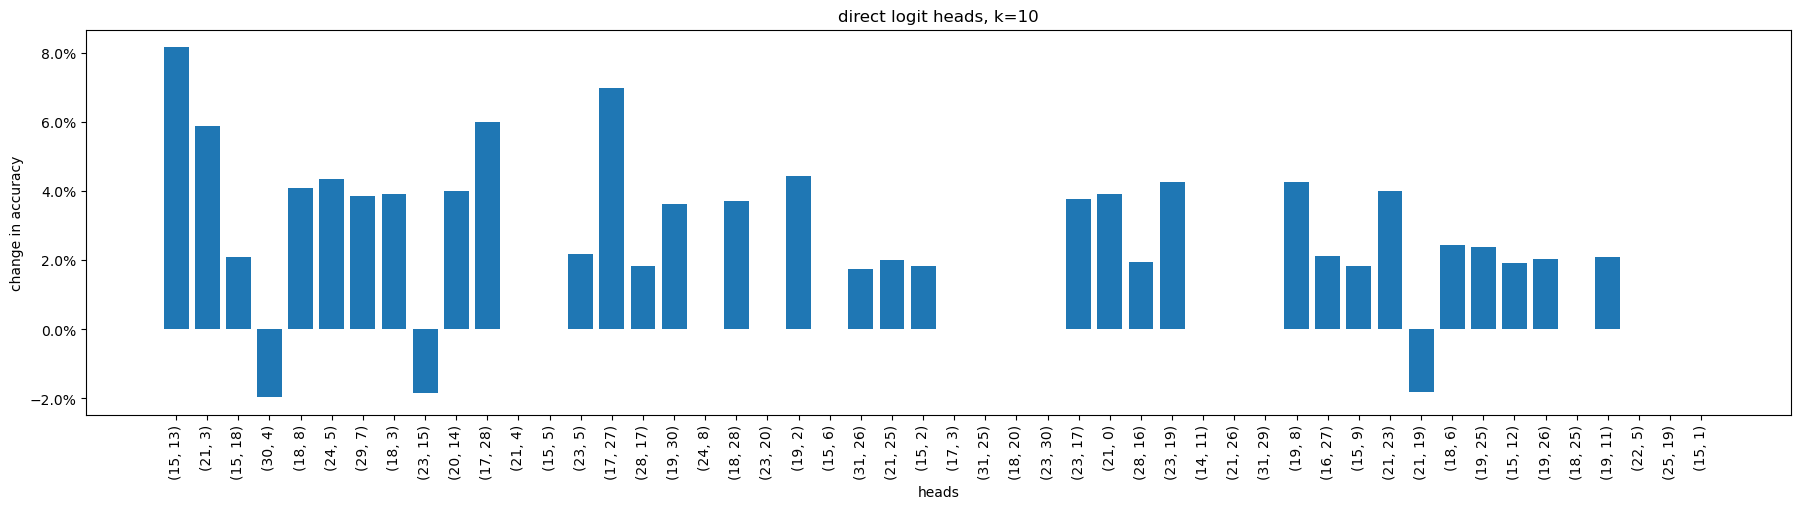

In [65]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

# with open('llama_direct_logit_heads_res_k_15.json', 'r') as f:
#   res = json.load(f)

names = []
scores = []

for k in res:
    new_k = str(k)
    names.append(str((int(new_k.split(".")[2]), int(new_k.split(",")[1][1:-1]))))
    scores.append((res[k][0] / res[k][1] - 1))

f, ax = plt.subplots(figsize=(22, 5))
plt.bar(names, scores)
plt.title("direct logit heads, k=10")
plt.xlabel("heads")
plt.ylabel("change in accuracy")
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

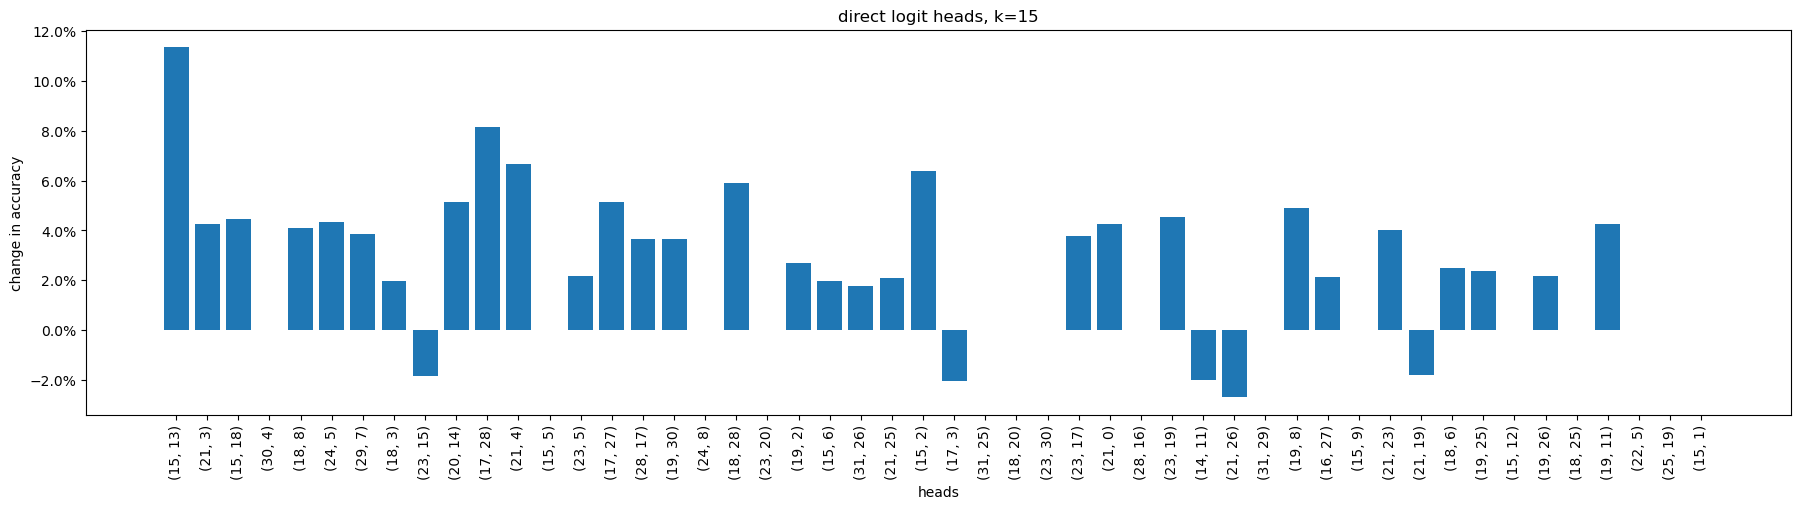

In [54]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

# with open('llama_direct_logit_heads_res_k_15.json', 'r') as f:
#   res = json.load(f)

names = []
scores = []

for k in res:
    new_k = str(k)
    names.append(str((int(new_k.split(".")[2]), int(new_k.split(",")[1][1:-1]))))
    scores.append((res[k][0] / res[k][1] - 1))

f, ax = plt.subplots(figsize=(22, 5))
plt.bar(names, scores)
plt.title("direct logit heads, k=15")
plt.xlabel("heads")
plt.ylabel("change in accuracy")
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

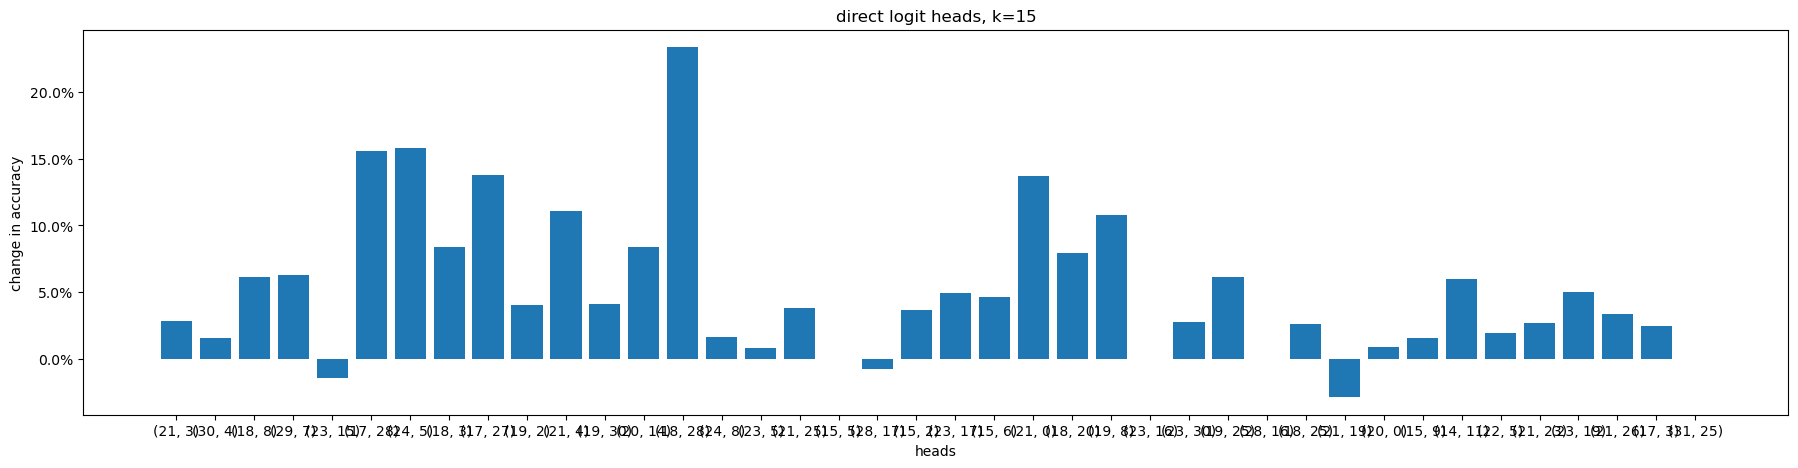

In [56]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

# with open('llama_direct_logit_heads_res_k_15.json', 'r') as f:
#   res = json.load(f)

names = []
scores = []

for k in res:
    names.append(str((int(k.split(".")[2]), int(k.split(",")[1][1:-1]))))
    scores.append((res[k][0] / res[k][1] - 1))

f, ax = plt.subplots(figsize=(22, 5))
plt.bar(names, scores)
plt.title("direct logit heads, k=15")
plt.xlabel("heads")
plt.ylabel("change in accuracy")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

## Remove nodes with low score 


In [40]:
n_value_fetcher = 84
n_pos_trans = 15
n_pos_detect = 35
n_struct_read = 10

In [33]:
with open(
    "../path_patching/minimality_res/minimality_large/llama_direct_logit_heads_res_k_14.json",
    "r",
) as f:
    llama_direct_logit_heads_res_k_15 = json.load(f)

with open(
    "../path_patching/minimality_res/minimality_large/head_at_query_box_token_new_11_significance.json",
    "r",
) as f:
    llama_head_at_query_box_token_res_k_10 = json.load(f)

with open(
    "../path_patching/minimality_res/minimality_large/heads_affecting_direct_logit_heads_5_significance.json",
    "r",
) as f:
    llama_heads_affecting_direct_logit_heads_res_k_5 = json.load(f)

with open(
    "../path_patching/minimality_res/minimality_large/llama_heads_at_prev_box_pos_3_significance.json",
    "r",
) as f:
    llama_heads_at_prev_box_pos_k_3 = json.load(f)

In [34]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

root_path = "../path_patching/goat_circuits/1404"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_value_fetcher, largest=False
)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_trans, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_detect, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(
    torch.load(path), k=n_struct_read, largest=False
)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

minimality_threshold = 0.5 / 100

for k in llama_direct_logit_heads_res_k_15:
    if (
        llama_direct_logit_heads_res_k_15[k][0]
        / llama_direct_logit_heads_res_k_15[k][1]
    ) - 1 < minimality_threshold:
        head = [int(k.split(".")[4]), int(k.split(",")[1][1:-1])]
        direct_logit_heads.remove(head)

for k in llama_head_at_query_box_token_res_k_10:
    if (
        llama_head_at_query_box_token_res_k_10[k][0]
        / llama_head_at_query_box_token_res_k_10[k][1]
    ) - 1 < minimality_threshold:
        head = [int(k.split(".")[4]), int(k.split(",")[1][1:-1])]
        head_at_query_box_token.remove(head)

for k in llama_heads_affecting_direct_logit_heads_res_k_5:
    if (
        llama_heads_affecting_direct_logit_heads_res_k_5[k][0]
        / llama_heads_affecting_direct_logit_heads_res_k_5[k][1]
    ) - 1 < minimality_threshold:
        head = [int(k.split(".")[4]), int(k.split(",")[1][1:-1])]
        heads_affecting_direct_logit_heads.remove(head)

for k in llama_heads_at_prev_box_pos_k_3:
    if (
        llama_heads_at_prev_box_pos_k_3[k][0] / llama_heads_at_prev_box_pos_k_3[k][1]
    ) - 1 < minimality_threshold:
        head = [int(k.split(".")[4]), int(k.split(",")[1][1:-1])]
        heads_at_prev_box_pos.remove(head)

print(f"Direct Logit Heads: {len(direct_logit_heads)}")
print(f"Heads Affecting Direct Logit Heads: {len(heads_affecting_direct_logit_heads)}")
print(f"Heads at Query Box Token: {len(head_at_query_box_token)}")
print(f"Heads at Prev Box Pos: {len(heads_at_prev_box_pos)}")
print(
    f"Total #heads: {len(direct_logit_heads) + len(heads_affecting_direct_logit_heads) + len(head_at_query_box_token) + len(heads_at_prev_box_pos)}"
)

Direct Logit Heads: 34
Heads Affecting Direct Logit Heads: 14
Heads at Query Box Token: 21
Heads at Prev Box Pos: 7
Total #heads: 76


In [35]:
for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)


for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)

In [36]:
eval(model, dataloader, modules, circuit_components, mean_activations)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:49<00:00,  4.93s/it]

Task accuracy: 0.7


0.7

In [38]:
circuit_heads = {
    "direct_logit_heads": direct_logit_heads,
    "heads_affecting_direct_logit_heads": heads_affecting_direct_logit_heads,
    "head_at_query_box_token": head_at_query_box_token,
    "heads_at_prev_box_pos": heads_at_prev_box_pos,
}

In [39]:
# Save circuit heads to json file
with open("new_circuit_heads.json", "w") as outfile:
    json.dump(circuit_heads, outfile)

## Circuit Performance

In [3]:
with open("./new_circuit_heads.json", "r") as file:
    circuit_heads = json.load(file)

In [4]:
direct_logit_heads = circuit_heads["direct_logit_heads"]
heads_affecting_direct_logit_heads = circuit_heads["heads_affecting_direct_logit_heads"]
head_at_query_box_token = circuit_heads["head_at_query_box_token"]
heads_at_prev_box_pos = circuit_heads["heads_at_prev_box_pos"]

print(f"Direct Logit Heads: {len(direct_logit_heads)}")
print(f"Heads Affecting Direct Logit Heads: {len(heads_affecting_direct_logit_heads)}")
print(f"Heads at Query Box Token: {len(head_at_query_box_token)}")
print(f"Heads at Prev Box Pos: {len(heads_at_prev_box_pos)}")
print(
    f"Total #heads: {len(direct_logit_heads) + len(heads_affecting_direct_logit_heads) + len(head_at_query_box_token) + len(heads_at_prev_box_pos)}"
)

Direct Logit Heads: 34
Heads Affecting Direct Logit Heads: 14
Heads at Query Box Token: 21
Heads at Prev Box Pos: 7
Total #heads: 76


In [5]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)


for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)

NameError: name 'model' is not defined

In [6]:
eval(model, dataloader, modules, circuit_components, mean_activations)

NameError: name 'model' is not defined

## Comparing Circuits

In [35]:
with open("./new_circuit_heads.json", "r") as file:
    new_circuit_heads = json.load(file)

goat_value_fetcher = new_circuit_heads["direct_logit_heads"]
heads_affecting_direct_logit_heads_goat_cir = new_circuit_heads[
    "heads_affecting_direct_logit_heads"
]
head_at_query_box_token_goat_cir = new_circuit_heads["head_at_query_box_token"]
heads_at_prev_box_pos_goat_cir = new_circuit_heads["heads_at_prev_box_pos"]

print(f"Direct Logit Heads: {len(goat_value_fetcher)}")
print(
    f"Heads Affecting Direct Logit Heads: {len(heads_affecting_direct_logit_heads_goat_cir)}"
)
print(f"Heads at Query Box Token: {len(head_at_query_box_token_goat_cir)}")
print(f"Heads at Prev Box Pos: {len(heads_at_prev_box_pos_goat_cir)}")
print(
    f"Total #heads: {len(goat_value_fetcher) + len(heads_affecting_direct_logit_heads_goat_cir) + len(head_at_query_box_token_goat_cir) + len(heads_at_prev_box_pos_goat_cir)}"
)

Direct Logit Heads: 34
Heads Affecting Direct Logit Heads: 14
Heads at Query Box Token: 21
Heads at Prev Box Pos: 7
Total #heads: 76


In [36]:
with open("../circuit_heads.json", "r") as file:
    llama_circuit = json.load(file)

llama_value_fetcher = llama_circuit["direct_logit_heads"]
llama_pos_transmitter = llama_circuit[
    "heads_affecting_direct_logit_heads"
]
head_at_query_box_token_llama_cir = llama_circuit["head_at_query_box_token"]
heads_at_prev_box_pos_llama_cir = llama_circuit["heads_at_prev_box_pos"]

print(f"Direct Logit Heads: {len(llama_value_fetcher)}")
print(
    f"Heads Affecting Direct Logit Heads: {len(llama_pos_transmitter)}"
)
print(f"Heads at Query Box Token: {len(head_at_query_box_token_llama_cir)}")
print(f"Heads at Prev Box Pos: {len(heads_at_prev_box_pos)}")
print(
    f"Total #heads: {len(llama_value_fetcher) + len(llama_pos_transmitter) + len(head_at_query_box_token_llama_cir) + len(heads_at_prev_box_pos_llama_cir)}"
)

Direct Logit Heads: 40
Heads Affecting Direct Logit Heads: 9
Heads at Query Box Token: 22
Heads at Prev Box Pos: 7
Total #heads: 75


In [37]:
# Find the intersection for each group of heads

direct_logit_heads_intersection = []
for head in goat_value_fetcher:
    if head in llama_value_fetcher:
        direct_logit_heads_intersection.append(head)

heads_affecting_direct_logit_heads_intersection = []
for head in heads_affecting_direct_logit_heads_goat_cir:
    if head in llama_pos_transmitter:
        heads_affecting_direct_logit_heads_intersection.append(head)

head_at_query_box_token_intersection = []
for head in head_at_query_box_token_goat_cir:
    if head in head_at_query_box_token_llama_cir:
        head_at_query_box_token_intersection.append(head)

heads_at_prev_box_pos_intersection = []
for head in heads_at_prev_box_pos_goat_cir:
    if head in heads_at_prev_box_pos_llama_cir:
        heads_at_prev_box_pos_intersection.append(head)

# Find the intersection between old_direct logit heads + old_heads affecting direct logit heads and new_direct logit heads + new_heads affecting direct logit heads
direct_logit_heads_and_heads_affecting_direct_logit_heads_intersection = []
for head in llama_value_fetcher + llama_pos_transmitter:
    if (
        head
        in goat_value_fetcher + heads_affecting_direct_logit_heads_goat_cir
    ):
        direct_logit_heads_and_heads_affecting_direct_logit_heads_intersection.append(
            head
        )

print(f"Direct Logit Heads: {len(direct_logit_heads_intersection)}")
print(
    f"Heads Affecting Direct Logit Heads: {len(heads_affecting_direct_logit_heads_intersection)}"
)
print(f"Heads at Query Box Token: {len(head_at_query_box_token_intersection)}")
print(f"Heads at Prev Box Pos: {len(heads_at_prev_box_pos_intersection)}")
print(
    f"Direct Logit Heads + Heads Affecting Direct Logit Heads: {len(direct_logit_heads_and_heads_affecting_direct_logit_heads_intersection)}"
)

Direct Logit Heads: 18
Heads Affecting Direct Logit Heads: 6
Heads at Query Box Token: 15
Heads at Prev Box Pos: 3
Direct Logit Heads + Heads Affecting Direct Logit Heads: 28


In [38]:
# Compute precision and recall for each group of heads

direct_logit_heads_precision = len(direct_logit_heads_intersection) / len(
    goat_value_fetcher
)
direct_logit_heads_recall = len(direct_logit_heads_intersection) / len(
    llama_value_fetcher
)

heads_affecting_direct_logit_heads_precision = len(
    heads_affecting_direct_logit_heads_intersection
) / len(heads_affecting_direct_logit_heads_goat_cir)
heads_affecting_direct_logit_heads_recall = len(
    heads_affecting_direct_logit_heads_intersection
) / len(llama_pos_transmitter)

head_at_query_box_token_precision = len(head_at_query_box_token_intersection) / len(
    head_at_query_box_token_goat_cir
)
head_at_query_box_token_recall = len(head_at_query_box_token_intersection) / len(
    head_at_query_box_token_llama_cir
)

heads_at_prev_box_pos_precision = len(heads_at_prev_box_pos_intersection) / len(
    heads_at_prev_box_pos_goat_cir
)
heads_at_prev_box_pos_recall = len(heads_at_prev_box_pos_intersection) / len(
    heads_at_prev_box_pos_llama_cir
)

direct_logit_heads_and_heads_affecting_direct_logit_heads_precision = len(
    direct_logit_heads_and_heads_affecting_direct_logit_heads_intersection
) / (
    len(goat_value_fetcher) + len(heads_affecting_direct_logit_heads_goat_cir)
)
direct_logit_heads_and_heads_affecting_direct_logit_heads_recall = len(
    direct_logit_heads_and_heads_affecting_direct_logit_heads_intersection
) / (
    len(llama_value_fetcher)
    + len(llama_pos_transmitter)
)

print(f"Direct Logit Heads Precision: {direct_logit_heads_precision}")
print(f"Direct Logit Heads Recall: {direct_logit_heads_recall}")
print(
    f"Heads Affecting Direct Logit Heads Precision: {heads_affecting_direct_logit_heads_precision}"
)
print(
    f"Heads Affecting Direct Logit Heads Recall: {heads_affecting_direct_logit_heads_recall}"
)
print(f"Heads at Query Box Token Precision: {head_at_query_box_token_precision}")
print(f"Heads at Query Box Token Recall: {head_at_query_box_token_recall}")
print(f"Heads at Prev Box Pos Precision: {heads_at_prev_box_pos_precision}")
print(f"Heads at Prev Box Pos Recall: {heads_at_prev_box_pos_recall}")
print(
    f"Direct Logit Heads + Heads Affecting Direct Logit Heads Precision: {direct_logit_heads_and_heads_affecting_direct_logit_heads_precision}"
)
print(
    f"Direct Logit Heads + Heads Affecting Direct Logit Heads Recall: {direct_logit_heads_and_heads_affecting_direct_logit_heads_recall}"
)

Direct Logit Heads Precision: 0.5294117647058824
Direct Logit Heads Recall: 0.45
Heads Affecting Direct Logit Heads Precision: 0.42857142857142855
Heads Affecting Direct Logit Heads Recall: 0.6666666666666666
Heads at Query Box Token Precision: 0.7142857142857143
Heads at Query Box Token Recall: 0.6818181818181818
Heads at Prev Box Pos Precision: 0.42857142857142855
Heads at Prev Box Pos Recall: 0.75
Direct Logit Heads + Heads Affecting Direct Logit Heads Precision: 0.5833333333333334
Direct Logit Heads + Heads Affecting Direct Logit Heads Recall: 0.5714285714285714


## Intersection Visualization

In [26]:
n_value_fetcher = 84
n_pos_trans = 15
n_pos_detect = 35
n_struct_read = 10

root_path = "../path_patching/goat_circuits/1404"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
mean_direct_logit_heads = torch.mean(logit_values)

(
    direct_logit_heads_goat_from_pp,
    direct_logit_heads_values_goat_from_pp,
) = analysis_utils.compute_topk_components(
    torch.load(path), k=n_value_fetcher, largest=False
)
direct_logit_heads_values_goat_from_pp = [
    mean_direct_logit_heads.item() - val
    for val in direct_logit_heads_values_goat_from_pp
]

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
(
    heads_affecting_direct_logit_heads_goat_from_pp,
    heads_affecting_direct_logit_heads_values_goat_from_pp,
) = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_trans, largest=False
)
mean_heads_affecting_direct_logit_heads = torch.mean(logit_values)
heads_affecting_direct_logit_heads_values_goat_from_pp = [
    mean_heads_affecting_direct_logit_heads.item() - val
    for val in heads_affecting_direct_logit_heads_values_goat_from_pp
]

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
(
    head_at_query_box_token_goat_from_pp,
    head_at_query_box_token_values_goat_from_pp,
) = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_detect, largest=False
)
mean_head_at_query_box_token = torch.mean(logit_values)
head_at_query_box_token_values_goat_from_pp = [
    mean_head_at_query_box_token.item() - val
    for val in head_at_query_box_token_values_goat_from_pp
]

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
(
    heads_at_prev_box_pos_goat_from_pp,
    heads_at_prev_box_pos_values_goat_from_pp,
) = analysis_utils.compute_topk_components(
    torch.load(path), k=n_struct_read, largest=False
)
mean_heads_at_prev_box_pos = torch.mean(logit_values)
heads_at_prev_box_pos_values_goat_from_pp = [
    mean_heads_at_prev_box_pos.item() - val
    for val in heads_at_prev_box_pos_values_goat_from_pp
]

intersection = []
for head in direct_logit_heads_goat_from_pp:
    if head in heads_affecting_direct_logit_heads_goat_from_pp:
        intersection.append(head)

for head in intersection:
    index = direct_logit_heads_goat_from_pp.index(head)
    direct_logit_heads_values_goat_from_pp.pop(index)
    direct_logit_heads_goat_from_pp.remove(head)


print(
    len(direct_logit_heads_values_goat_from_pp),
    len(heads_affecting_direct_logit_heads_goat_from_pp),
    len(head_at_query_box_token_goat_from_pp),
    len(heads_at_prev_box_pos_goat_from_pp),
)

70 15 35 10


In [27]:
with open("./new_circuit_heads.json", "r") as file:
    new_circuit_heads = json.load(file)

goat_value_fetcher = new_circuit_heads["direct_logit_heads"]
heads_affecting_direct_logit_heads_goat_cir = new_circuit_heads[
    "heads_affecting_direct_logit_heads"
]
head_at_query_box_token_goat_cir = new_circuit_heads["head_at_query_box_token"]
heads_at_prev_box_pos_goat_cir = new_circuit_heads["heads_at_prev_box_pos"]

In [6]:
n_value_fetcher = 130
n_pos_trans = 50
n_pos_detect = 75
n_struct_read = 20

root_path = "../new_pp_exps/reverse/7_boxes"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
mean_direct_logit_heads = torch.mean(logit_values)
(
    direct_logit_heads_llama_from_pp,
    direct_logit_heads_values_llama_from_pp,
) = analysis_utils.compute_topk_components(
    torch.load(path), k=n_value_fetcher, largest=False
)
direct_logit_heads_values_llama_from_pp = [
    mean_direct_logit_heads.item() - val
    for val in direct_logit_heads_values_llama_from_pp
]

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
mean_heads_affecting_direct_logit_heads = torch.mean(logit_values)
(
    heads_affecting_direct_logit_heads_llama_from_pp,
    heads_affecting_direct_logit_heads_values_llama_from_pp,
) = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_trans, largest=False
)
heads_affecting_direct_logit_heads_values_llama_from_pp = [
    mean_heads_affecting_direct_logit_heads.item() - val
    for val in heads_affecting_direct_logit_heads_values_llama_from_pp
]

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
mean_head_at_query_box_token = torch.mean(logit_values)
(
    head_at_query_box_token_llama_from_pp,
    head_at_query_box_token_values_llama_from_pp,
) = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_detect, largest=False
)
head_at_query_box_token_values_llama_from_pp = [
    mean_head_at_query_box_token.item() - val
    for val in head_at_query_box_token_values_llama_from_pp
]

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
mean_heads_at_prev_box_pos = torch.mean(logit_values)
(
    heads_at_prev_box_pos_llama_from_pp,
    heads_at_prev_box_pos_values_llama_from_pp,
) = analysis_utils.compute_topk_components(
    torch.load(path), k=n_struct_read, largest=False
)
heads_at_prev_box_pos_values_llama_from_pp = [
    mean_heads_at_prev_box_pos.item() - val
    for val in heads_at_prev_box_pos_values_llama_from_pp
]

intersection = []
for head in direct_logit_heads_llama_from_pp:
    if head in heads_affecting_direct_logit_heads_llama_from_pp:
        intersection.append(head)

for head in intersection:
    index = direct_logit_heads_llama_from_pp.index(head)
    direct_logit_heads_values_llama_from_pp.pop(index)
    direct_logit_heads_llama_from_pp.remove(head)


print(
    len(direct_logit_heads_llama_from_pp),
    len(heads_affecting_direct_logit_heads_llama_from_pp),
    len(head_at_query_box_token_llama_from_pp),
    len(heads_at_prev_box_pos_llama_from_pp),
)

94 50 75 20


In [7]:
with open("../circuit_heads.json", "r") as file:
    llama_circuit = json.load(file)

llama_value_fetcher = llama_circuit["direct_logit_heads"]
llama_pos_transmitter = llama_circuit[
    "heads_affecting_direct_logit_heads"
]
head_at_query_box_token_llama_cir = llama_circuit["head_at_query_box_token"]
heads_at_prev_box_pos_llama_cir = llama_circuit["heads_at_prev_box_pos"]

Text(0, 0.5, 'Logit Value')

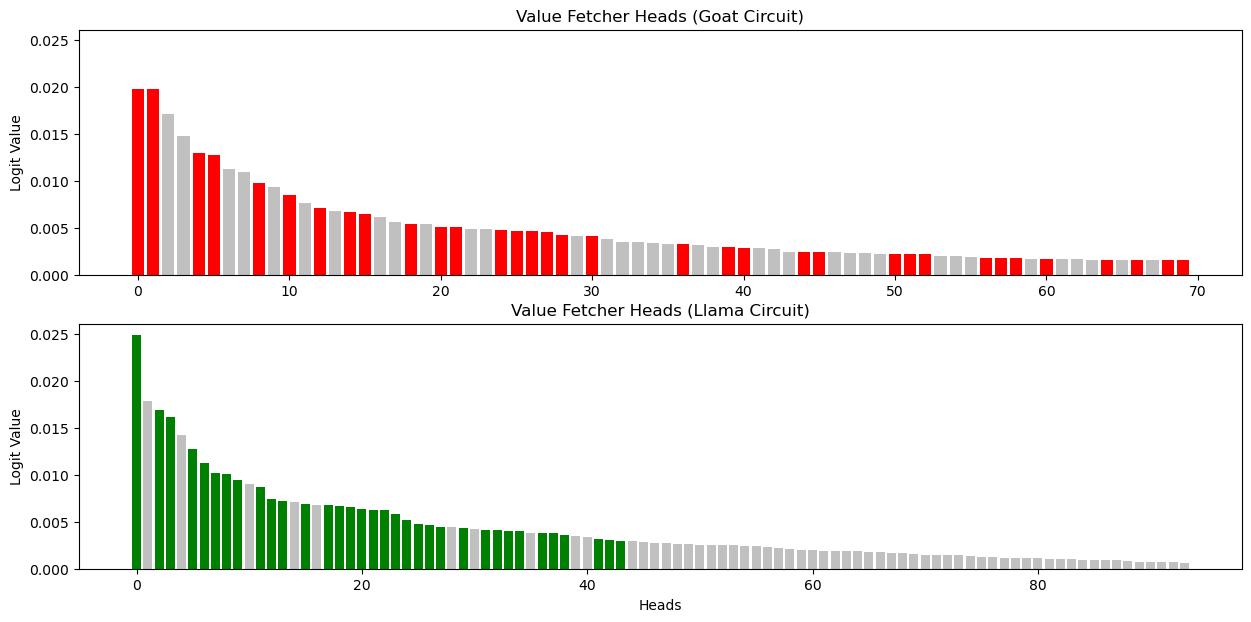

In [11]:
# Create two subplots to visualize direct_logit_heads_values as bar chart
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 7), sharey=True)

# Plot the bar chart for direct_logit_heads_values
ax1.bar(
    [i for i in range(len(direct_logit_heads_values_goat_from_pp))],
    direct_logit_heads_values_goat_from_pp,
)
# Color the heads that are in new_direct_logit_heads
for i in range(len(direct_logit_heads_values_goat_from_pp)):
    if direct_logit_heads_goat_from_pp[i] in goat_value_fetcher:
        ax1.bar(i, direct_logit_heads_values_goat_from_pp[i], color="red")
    else:
        ax1.bar(i, direct_logit_heads_values_goat_from_pp[i], color="silver")

ax2.bar(
    [i for i in range(len(direct_logit_heads_values_llama_from_pp))],
    direct_logit_heads_values_llama_from_pp,
)
# Color the heads that are in new_direct_logit_heads
for i in range(len(direct_logit_heads_values_llama_from_pp)):
    if direct_logit_heads_llama_from_pp[i] in llama_value_fetcher:
        ax2.bar(i, direct_logit_heads_values_llama_from_pp[i], color="green")
    else:
        ax2.bar(i, direct_logit_heads_values_llama_from_pp[i], color="silver")

# Set the title for the bar chart
ax1.set_title("Value Fetcher Heads (Goat Circuit)")
ax2.set_title("Value Fetcher Heads (Llama Circuit)")

# Set the x and y axis labels
ax2.set_xlabel("Heads")
ax1.set_ylabel("Logit Value")
ax2.set_ylabel("Logit Value")

Text(0, 0.5, 'Logit Value')

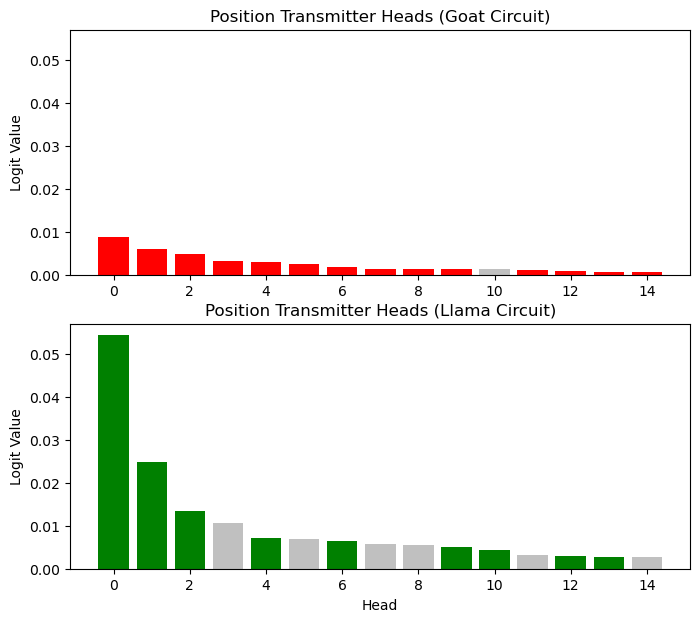

In [17]:
# Draw previos graphs for heads_affecting_direct_logit_heads_values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7), sharey=True)

ax1.bar(
    [i for i in range(len(heads_affecting_direct_logit_heads_values_goat_from_pp))],
    heads_affecting_direct_logit_heads_values_goat_from_pp,
)
for i in range(len(heads_affecting_direct_logit_heads_values_goat_from_pp)):
    if (
        heads_affecting_direct_logit_heads_goat_from_pp[i]
        in heads_affecting_direct_logit_heads_goat_cir
    ):
        ax1.bar(
            i, heads_affecting_direct_logit_heads_values_goat_from_pp[i], color="red"
        )
    else:
        ax1.bar(
            i, heads_affecting_direct_logit_heads_values_goat_from_pp[i], color="silver"
        )

ax2.bar(
    [i for i in range(len(heads_affecting_direct_logit_heads_values_llama_from_pp))],
    heads_affecting_direct_logit_heads_values_llama_from_pp,
)
for i in range(len(heads_affecting_direct_logit_heads_values_llama_from_pp)):
    if (
        heads_affecting_direct_logit_heads_llama_from_pp[i]
        in llama_pos_transmitter
    ):
        ax2.bar(
            i, heads_affecting_direct_logit_heads_values_llama_from_pp[i], color="green"
        )
    else:
        ax2.bar(
            i,
            heads_affecting_direct_logit_heads_values_llama_from_pp[i],
            color="silver",
        )

ax1.set_title("Position Transmitter Heads (Goat Circuit)")
ax2.set_title("Position Transmitter Heads (Llama Circuit)")

ax2.set_xlabel("Head")
ax1.set_ylabel("Logit Value")
ax2.set_ylabel("Logit Value")

Text(0, 0.5, 'Logit Value')

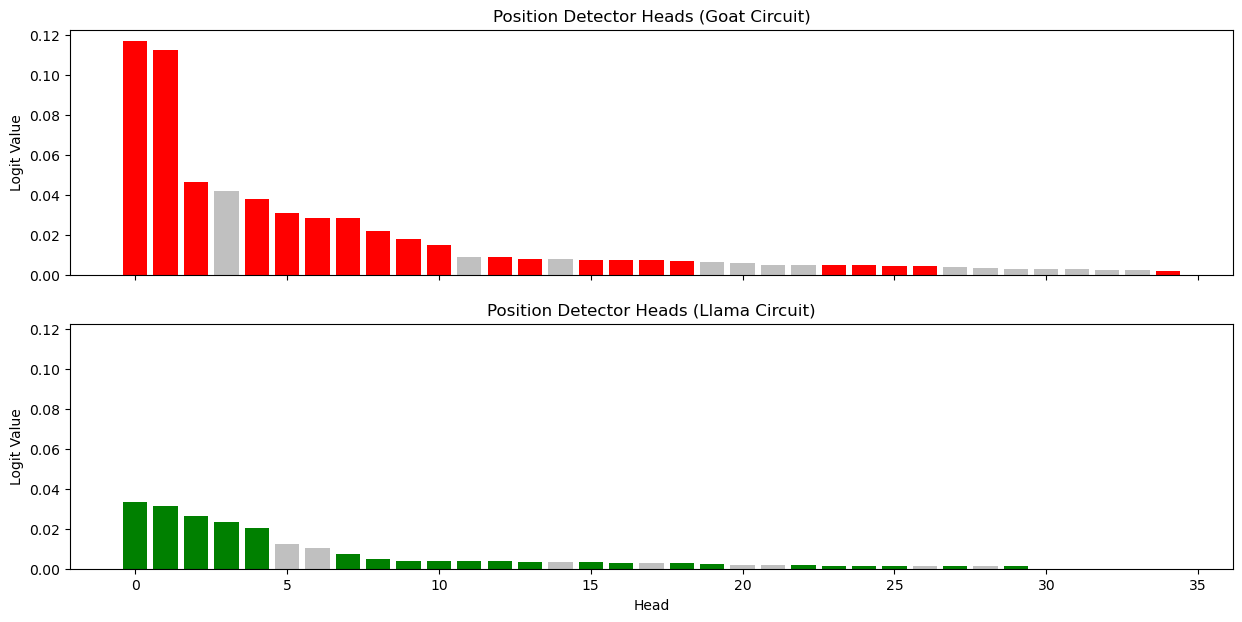

In [18]:
# Draw previous graphs for head_at_query_box_token_values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 7), sharey=True, sharex=True)

ax1.bar(
    [i for i in range(len(head_at_query_box_token_values_goat_from_pp))],
    head_at_query_box_token_values_goat_from_pp,
)
for i in range(len(head_at_query_box_token_values_goat_from_pp)):
    if head_at_query_box_token_goat_from_pp[i] in head_at_query_box_token_goat_cir:
        ax1.bar(i, head_at_query_box_token_values_goat_from_pp[i], color="red")
    else:
        ax1.bar(i, head_at_query_box_token_values_goat_from_pp[i], color="silver")

ax2.bar(
    [i for i in range(len(head_at_query_box_token_values_llama_from_pp))],
    head_at_query_box_token_values_llama_from_pp,
)
for i in range(len(head_at_query_box_token_values_llama_from_pp)):
    if head_at_query_box_token_llama_from_pp[i] in head_at_query_box_token_llama_cir:
        ax2.bar(i, head_at_query_box_token_values_llama_from_pp[i], color="green")
    else:
        ax2.bar(i, head_at_query_box_token_values_llama_from_pp[i], color="silver")

ax1.set_title("Position Detector Heads (Goat Circuit)")
ax2.set_title("Position Detector Heads (Llama Circuit)")

ax2.set_xlabel("Head")
ax1.set_ylabel("Logit Value")
ax2.set_ylabel("Logit Value")

Text(0, 0.5, 'Logit Value')

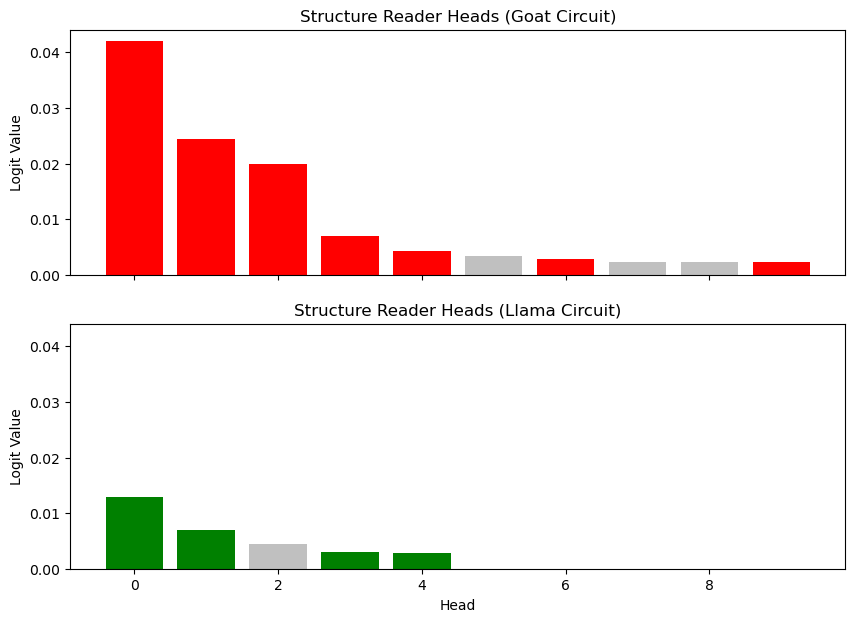

In [19]:
# Draw previous graphs for heads_at_prev_box_pos_values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharey=True, sharex=True)

ax1.bar(
    [i for i in range(len(heads_at_prev_box_pos_values_goat_from_pp))],
    heads_at_prev_box_pos_values_goat_from_pp,
)
for i in range(len(heads_at_prev_box_pos_values_goat_from_pp)):
    if heads_at_prev_box_pos_goat_from_pp[i] in heads_at_prev_box_pos_goat_cir:
        ax1.bar(i, heads_at_prev_box_pos_values_goat_from_pp[i], color="red")
    else:
        ax1.bar(i, heads_at_prev_box_pos_values_goat_from_pp[i], color="silver")

ax2.bar(
    [i for i in range(len(heads_at_prev_box_pos_values_llama_from_pp))],
    heads_at_prev_box_pos_values_llama_from_pp,
)
for i in range(len(heads_at_prev_box_pos_values_llama_from_pp)):
    if heads_at_prev_box_pos_llama_from_pp[i] in heads_at_prev_box_pos_llama_cir:
        ax2.bar(i, heads_at_prev_box_pos_values_llama_from_pp[i], color="green")
    else:
        ax2.bar(i, heads_at_prev_box_pos_values_llama_from_pp[i], color="silver")

ax1.set_title("Structure Reader Heads (Goat Circuit)")
ax2.set_title("Structure Reader Heads (Llama Circuit)")

ax2.set_xlabel("Head")
ax1.set_ylabel("Logit Value")
ax2.set_ylabel("Logit Value")

In [22]:
# Create a list of tuple of (head, logit value) for each group of heads

direct_logit_heads_new = [
    (head, direct_logit_heads_values_goat_from_pp[i])
    for i, head in enumerate(direct_logit_heads_goat_from_pp)
]
heads_affecting_direct_logit_heads_new = [
    (head, heads_affecting_direct_logit_heads_values_goat_from_pp[i])
    for i, head in enumerate(heads_affecting_direct_logit_heads_goat_from_pp)
]
head_at_query_box_token_new = [
    (head, head_at_query_box_token_values_goat_from_pp[i])
    for i, head in enumerate(head_at_query_box_token_goat_from_pp)
]
heads_at_prev_box_pos_new = [
    (head, heads_at_prev_box_pos_values_goat_from_pp[i])
    for i, head in enumerate(heads_at_prev_box_pos_goat_from_pp)
]
all_heads_new = (
    direct_logit_heads_new
    + heads_affecting_direct_logit_heads_new
    + head_at_query_box_token_new
    + heads_at_prev_box_pos_new
)

direct_logit_heads_old = [
    (head, direct_logit_heads_values_llama_from_pp[i])
    for i, head in enumerate(direct_logit_heads_llama_from_pp)
]
heads_affecting_direct_logit_heads_old = [
    (head, heads_affecting_direct_logit_heads_values_llama_from_pp[i])
    for i, head in enumerate(heads_affecting_direct_logit_heads_llama_from_pp)
]
head_at_query_box_token_old = [
    (head, head_at_query_box_token_values_llama_from_pp[i])
    for i, head in enumerate(head_at_query_box_token_llama_from_pp)
]
heads_at_prev_box_pos_old = [
    (head, heads_at_prev_box_pos_values_llama_from_pp[i])
    for i, head in enumerate(heads_at_prev_box_pos_llama_from_pp)
]
all_heads_old = (
    direct_logit_heads_old
    + heads_affecting_direct_logit_heads_old
    + head_at_query_box_token_old
    + heads_at_prev_box_pos_old
)

In [30]:
# Sort the list of tuple by logit value
all_heads_new.sort(key=lambda x: x[1], reverse=True)
all_heads_old.sort(key=lambda x: x[1], reverse=True)

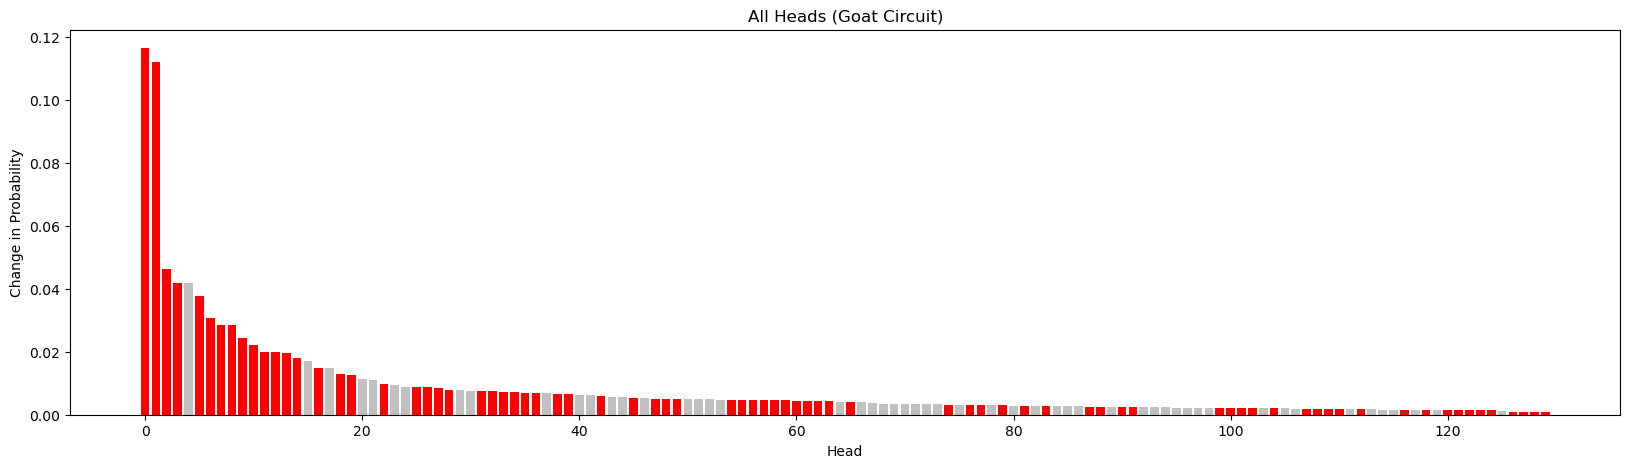

In [44]:
# Plot the bar chart for all_heads_new
plt.figure(figsize=(20, 5))

plt.bar(
    [i for i in range(len(all_heads_new))],
    [head[1] for head in all_heads_new],
)
for i in range(len(all_heads_new)):
    if all_heads_new[i][0] in goat_value_fetcher:
        plt.bar(i, all_heads_new[i][1], color="red")
    elif all_heads_new[i][0] in heads_affecting_direct_logit_heads_goat_cir:
        plt.bar(i, all_heads_new[i][1], color="red")
    elif all_heads_new[i][0] in head_at_query_box_token_goat_cir:
        plt.bar(i, all_heads_new[i][1], color="red")
    elif all_heads_new[i][0] in heads_at_prev_box_pos_goat_cir:
        plt.bar(i, all_heads_new[i][1], color="red")
    else:
        plt.bar(i, all_heads_new[i][1], color="silver")

plt.title("All Heads (Goat Circuit)")
plt.xlabel("Head")
plt.ylabel("Change in Probability")
plt.show()

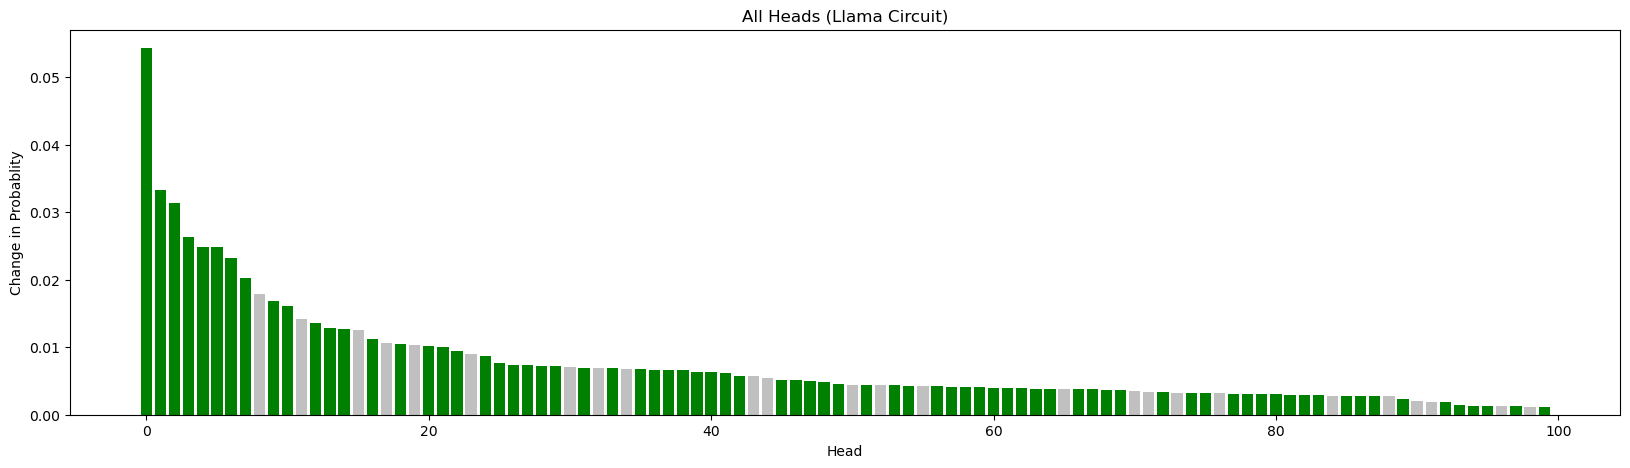

In [45]:
# Plot the bar chart for all_heads_old
plt.figure(figsize=(20, 5))

plt.bar(
    [i for i in range(len(all_heads_old))],
    [head[1] for head in all_heads_old],
)
for i in range(len(all_heads_old)):
    if all_heads_old[i][0] in llama_value_fetcher:
        plt.bar(i, all_heads_old[i][1], color="green")
    elif all_heads_old[i][0] in llama_pos_transmitter:
        plt.bar(i, all_heads_old[i][1], color="green")
    elif all_heads_old[i][0] in head_at_query_box_token_llama_cir:
        plt.bar(i, all_heads_old[i][1], color="green")
    elif all_heads_old[i][0] in heads_at_prev_box_pos_llama_cir:
        plt.bar(i, all_heads_old[i][1], color="green")
    else:
        plt.bar(i, all_heads_old[i][1], color="silver")

plt.title("All Heads (Llama Circuit)")
plt.xlabel("Head")
plt.ylabel("Change in Probablity")
plt.show()

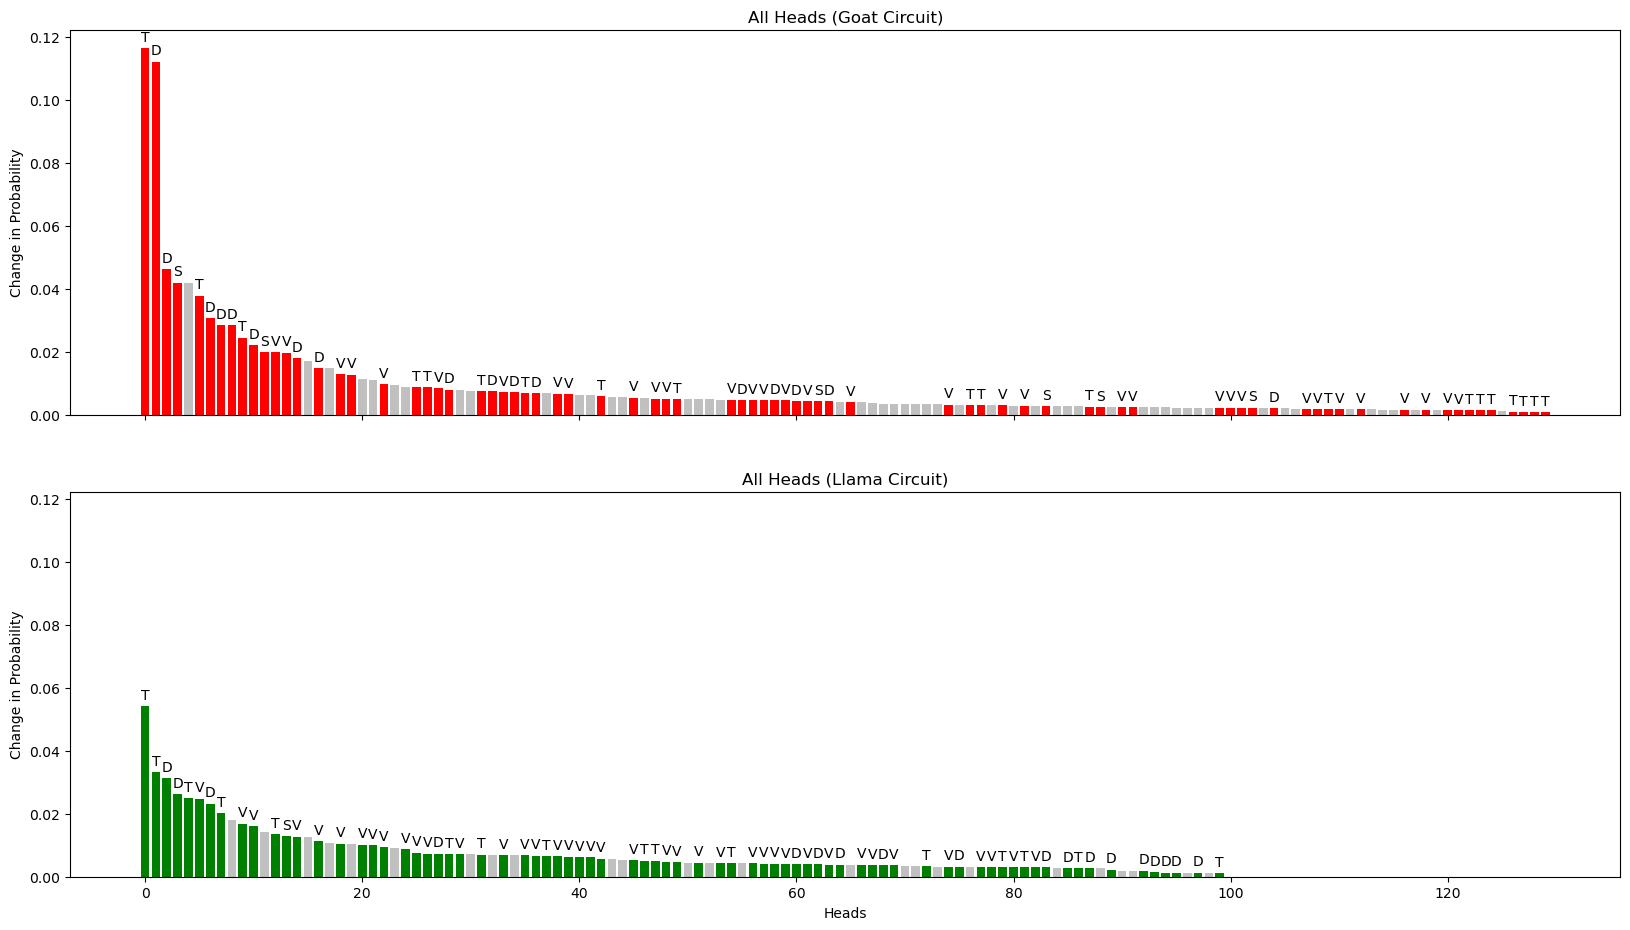

In [61]:
# Create two subplots with shared y-axis to visualize the change in probability for all old and new heads

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 11), sharey=True, sharex=True)

ax1.bar(
    [i for i in range(len(all_heads_new))],
    [head[1] for head in all_heads_new],
)
for i in range(len(all_heads_new)):
    if all_heads_new[i][0] in goat_value_fetcher:
        ax1.bar(i, all_heads_new[i][1], color="red")
    elif all_heads_new[i][0] in heads_affecting_direct_logit_heads_goat_cir:
        ax1.bar(i, all_heads_new[i][1], color="red")
    elif all_heads_new[i][0] in head_at_query_box_token_goat_cir:
        ax1.bar(i, all_heads_new[i][1], color="red")
    elif all_heads_new[i][0] in heads_at_prev_box_pos_goat_cir:
        ax1.bar(i, all_heads_new[i][1], color="red")
    else:
        ax1.bar(i, all_heads_new[i][1], color="silver")

for i in range(len(all_heads_new)):
    if all_heads_new[i][0] in goat_value_fetcher:
        ax1.annotate(
            "V",
            (i, all_heads_new[i][1]),
            textcoords="offset points",
            xytext=(0, 5),
            ha="center",
        )
    elif all_heads_new[i][0] in heads_affecting_direct_logit_heads_goat_cir:
        ax1.annotate(
            "T",
            (i, all_heads_new[i][1]),
            textcoords="offset points",
            xytext=(0, 5),
            ha="center",
        )
    elif all_heads_new[i][0] in head_at_query_box_token_goat_cir:
        ax1.annotate(
            "D",
            (i, all_heads_new[i][1]),
            textcoords="offset points",
            xytext=(0, 5),
            ha="center",
        )
    elif all_heads_new[i][0] in heads_at_prev_box_pos_goat_cir:
        ax1.annotate(
            "S",
            (i, all_heads_new[i][1]),
            textcoords="offset points",
            xytext=(0, 5),
            ha="center",
        )

ax2.bar(
    [i for i in range(len(all_heads_old))],
    [head[1] for head in all_heads_old],
)
for i in range(len(all_heads_old)):
    if all_heads_old[i][0] in llama_value_fetcher:
        ax2.bar(i, all_heads_old[i][1], color="green")
    elif all_heads_old[i][0] in llama_pos_transmitter:
        ax2.bar(i, all_heads_old[i][1], color="green")
    elif all_heads_old[i][0] in head_at_query_box_token_llama_cir:
        ax2.bar(i, all_heads_old[i][1], color="green")
    elif all_heads_old[i][0] in heads_at_prev_box_pos_llama_cir:
        ax2.bar(i, all_heads_old[i][1], color="green")
    else:
        ax2.bar(i, all_heads_old[i][1], color="silver")

for i in range(len(all_heads_old)):
    if all_heads_old[i][0] in llama_value_fetcher:
        ax2.annotate(
            "V",
            (i, all_heads_old[i][1]),
            textcoords="offset points",
            xytext=(0, 5),
            ha="center",
        )
    elif all_heads_old[i][0] in llama_pos_transmitter:
        ax2.annotate(
            "T",
            (i, all_heads_old[i][1]),
            textcoords="offset points",
            xytext=(0, 5),
            ha="center",
        )
    elif all_heads_old[i][0] in head_at_query_box_token_llama_cir:
        ax2.annotate(
            "D",
            (i, all_heads_old[i][1]),
            textcoords="offset points",
            xytext=(0, 5),
            ha="center",
        )
    elif all_heads_old[i][0] in heads_at_prev_box_pos_llama_cir:
        ax2.annotate(
            "S",
            (i, all_heads_old[i][1]),
            textcoords="offset points",
            xytext=(0, 5),
            ha="center",
        )

ax1.set_title("All Heads (Goat Circuit)")
ax2.set_title("All Heads (Llama Circuit)")

ax2.set_xlabel("Heads")
ax1.set_ylabel("Change in Probability")
ax2.set_ylabel("Change in Probability")

plt.show()

In [69]:
# Create a dictionary with keys as heads from all_heads_new + all_heads_old and values as a tuple of change in probability in new and old circuits
all_heads_dict = {}
for head, _ in all_heads_new + all_heads_old:
    head = tuple(head)
    if head not in all_heads_dict:
        all_heads_dict[head] = (0, 0)

for head in all_heads_new:
    all_heads_dict[head[0]] = (head[1], all_heads_dict[head[0]][1])

for head in all_heads_old:
    all_heads_dict[head[0]] = (all_heads_dict[head[0]][0], head[1])

TypeError: unhashable type: 'list'

## New Viz

In [2]:
n_value_fetcher = 58
n_pos_trans = 10
n_pos_detect = 25
n_struct_read = 5

root_path = "../experiment_1/results/path_patching/llama_circuit"
path = root_path + "/value_fetcher.pt"
logit_values = torch.load(path)
mean_direct_logit_heads = torch.mean(logit_values)
(
    direct_logit_heads_llama_from_pp,
    direct_logit_heads_values_llama_from_pp,
) = analysis_utils.compute_topk_components(
    torch.load(path), k=n_value_fetcher, largest=False
)
direct_logit_heads_values_llama_from_pp = [
    mean_direct_logit_heads.item() - val
    for val in direct_logit_heads_values_llama_from_pp
]

path = root_path + "/pos_transmitter.pt"
logit_values = torch.load(path)
mean_heads_affecting_direct_logit_heads = torch.mean(logit_values)
(
    heads_affecting_direct_logit_heads_llama_from_pp,
    heads_affecting_direct_logit_heads_values_llama_from_pp,
) = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_trans, largest=False
)
heads_affecting_direct_logit_heads_values_llama_from_pp = [
    mean_heads_affecting_direct_logit_heads.item() - val
    for val in heads_affecting_direct_logit_heads_values_llama_from_pp
]

path = root_path + "/pos_detector.pt"
logit_values = torch.load(path)
mean_head_at_query_box_token = torch.mean(logit_values)
(
    head_at_query_box_token_llama_from_pp,
    head_at_query_box_token_values_llama_from_pp,
) = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_detect, largest=False
)
head_at_query_box_token_values_llama_from_pp = [
    mean_head_at_query_box_token.item() - val
    for val in head_at_query_box_token_values_llama_from_pp
]

path = root_path + "/struct_reader.pt"
logit_values = torch.load(path)
mean_heads_at_prev_box_pos = torch.mean(logit_values)
(
    heads_at_prev_box_pos_llama_from_pp,
    heads_at_prev_box_pos_values_llama_from_pp,
) = analysis_utils.compute_topk_components(
    torch.load(path), k=n_struct_read, largest=False
)
heads_at_prev_box_pos_values_llama_from_pp = [
    mean_heads_at_prev_box_pos.item() - val
    for val in heads_at_prev_box_pos_values_llama_from_pp
]

intersection = []
for head in direct_logit_heads_llama_from_pp:
    if head in heads_affecting_direct_logit_heads_llama_from_pp:
        intersection.append(head)

for head in intersection:
    index = direct_logit_heads_llama_from_pp.index(head)
    direct_logit_heads_values_llama_from_pp.pop(index)
    direct_logit_heads_llama_from_pp.remove(head)


print(
    len(direct_logit_heads_llama_from_pp),
    len(heads_affecting_direct_logit_heads_llama_from_pp),
    len(head_at_query_box_token_llama_from_pp),
    len(heads_at_prev_box_pos_llama_from_pp),
)

50 10 25 5


In [3]:
with open("../experiment_1/results/circuits/llama_circuit.json", "r") as file:
    llama_circuit = json.load(file)

llama_value_fetcher = llama_circuit["value_fetcher"]
llama_pos_transmitter = llama_circuit["pos_transmitter"]
llama_pos_detector = llama_circuit["pos_detector"]
llama_struct_reader = llama_circuit["struct_reader"]

print(
    len(llama_value_fetcher),
    len(llama_pos_transmitter),
    len(llama_pos_detector),
    len(llama_struct_reader),
)

40 7 20 5


In [4]:
n_value_fetcher = 101
n_pos_trans = 30
n_pos_detect = 50
n_struct_read = 40

root_path = "../experiment_1/results/path_patching/goat_circuit"
path = root_path + "/value_fetcher.pt"
logit_values = torch.load(path)
mean_direct_logit_heads = torch.mean(logit_values)

(
    direct_logit_heads_goat_from_pp,
    direct_logit_heads_values_goat_from_pp,
) = analysis_utils.compute_topk_components(
    torch.load(path), k=n_value_fetcher, largest=False
)
direct_logit_heads_values_goat_from_pp = [
    mean_direct_logit_heads.item() - val
    for val in direct_logit_heads_values_goat_from_pp
]

path = root_path + "/pos_transmitter.pt"
logit_values = torch.load(path)
(
    heads_affecting_direct_logit_heads_goat_from_pp,
    heads_affecting_direct_logit_heads_values_goat_from_pp,
) = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_trans, largest=False
)
mean_heads_affecting_direct_logit_heads = torch.mean(logit_values)
heads_affecting_direct_logit_heads_values_goat_from_pp = [
    mean_heads_affecting_direct_logit_heads.item() - val
    for val in heads_affecting_direct_logit_heads_values_goat_from_pp
]

path = root_path + "/pos_detector.pt"
logit_values = torch.load(path)
(
    head_at_query_box_token_goat_from_pp,
    head_at_query_box_token_values_goat_from_pp,
) = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_detect, largest=False
)
mean_head_at_query_box_token = torch.mean(logit_values)
head_at_query_box_token_values_goat_from_pp = [
    mean_head_at_query_box_token.item() - val
    for val in head_at_query_box_token_values_goat_from_pp
]

path = root_path + "/struct_reader.pt"
logit_values = torch.load(path)
(
    heads_at_prev_box_pos_goat_from_pp,
    heads_at_prev_box_pos_values_goat_from_pp,
) = analysis_utils.compute_topk_components(
    torch.load(path), k=n_struct_read, largest=False
)
mean_heads_at_prev_box_pos = torch.mean(logit_values)
heads_at_prev_box_pos_values_goat_from_pp = [
    mean_heads_at_prev_box_pos.item() - val
    for val in heads_at_prev_box_pos_values_goat_from_pp
]

intersection = []
for head in direct_logit_heads_goat_from_pp:
    if head in heads_affecting_direct_logit_heads_goat_from_pp:
        intersection.append(head)

for head in intersection:
    index = direct_logit_heads_goat_from_pp.index(head)
    direct_logit_heads_values_goat_from_pp.pop(index)
    direct_logit_heads_goat_from_pp.remove(head)


print(
    len(direct_logit_heads_values_goat_from_pp),
    len(heads_affecting_direct_logit_heads_goat_from_pp),
    len(head_at_query_box_token_goat_from_pp),
    len(heads_at_prev_box_pos_goat_from_pp),
)

80 30 50 40


In [5]:
with open("../experiment_1/results/circuits/goat_circuit.json", "r") as file:
    new_circuit_heads = json.load(file)

goat_value_fetcher = new_circuit_heads["value_fetcher"]
goat_pos_transmitter = new_circuit_heads["pos_transmitter"]
goat_pos_detector = new_circuit_heads["pos_detector"]
goat_struct_reader = new_circuit_heads["struct_reader"]

print(
    len(goat_value_fetcher),
    len(goat_pos_transmitter),
    len(goat_pos_detector),
    len(goat_struct_reader),
)

68 28 40 39


In [6]:
# Create a list of tuple of (head, logit value) for each group of heads

direct_logit_heads_new = [
    (head, direct_logit_heads_values_goat_from_pp[i], 0)
    for i, head in enumerate(direct_logit_heads_goat_from_pp)
]
heads_affecting_direct_logit_heads_new = [
    (head, heads_affecting_direct_logit_heads_values_goat_from_pp[i], 0)
    for i, head in enumerate(heads_affecting_direct_logit_heads_goat_from_pp)
]
head_at_query_box_token_new = [
    (head, head_at_query_box_token_values_goat_from_pp[i], 2)
    for i, head in enumerate(head_at_query_box_token_goat_from_pp)
]
heads_at_prev_box_pos_new = [
    (head, heads_at_prev_box_pos_values_goat_from_pp[i], -1)
    for i, head in enumerate(heads_at_prev_box_pos_goat_from_pp)
]
all_heads_new = (
    direct_logit_heads_new
    + heads_affecting_direct_logit_heads_new
    + head_at_query_box_token_new
    + heads_at_prev_box_pos_new
)

direct_logit_heads_old = [
    (head, direct_logit_heads_values_llama_from_pp[i], 0)
    for i, head in enumerate(direct_logit_heads_llama_from_pp)
]
heads_affecting_direct_logit_heads_old = [
    (head, heads_affecting_direct_logit_heads_values_llama_from_pp[i], 0)
    for i, head in enumerate(heads_affecting_direct_logit_heads_llama_from_pp)
]
head_at_query_box_token_old = [
    (head, head_at_query_box_token_values_llama_from_pp[i], 2)
    for i, head in enumerate(head_at_query_box_token_llama_from_pp)
]
heads_at_prev_box_pos_old = [
    (head, heads_at_prev_box_pos_values_llama_from_pp[i], -1)
    for i, head in enumerate(heads_at_prev_box_pos_llama_from_pp)
]
all_heads_old = (
    direct_logit_heads_old
    + heads_affecting_direct_logit_heads_old
    + head_at_query_box_token_old
    + heads_at_prev_box_pos_old
)

In [7]:
# all_heads_old.sort(key=lambda x: x[1], reverse=True)
all_heads_new.sort(key=lambda x: x[1], reverse=True)

In [8]:
# # Find value of the head in all_heads_new that has the same head as the head in all_heads_old[0][0]
ordered_all_heads_old = []

for head in all_heads_new:
    found = False
    for i in range(len(all_heads_old)):
        if head[0] == all_heads_old[i][0] and all_heads_old[i][2] == head[2]:
            new_tuple = (all_heads_old[i][0], all_heads_old[i][1], head[2])
            ordered_all_heads_old.append(new_tuple)
            found = True

        if found:
            break

    if not found:
        ordered_all_heads_old.append((head[0], 0, None))

In [9]:
# Find value of the head in all_heads_new that has the same head as the head in all_heads_old[0][0]
# ordered_all_heads_new = []

# for head in all_heads_old:
#     found = False
#     for i in range(len(all_heads_new)):
#         if head[0] == all_heads_new[i][0] and all_heads_new[i][2] == head[2]:
#             new_tuple = (all_heads_new[i][0], all_heads_new[i][1], head[2])
#             ordered_all_heads_new.append(new_tuple)
#             found = True

#         if found:
#             break

#     if not found:
#         ordered_all_heads_new.append((head[0], 0, None))

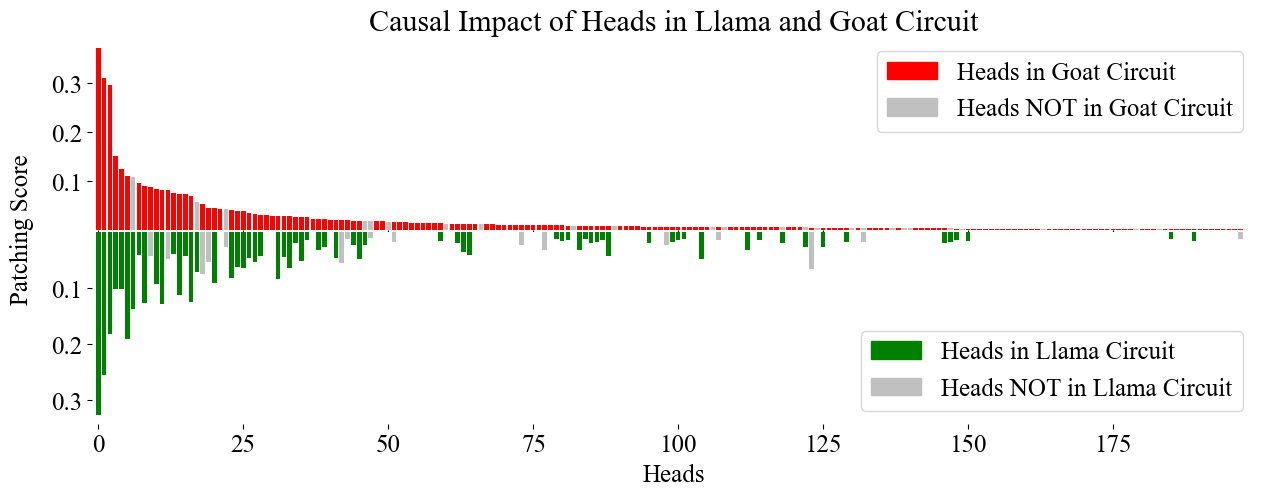

In [11]:
# Plot a bar chart for ordered_all_heads_new and all_heads_old on the opposite side of the x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

# Use times new roman font
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18

ax1.bar(
    [i for i in range(len(all_heads_new))],
    [head[1] for head in all_heads_new],
)
# Color the heads that are in all_heads_new
# c1, c2, c3, c4 = 0, 0, 0, 0
for i in range(len(all_heads_new)):
    if all_heads_new[i][0] in goat_value_fetcher and all_heads_new[i][2] == 0:
        ax1.bar(i, all_heads_new[i][1], color="red")
        # c1 += 1
    elif (
        all_heads_new[i][0] in goat_pos_transmitter
        and all_heads_new[i][2] == 0
    ):
        ax1.bar(i, all_heads_new[i][1], color="red")
        # c2 += 1
    elif (
        all_heads_new[i][0] in goat_pos_detector
        and all_heads_new[i][2] == 2
    ):
        ax1.bar(i, all_heads_new[i][1], color="red")
        # c3 += 1
    elif (
        all_heads_new[i][0] in goat_struct_reader
        and all_heads_new[i][2] == -1
    ):
        ax1.bar(i, all_heads_new[i][1], color="red")
        # c4 += 1
    else:
        ax1.bar(i, all_heads_new[i][1], color="silver")

red_patch = mpatches.Patch(color="red", label="Heads in Goat Circuit")
silver_patch = mpatches.Patch(color="silver", label="Heads NOT in Goat Circuit")
ax1.legend(handles=[red_patch, silver_patch], loc="upper right")

ax2.bar(
    [i for i in range(len(ordered_all_heads_old))],
    [head[1] for head in ordered_all_heads_old],
)
# Color the heads that are in ordered_all_heads_old
c1, c2, c3, c4 = 0, 0, 0, 0
for i in range(len(ordered_all_heads_old)):
    if (
        ordered_all_heads_old[i][0] in llama_value_fetcher
        and ordered_all_heads_old[i][2] == 0
    ):
        ax2.bar(i, ordered_all_heads_old[i][1], color="green")
        c1 += 1
    elif (
        ordered_all_heads_old[i][0] in llama_pos_transmitter
        and ordered_all_heads_old[i][2] == 0
    ):
        ax2.bar(i, ordered_all_heads_old[i][1], color="green")
        c2 += 1
    elif (
        ordered_all_heads_old[i][0] in llama_pos_detector
        and ordered_all_heads_old[i][2] == 2
    ):
        ax2.bar(i, ordered_all_heads_old[i][1], color="green")
        c3 += 1
    elif (
        ordered_all_heads_old[i][0] in llama_struct_reader
        and ordered_all_heads_old[i][2] == -1
    ):
        ax2.bar(i, ordered_all_heads_old[i][1], color="green")
        c4 += 1
    else:
        ax2.bar(i, ordered_all_heads_old[i][1], color="silver")

green_patch = mpatches.Patch(color="green", label="Heads in Llama Circuit")
silver_patch = mpatches.Patch(color="silver", label="Heads NOT in Llama Circuit")
ax2.legend(handles=[green_patch, silver_patch], loc="lower right")

# Remove the blank space before and after the bar chart
plt.xlim(-1, 200 - 0.5)

# Reduce the gap between the two subplots
plt.subplots_adjust(hspace=0.01)
# Flip the y-axis of the second subplot
ax2.invert_yaxis()
# Remove 0.0 from the y-axis of the second subplot
ax1.set_yticks([0.1, 0.2, 0.3])
ax2.set_yticks([0.1, 0.2, 0.3])

# Set a single y-axis label for both subplots
fig.text(0.07, 0.5, "Patching Score", va="center", rotation="vertical")

ax2.set_xlabel("Heads")
ax1.set_title("Causal Impact of Heads in Llama and Goat Circuit")


# Remove plox plot frame
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["left"].set_visible(False)

ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.spines["left"].set_visible(False)

# plt.show()
# Save as pdf
plt.savefig("../experiment_1/results/figures/causal_impact.pdf", dpi=300)

In [100]:
c1, c2, c3, c4, c1 + c2 + c3 + c4

(33, 14, 18, 5, 70)

## Completeness Score

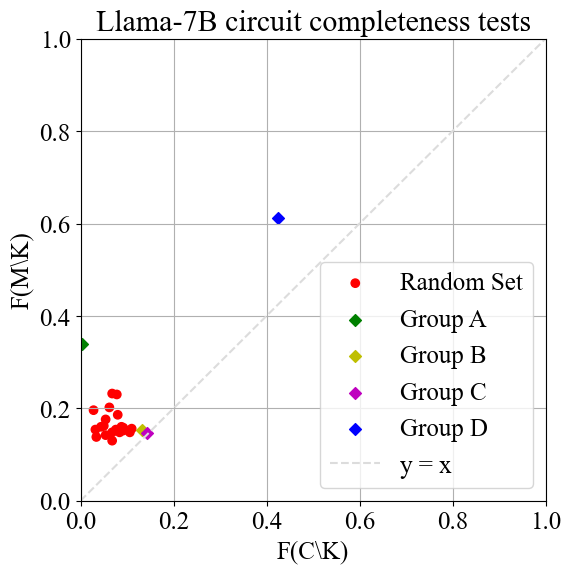

In [23]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18

Random_C = [
    0.08,
    0.044,
    0.068,
    0.034,
    0.076,
    0.054,
    0.088,
    0.068,
    0.092,
    0.028,
    0.106,
    0.054,
    0.032,
    0.092,
    0.062,
    0.068,
    0.11,
    0.084,
    0.05,
    0.078,
]
Random_M = [
    0.186,
    0.16,
    0.232,
    0.138,
    0.154,
    0.176,
    0.16,
    0.148,
    0.158,
    0.196,
    0.148,
    0.142,
    0.154,
    0.152,
    0.202,
    0.13,
    0.156,
    0.148,
    0.162,
    0.23,
]
groups_C = [0.004, 0.132, 0.144, 0.424]
group_M = [0.34, 0.152, 0.146, 0.612]

fig, ax = plt.subplots()
# Set figure size
fig.set_size_inches(6, 6)
lables = ["Random set", "Group A", "Group B", "Group C", "Group D"]

ax.scatter(Random_C, Random_M, c=20 * ["r"], label="Random Set")
ax.scatter(groups_C[0], group_M[0], c=["g"], label="Group A", marker="D")
ax.scatter(groups_C[1], group_M[1], c=["y"], label="Group B", marker="D")
ax.scatter(groups_C[2], group_M[2], c=["m"], label="Group C", marker="D")
ax.scatter(groups_C[3], group_M[3], c=["b"], label="Group D", marker="D")


ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
ax.axline((0, 0), slope=1, color="gainsboro", ls="--", label="y = x")

ax.set_ylabel("F(M\K)")
ax.set_xlabel("F(C\K)")
ax.set_title("Llama-7B circuit completeness tests")
plt.grid()
plt.legend(loc="lower right")

# save as a pdf with tight bounding box
plt.savefig("llama_7b_circuit_completeness.pdf", dpi=200, bbox_inches="tight")